In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
matplotlib.__version__

'2.2.2'

# Generate Events using `numpythia`

In [7]:
from numpythia import Pythia, STATUS, HAS_END_VERTEX, ABS_PDG_ID
import operator
import numpy as np

In [8]:
from numpythia import PYTHIA_VERSION

In [9]:
PYTHIA_VERSION

'8.230'

In [86]:
config_path = 'test.cmnd'

In [6]:
# selection = ((STATUS == 1) & ~HAS_END_VERTEX & # final state
#             (ABS_PDG_ID != 12) & (ABS_PDG_ID != 14) & (ABS_PDG_ID != 16)) # not a neutrino

In [5]:
# events_particles = []
# events_weights = []
# for event in pythia(events=10): # generate 10 events
#     events_weights.append(event.weights)
#     events_particles.append(event.all())
    
# events_weights = np.array(events_weights)
# events_weights = events_weights.view(
#                     dtype=[(n, 'float64') for n in pythia.weight_labels]
#                 )
# events_particles = np.array(events_particles)

In [6]:
# events_particles.shape # number of events (# of particles per event is variable)

(10,)

In [7]:
# events_particles[0] # all particles in event 0

array([ ( 6500.        ,  0.        ,   0.        ,  6499.99993228,   9.38269998e-01,   0.00000000e+00,  0.        ,  0.        ,  0.        , 2212,  4),
       ( 1430.29555627, -2.49604954,   2.03199668,  1430.29193489,   2.15791864e-05,   0.00000000e+00,  0.        ,  0.        ,  0.        ,    1, 61),
       (  325.36191603,  0.7867963 ,  -3.05682378,   325.34660469,  -5.39479661e-06,   0.00000000e+00,  0.        ,  0.        ,  0.        ,   21, 61),
       ...,
       (   90.20031273, -3.4564092 ,  83.93954889,   -32.83373522,   4.97610000e-01,   0.00000000e+00,  0.        ,  0.        ,  0.        ,  130,  1),
       (   23.46918766, -0.89007211,  21.89382126,    -8.40661238,   0.00000000e+00,  -8.91984030e-05,  0.00236055, -0.00090601,  0.00253003,   22,  1),
       (   50.72976004, -1.72588114,  47.33489652,   -18.16418068,   0.00000000e+00,  -8.91984030e-05,  0.00236055, -0.00090601,  0.00253003,   22,  1)],
      dtype=[('E', '<f8'), ('px', '<f8'), ('py', '<f8'), ('pz', '<f8

In [8]:
# events_weights.shape

(10, 1)

In [9]:
# events_weights['fsr05']

array([[ 0.0511755 ],
       [ 0.0091269 ],
       [ 0.59757694],
       [ 0.00581692],
       [ 0.11621288],
       [ 0.03623035],
       [ 0.56045468],
       [ 0.62498139],
       [ 0.26518123],
       [ 0.17919664]])

# Cluster Jets in the 0th Event using `pyjet`

In [11]:
from pyjet import cluster

In [7]:
# # placeholder
# events_constituents = []

# # loop through events
# for particles in events_particles:
#     # cluster jets using anti_kt(R=0.4)
#     sequence = cluster(particles[['E', 'px', 'py', 'pz']],
#         algo='antikt',
#         ep=True,
#         R=0.4)
#     # remove jets with pt < 10 GeV
#     jets = sequence.inclusive_jets(ptmin=10.0)
#     events_constituents.append([j.constituents() for j in jets[0:2]])

# events_constituents = np.array(events_constituents)


In [8]:
# events_constituents is an array of dimensions (n_events, 2=n_jets)
# each entry is a list of constituents of type PseudoJet

In [12]:
def _properties(constituents):
    '''
    Arguments:
    ----------
        constituents: iterable of objects of type PseudoJet
        (see http://fastjet.fr/repo/doxygen-3.0.0/classfastjet_1_1PseudoJet.html)

    Returns:
    --------
        recarray of constituents' properties: e, et, eta, mass, phi, pt, px, py, pz
    '''
# 	return np.array(
# 		[np.array([c.e, c.et, c.eta, c.mass, c.phi, c.pt, c.px, c.py, c.pz])
# 			for c in constituents]).view(dtype=[(l, 'float64')
# 				for l in ('E', 'Et', 'eta', 'm', 'phi', 'pt', 'px', 'py', 'pz')])
    return np.array([np.array([c.e, c.et, c.eta, c.mass, c.phi, c.pt, c.px, c.py, c.pz]) 
            for c in constituents])

In [13]:
def _padded(properties, max_len=50, n_properties=9):
    '''
    Arguments:
    ----------
        
    Returns:
    --------
    '''
    data = np.zeros((2, max_len, n_properties))
    lengths = []
    ntracks = []
    
    for i, jet in enumerate(properties):
    
        # take all particles unless there are more than max_len 
        nparticles = jet.shape[0] 
        ntracks.append(nparticles)
        data[i, :(min(nparticles, max_len)), :] = jet[:(min(nparticles, max_len)), :] 
        lengths.append(min(nparticles, max_len))
        
    return data, lengths, ntracks

In [14]:
def get_leadingjets_constituents(events_particles, jet_ptmin, max_len=50):
    '''
    Arguments:
    ----------
        events_particles:
        jet_ptmin:

    Returns:
    --------
        numpy array of shape (n_events, 2) where every jet entry is a list of
        constituents' kinematic properties
    '''
    # placeholder
    events_constituents = []
    events_lengths = []
    events_nparticles = []
    events_jetpts = []

    # loop through events
    for particles in events_particles:
        # cluster jets using anti_kt(R=0.4)
        sequence = cluster(particles[['E', 'px', 'py', 'pz']],
            algo='antikt',
            ep=True,
            R=0.4)
        # remove jets with pt < 10 GeV
        jets = sequence.inclusive_jets(ptmin=jet_ptmin)
        data, lengths, nparticles = _padded(
            [_properties(
                sorted(
                    j.constituents(), key=operator.attrgetter('pt'), reverse=True)
                ) for j in jets[0:2]
            ], max_len=max_len
        )
        events_constituents.append(data)
        events_lengths.append(lengths)
        events_nparticles.append(nparticles)
        events_jetpts.append([j.pt for j in jets[0:2]])

    return np.array(events_constituents), np.array(events_lengths), np.array(events_nparticles), np.array(events_jetpts)

In [15]:
# constituents, lengths = get_leadingjets_constituents(events_particles, 10.0)

In [16]:
# lengths.shape

In [14]:
# constituents.shape

In [15]:
# leading_jet = np.squeeze(constituents[:, 0, :, :])
# subleading_jet = np.squeeze(constituents[:, 1, :, :])

In [16]:
# print leading_jet.shape, subleading_jet.shape

In [17]:
# # sort the data by length of sequence in decreasing order (because PyTorch)
# leading_jet = leading_jet[np.argsort(lengths[:, 0])[::-1]]
# subleading_jet = subleading_jet[np.argsort(lengths[:, 1])[::-1]]

In [84]:
event_particles, weights = generate_events(config_path, 2)

events_constituents = []
events_lengths = []
events_nparticles = []
events_jetpts = []

# loop through events
for particles in event_particles:
    # cluster jets using anti_kt(R=0.4)
    sequence = cluster(particles[['E', 'px', 'py', 'pz']],
        algo='antikt',
        ep=True,
        R=0.4)
    # remove jets with pt < 10 GeV
    jets = sequence.inclusive_jets(ptmin=10)
#     data, lengths, nparticles = _padded(
    blah = [_properties(
            sorted(
                j.constituents(), key=operator.attrgetter('pt'), reverse=True)
            ) for j in jets[0:2]
        ]#, max_len=150
#     )

In [59]:
np.array(blah)[0].shape

(57, 9)

In [17]:
def generate_events(config_path, nevents):
    '''
    Arguments:
    ----------
        config_path:
        nevents:

    Returns:
    --------
        events_particles:
        events_weights:
    '''
    pythia = Pythia(config_path, verbosity=1)
    variations = pythia.weight_labels

    # only consider final state particles that are not neutrinos
    selection = ((STATUS == 1) & ~HAS_END_VERTEX & # final state
        (ABS_PDG_ID != 12) & (ABS_PDG_ID != 14) & (ABS_PDG_ID != 16)) # not a neutrino

    # placeholders for particles and weights
    events_particles = []
    events_weights = []
    # generate events from pythia
    for event in pythia(events=nevents):
        events_weights.append(event.weights)
        events_particles.append(event.all(selection))
    # convert to numpy arrays for usability
    events_weights = np.array(events_weights)
    events_weights = events_weights.view(
                        dtype=[(n, 'float64') for n in variations])
    events_particles = np.array(events_particles)

    return events_particles, events_weights

# Data Preparation in PyTorch

Data handling in PyTorch recommends using a Dataset with a DataLoader. See <a href="http://pytorch.org/tutorials/beginner/data_loading_tutorial.html">this</a> for instructions.

> `torch.utils.data.Dataset` is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

> `__len__` so that `len(dataset)` returns the size of the dataset.

> `__getitem__` to support the indexing such that `dataset[i]` can be used to get iith sample

In [18]:
MAX_LENGTH = 150

In [19]:
from torch.utils.data import Dataset, DataLoader
class DijetDataset(Dataset):
    '''
    Dataset of jet components for leading and subleading jet in QCD events.
    '''
    def __init__(self, config_path, nevents=100, max_len=50, min_lead_pt=None):
        self.nevents = nevents
        particles, self.weights = generate_events(config_path, nevents)
        constituents, lengths, self.nparticles, self.jetpts = get_leadingjets_constituents(
            particles, jet_ptmin=10.0, max_len=max_len
        )
        self.leading_jet = np.squeeze(constituents[:, 0, :, :])
        self.subleading_jet = np.squeeze(constituents[:, 1, :, :])
        
        self.lengths = lengths
        
        if min_lead_pt is not None:
            self.nevents = sum(self.jetpts[:, 0] > min_lead_pt)
            self.leading_jet = self.leading_jet[self.jetpts[:, 0] > min_lead_pt]
            self.subleading_jet = self.subleading_jet[self.jetpts[:, 0] > min_lead_pt]
            self.lengths = self.lengths[self.jetpts[:, 0] > min_lead_pt]
            self.nparticles = self.nparticles[self.jetpts[:, 0] > min_lead_pt]
            self.weights = self.weights[self.jetpts[:, 0] > min_lead_pt]
            self.jetpts = self.jetpts[self.jetpts[:, 0] > min_lead_pt]
            
        
    def __len__(self):
        return self.nevents

    def __getitem__(self, idx):
        sample = {
            'leading_jet': self.leading_jet[idx],
            'subleading_jet': self.subleading_jet[idx],
#             'sorted_lengths': self.sorted_lengths[idx],
            'unsorted_lengths': self.lengths[idx],
            'nparticles': self.nparticles[idx],
            'jet_pts': self.jetpts[idx]
#             'sortback_leading': self.sortback_leading[idx],
#             'sortback_subleading': self.sortback_subleading[idx],
            
        }
        sample.update({
            'weights_' + name: self.weights[name][idx] for name in self.weights.dtype.names})
        return sample

In [15]:
# d = DijetDataset(config_path, nevents=100000, max_len=MAX_LENGTH, min_lead_pt=500) # 1 min for 1000 events
# 8 min for 10000

In [40]:
# dquick = DijetDataset(config_path, nevents=10000, max_len=MAX_LENGTH)

In [141]:
import cPickle as pickle
# pickle.dump(d, open('./dataset_100k_l150.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
d = pickle.load(open('./dataset_100k_l150.pkl', 'r'))

In [142]:
d[:].keys()

['weights_fs20',
 'jet_pts',
 'nparticles',
 'leading_jet',
 'subleading_jet',
 'weights_Baseline',
 'unsorted_lengths',
 'weights_fsr05']

In [71]:
d[:]['leading_jet'][:, :, 0].ravel().max()

3265.0199010718707

In [96]:
# d_val = DijetDataset(config_path, nevents=100000, max_len=MAX_LENGTH, min_lead_pt=500) # 1 min for 1000 events
# pickle.dump(d_val, open('./dataset_val_100k_l150.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
d_val = pickle.load(open('./dataset_val_23ee122.pkl', 'r'))

In [97]:
# d_test = DijetDataset(config_path, nevents=100000, max_len=MAX_LENGTH, min_lead_pt=500) # 1 min for 1000 events
# # import cPickle as pickle
# pickle.dump(d_test, open('./dataset_test_100k_l150.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
d_test = pickle.load(open('./dataset_test_23ee122.pkl', 'r'))

In [27]:
d[:].keys()

['weights_fs20',
 'jet_pts',
 'nparticles',
 'leading_jet',
 'subleading_jet',
 'weights_Baseline',
 'unsorted_lengths',
 'weights_fsr05']

In [45]:
# make sure that no subleading jet has higher pt than the corresponding leading jet (this should output 0)
sum(d[:]['jet_pts'][:, 0] < d[:]['jet_pts'][:, 1])

0

In [47]:
sum(d[:]['jet_pts'][:, 0] < 500)

1468

In [15]:
d[:]['leading_jet'].shape # jets, particles per jet, features per particle

(100000, 150, 9)

In [99]:
BATCH_SIZE=1024

In [18]:
d.jetpts

array([[ 586.39420652,  317.10302207],
       [ 601.31219964,  526.5499683 ],
       [ 640.33292391,  311.99428872],
       ..., 
       [ 593.95189141,  287.56061022],
       [ 635.6946463 ,  373.41970506],
       [ 553.53266922,  411.72622353]])

In [100]:
dataloader = DataLoader(d, # cut: leading jet pT > 500 GeV
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=4)

In [101]:
dataloader_val = DataLoader(d_val,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=4)

In [102]:
dataloader_test = DataLoader(d_test,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=4)

## Data Exploration

Visualize kinematic variables for 1st particle in leading jet, weighted appropriately to distinguish the two datasets.

In [35]:
import matplotlib
matplotlib.rcParams.update({'font.size' : 20})

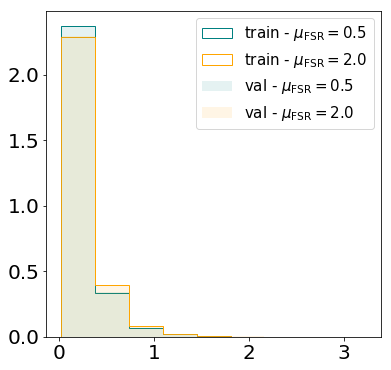

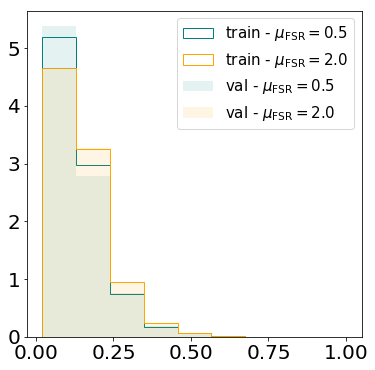

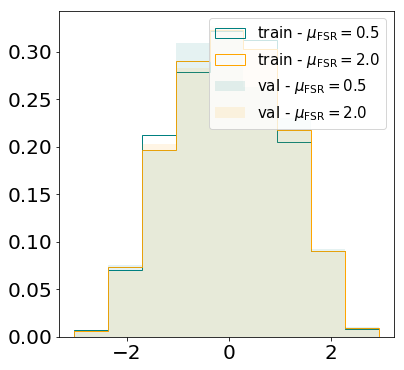

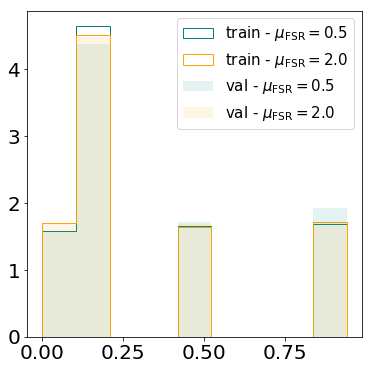

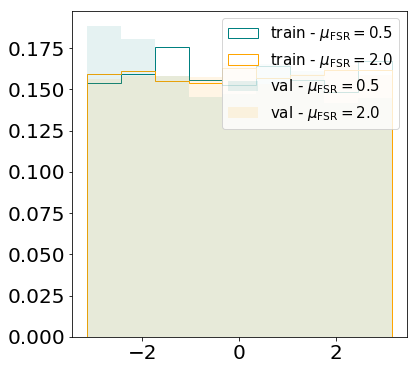

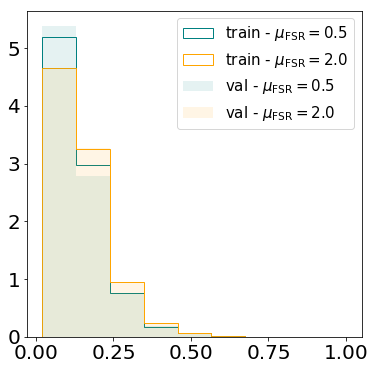

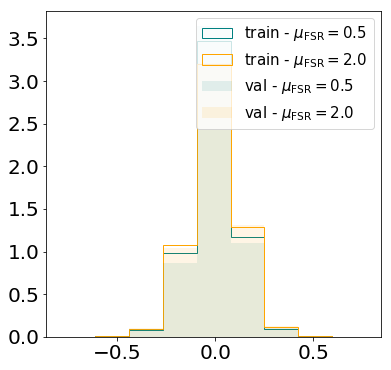

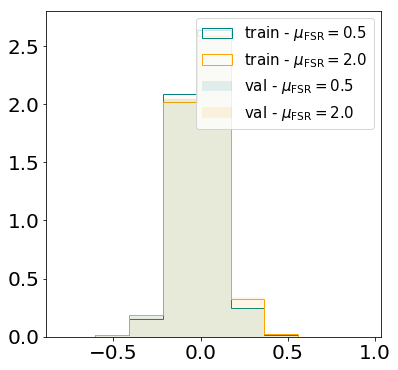

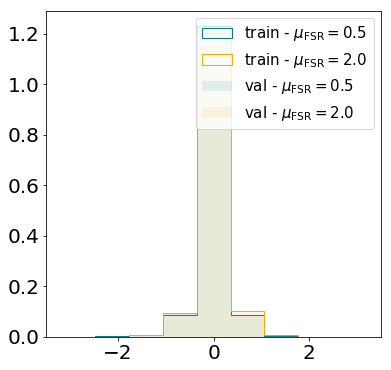

In [135]:
for i in range(9):
    plt.figure(figsize=(6,6))
    bins = np.linspace(d[:]['leading_jet'][:, 0, i].min(), d[:]['leading_jet'][:, 0, i].max(), 10)
    plt.hist(d[:]['leading_jet'][:, 0, i], weights=d[:]['weights_fsr05'],
            histtype='step', normed=True, label=r'train - $\mu_\mathrm{FSR} = 0.5$', bins=bins, color='teal')
    
    plt.hist(d[:]['leading_jet'][:, 0, i], weights=d[:]['weights_fsr20'],
            histtype='step', normed=True, label=r'train - $\mu_\mathrm{FSR} = 2.0$', bins=bins, color='orange')
    
    plt.hist(d_val[:]['leading_jet'][:, 0, i], weights=d_val[:]['weights_fsr05'], alpha=0.1,
            histtype='stepfilled', normed=True, label=r'val - $\mu_\mathrm{FSR} = 0.5$', bins=bins, color='teal')
    
    plt.hist(d_val[:]['leading_jet'][:, 0, i], weights=d_val[:]['weights_fsr20'], alpha=0.1,
            histtype='stepfilled', normed=True, label=r'val - $\mu_\mathrm{FSR} = 2.0$', bins=bins, color='orange')
    
    plt.legend(fontsize=15)
    plt.show()

In [139]:
dataloader.dataset[:]

{'jet_pts': array([[ 578.52503776,  463.74582788],
        [ 676.22926903,  673.87004698],
        [ 600.75236141,  563.89558926],
        ..., 
        [ 593.73611517,  550.00658151],
        [ 509.08892996,  503.22611915],
        [ 513.89165982,  474.35872994]]),
 'leading_jet': array([[[  4.57651091e-02,   4.42328537e-02,   2.62459500e-01, ...,
           -2.74472374e-02,   3.46838123e-02,   1.17423940e-02],
         [  4.53081792e-02,   4.35300192e-02,   2.84864647e-01, ...,
           -2.68656254e-02,   3.42502958e-02,   1.25684935e-02],
         [  4.50176153e-02,   4.31688655e-02,   2.91629097e-01, ...,
           -2.92949677e-02,   3.17070640e-02,   1.27684444e-02],
         ..., 
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.0

In [24]:
# Number of tracks

In [25]:
np.linspace(0, 110, 111)

array([   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
          9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
         18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,
         27.,   28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,
         36.,   37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,
         45.,   46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,
         54.,   55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,
         63.,   64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,
         72.,   73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,
         81.,   82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,
         90.,   91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,
         99.,  100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,
        108.,  109.,  110.])

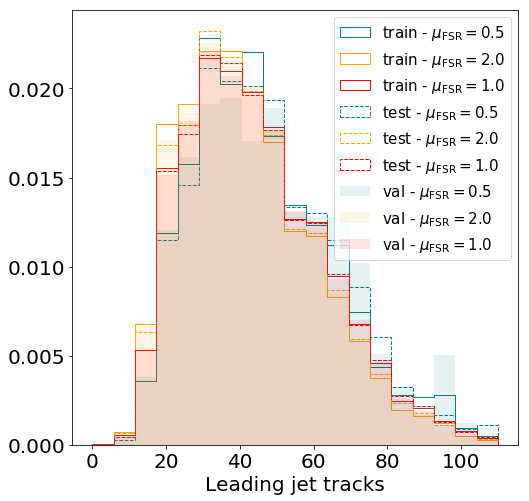

In [109]:
plt.figure(figsize=(8,8))
bins = np.linspace(0, 110, 20) #np.linspace(0, d[:]['nparticles'][:, 0].max(), 50)
_ = plt.hist(d[:]['nparticles'][:, 0], weights=d[:]['weights_fsr05'], histtype='step', bins=bins,
            label=r'train - $\mu_\mathrm{FSR} = 0.5$', normed=True, color='teal')

_ = plt.hist(d[:]['nparticles'][:, 0], weights=d[:]['weights_fsr20'], histtype='step', bins=bins,
            label=r'train - $\mu_\mathrm{FSR} = 2.0$', normed=True, color='orange')

_ = plt.hist(d[:]['nparticles'][:, 0], weights=d[:]['weights_Baseline'], histtype='step', bins=bins,
            label=r'train - $\mu_\mathrm{FSR} = 1.0$', normed=True, color='red')

_ = plt.hist(d_test[:]['nparticles'][:, 0], weights=d_test[:]['weights_fsr05'], histtype='step', bins=bins,
            label=r'test - $\mu_\mathrm{FSR} = 0.5$', normed=True, color='teal', linestyle='dashed')

_ = plt.hist(d_test[:]['nparticles'][:, 0], weights=d_test[:]['weights_fsr20'], histtype='step', bins=bins,
            label=r'test - $\mu_\mathrm{FSR} = 2.0$', normed=True, color='orange', linestyle='dashed')

_ = plt.hist(d_test[:]['nparticles'][:, 0], weights=d_test[:]['weights_Baseline'], histtype='step', bins=bins,
            label=r'test - $\mu_\mathrm{FSR} = 1.0$', normed=True, color='red', linestyle='dashed')

_ = plt.hist(d_val[:]['nparticles'][:, 0], weights=d_val[:]['weights_fsr05'], histtype='stepfilled', bins=bins,
            label=r'val - $\mu_\mathrm{FSR} = 0.5$', normed=True, color='teal', alpha=0.1)

_ = plt.hist(d_val[:]['nparticles'][:, 0], weights=d_val[:]['weights_fsr20'], histtype='stepfilled', bins=bins,
            label=r'val - $\mu_\mathrm{FSR} = 2.0$', normed=True, color='orange', alpha=0.1)

_ = plt.hist(d_val[:]['nparticles'][:, 0], weights=d_val[:]['weights_Baseline'], histtype='stepfilled', bins=bins,
            label=r'val - $\mu_\mathrm{FSR} = 1.0$', normed=True, color='red', alpha=0.1)

plt.legend(fontsize=15)
plt.xlabel('Leading jet tracks')

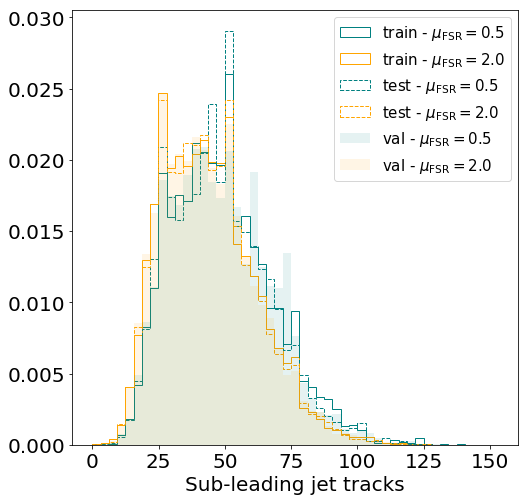

In [110]:
plt.figure(figsize=(8,8))
bins = np.linspace(0, d[:]['nparticles'][:, 1].max(), 50)
_ = plt.hist(d[:]['nparticles'][:, 1], weights=d[:]['weights_fsr05'], histtype='step', bins=bins,
            label=r'train - $\mu_\mathrm{FSR} = 0.5$', normed=True, color='teal')

_ = plt.hist(d[:]['nparticles'][:, 1], weights=d[:]['weights_fsr20'], histtype='step', bins=bins,
            label=r'train - $\mu_\mathrm{FSR} = 2.0$', normed=True, color='orange')

_ = plt.hist(d_test[:]['nparticles'][:, 1], weights=d_test[:]['weights_fsr05'], histtype='step', bins=bins,
            label=r'test - $\mu_\mathrm{FSR} = 0.5$', normed=True, color='teal', linestyle='dashed')

_ = plt.hist(d_test[:]['nparticles'][:, 1], weights=d_test[:]['weights_fsr20'], histtype='step', bins=bins,
            label=r'test - $\mu_\mathrm{FSR} = 2.0$', normed=True, color='orange', linestyle='dashed')

_ = plt.hist(d_val[:]['nparticles'][:, 1], weights=d_val[:]['weights_fsr05'], histtype='stepfilled', bins=bins,
            label=r'val - $\mu_\mathrm{FSR} = 0.5$', normed=True, color='teal', alpha=0.1)

_ = plt.hist(d_val[:]['nparticles'][:, 1], weights=d_val[:]['weights_fsr20'], histtype='stepfilled', bins=bins,
            label=r'val - $\mu_\mathrm{FSR} = 2.0$', normed=True, color='orange', alpha=0.1)

plt.legend(fontsize=15)
plt.xlabel('Sub-leading jet tracks')

(array([  1.30000000e+01,   1.20000000e+02,   9.05000000e+02,
          4.61800000e+03,   1.67110000e+04,   3.10130000e+04,
          2.44470000e+04,   6.69100000e+03,   7.15000000e+02,
          3.40000000e+01]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

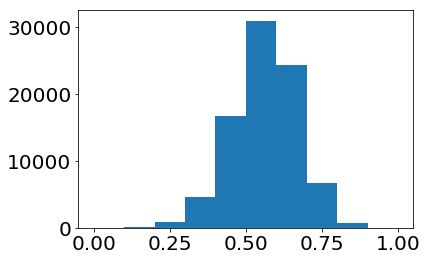

In [113]:
_w = np.log(d[:]['weights_fsr05'].ravel()) - np.log(d[:]['weights_fsr05'].ravel()).min()
plt.hist(_w / _w.max())

In [28]:
print d[:]['weights_fsr05'].max(), d[:]['weights_fsr05'].min(), d[:]['weights_fsr05'].mean()

671.569337465 2.63570353716e-06 0.939205230712


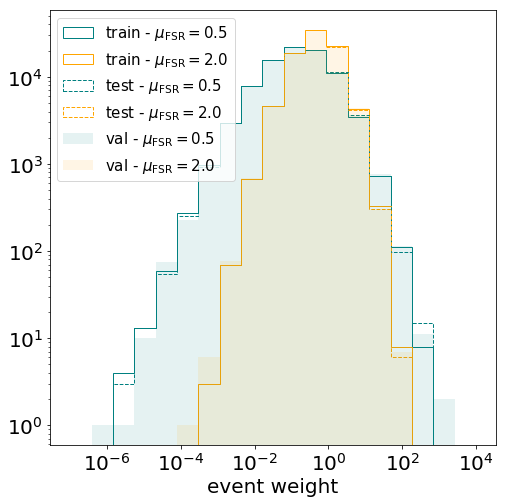

In [29]:
plt.figure(figsize=(8,8))
bins = np.logspace(-7, 4, 20)
_ = plt.hist(d[:]['weights_fsr05'], bins=bins, histtype='step',
            label=r'train - $\mu_\mathrm{FSR} = 0.5$', color='teal')
_ = plt.hist(d[:]['weights_fs20'], bins=bins, histtype='step',
            label=r'train - $\mu_\mathrm{FSR} = 2.0$', color='orange')

_ = plt.hist(d_test[:]['weights_fsr05'], bins=bins, histtype='step',
            label=r'test - $\mu_\mathrm{FSR} = 0.5$', color='teal', linestyle='dashed')
_ = plt.hist(d_test[:]['weights_fs20'], bins=bins, histtype='step',
            label=r'test - $\mu_\mathrm{FSR} = 2.0$', color='orange', linestyle='dashed')

_ = plt.hist(d_val[:]['weights_fsr05'], bins=bins, histtype='stepfilled', alpha=0.1,
            label=r'val - $\mu_\mathrm{FSR} = 0.5$', color='teal')
_ = plt.hist(d_val[:]['weights_fs20'], bins=bins, histtype='stepfilled', alpha=0.1,
            label=r'val - $\mu_\mathrm{FSR} = 2.0$', color='orange')

plt.xlabel('event weight')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper left', fontsize=15)

In [79]:
# plt.figure(figsize=(8,8))
# bins = np.logspace(-10, 4, 20)
# _ = plt.hist(dquick[:]['weights_fsr05'], bins=bins, histtype='step',
#             label=r'$\mu_\mathrm{FSR} = 0.5$ all', color='teal')
# _ = plt.hist(dquick[:]['weights_fsr20'], bins=bins, histtype='step',
#             label=r'$\mu_\mathrm{FSR} = 2.0$ all', color='orange')
# _ = plt.hist(dquick[:]['weights_fsr09'], bins=bins, histtype='step',
#             label=r'$\mu_\mathrm{FSR} = 0.9$ all', color='red')

# _ = plt.hist(dquick[:]['weights_fsr05'][dquick[:]['jet_pts'][:, 0] > 500], bins=bins, histtype='step',
#             label=r'$\mu_\mathrm{FSR} = 0.5, p_T > 500$ GeV', color='teal', linestyle='dashed')
# _ = plt.hist(dquick[:]['weights_fsr20'][dquick[:]['jet_pts'][:, 0] > 500], bins=bins, histtype='step',
#             label=r'$\mu_\mathrm{FSR} = 2.0, p_T > 500$ GeV', color='orange', linestyle='dashed')
# _ = plt.hist(dquick[:]['weights_fsr09'][dquick[:]['jet_pts'][:, 0] > 500], bins=bins, histtype='step',
#             label=r'$\mu_\mathrm{FSR} = 0.9, p_T > 500$ GeV', color='red', linestyle='dashed')

# plt.yscale('log')
# plt.xscale('log')
# plt.legend(loc='upper left', fontsize=15)

In [80]:
# plt.figure(figsize=(8,8))
# bins = np.logspace(-10, 4, 20)
# _ = plt.hist(dquick[:]['weights_fsr05'][dquick[:]['jet_pts'][:, 0] > 500], bins=bins, histtype='step',
#             label=r'$\mu_\mathrm{FSR} = 0.5$', color='teal')
# _ = plt.hist(dquick[:]['weights_fsr20'][dquick[:]['jet_pts'][:, 0] > 500], bins=bins, histtype='step',
#             label=r'$\mu_\mathrm{FSR} = 2.0$', color='orange')
# _ = plt.hist(dquick[:]['weights_fsr09'][dquick[:]['jet_pts'][:, 0] > 500], bins=bins, histtype='step',
#             label=r'$\mu_\mathrm{FSR} = 0.9$', color='red')

# plt.yscale('log')
# plt.xscale('log')
# plt.legend(loc='upper left', fontsize=15)

# PyTorch Model

In [4]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

In [530]:
# from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# class DoubleLSTM(nn.Module):

#     def __init__(self, input_size, output_size, num_layers, dropout, bidirectional,
#                  batch_size, tagger_output_size, dim_b, dim_c):
#         super(DoubleLSTM, self).__init__()
        
#         # members
#         self.input_size = input_size
#         self.output_size = output_size
#         self.num_layers = num_layers
#         self.num_directions = 2 if bidirectional else 1
#         self.batch_size = batch_size
#         self.dim_b = dim_b
#         self.dim_c = dim_c
        
#         # LSTM layers
#         self.lstm_lead = nn.LSTM(input_size=input_size, hidden_size=output_size,
#                                  num_layers=num_layers, batch_first=True,
#                                  dropout=dropout, bidirectional=bidirectional)
        
#         self.lstm_sublead = nn.LSTM(input_size=input_size, hidden_size=output_size,
#                                     num_layers=num_layers, batch_first=True,
#                                     dropout=dropout, bidirectional=bidirectional)
        
#         # minibatch discimination
#         self.minibatch_tensor = nn.Parameter(self.init_minibatch(), requires_grad=True)
        
#         # output dense layer
#         self.dense = nn.Linear(
#             #output_size * self.num_directions * 2 + # for lstm concat
#                             dim_b,
#                             tagger_output_size)
# #         self.dense = nn.Linear(output_size * self.num_directions * 2 + dim_b,
# #                                32)
# #         self.dense0 = nn.Linear(32,
# #                                16)
# #         self.dense1 = nn.Linear(16,
# #                                tagger_output_size)


#     def init_hidden(self, batch_size):
#         '''
#         Initialize LSTM hidden states to zero at the beginning of each new sequence
#         '''
#         return (Variable(torch.zeros(
#                     self.num_layers * self.num_directions,
#                     batch_size, 
#                     self.output_size), requires_grad=False),
#                 Variable(torch.zeros(
#                     self.num_layers * self.num_directions,
#                     batch_size,
#                     self.output_size), requires_grad=False)
#                )
    
#     def init_minibatch(self):
#         return torch.randn(self.output_size * self.num_directions * 2, # 2 = n_streams
#                           self.dim_b * self.dim_c)


#     def forward(self, leading_jets, subleading_jets, lengths, weights):
        
#         # initialize LSTM hidden states to erase history of previous sequence
#         hidden_lead = self.init_hidden(leading_jets.shape[0])
#         hidden_sublead = self.init_hidden(subleading_jets.shape[0])
        
# #         print lengths
#         # sort the data by length of sequence in decreasing order (because PyTorch)
#         leading_jets = leading_jets[np.argsort(lengths[:, 0])[::-1]]
#         subleading_jets = subleading_jets[np.argsort(lengths[:, 1])[::-1]]
#         sorted_lengths = np.sort(lengths, axis=0)[::-1]
#         sortback_leading = np.argsort([np.argsort(lengths[:, 0])[::-1]])[0]
#         sortback_subleading = np.argsort([np.argsort(lengths[:, 1])[::-1]])[0]
# #         print sorted_lengths

#         # pack sequences
#         packed_leading_jets = nn.utils.rnn.pack_padded_sequence(
#             leading_jets, batch_first=True, lengths=sorted_lengths[:, 0]
#         )
#         packed_subleading_jets = nn.utils.rnn.pack_padded_sequence(
#             subleading_jets, batch_first=True, lengths=sorted_lengths[:, 1]
#         )   
#         # LSTMs
#         lstm_lead_out, self.hidden_lead = self.lstm_lead(
#             packed_leading_jets, hidden_lead)
#         lstm_sublead_out, self.hidden_sublead = self.lstm_sublead(
#             packed_subleading_jets, hidden_sublead)
               
#         # unpack sequences
#         lstm_lead_out_1, _ = pad_packed_sequence(lstm_lead_out, batch_first=True)
#         lstm_sublead_out_1, _ = pad_packed_sequence(lstm_sublead_out, batch_first=True)

#         # sort back
#         lstm_lead_out_2 = lstm_lead_out_1[sortback_leading]
# #         lstm_lead_out = lstm_lead_out[:, -1, :] # only last timestep output
#         lstm_sublead_out_2 = lstm_sublead_out_1[sortback_subleading]
# #         lstm_sublead_out = lstm_sublead_out[:, -1, :] # only last timestep output
        
#         # return output of last timestep (not full sequence)
#         idx_lead = Variable(
#             torch.from_numpy(lengths[:, 0] - 1).type(torch.LongTensor),
#             requires_grad=False).view(-1, 1).expand(lstm_lead_out_2.size(0), lstm_lead_out_2.size(2)).unsqueeze(1)
#         lstm_lead_out_3 = lstm_lead_out_2.gather(1, idx_lead).squeeze()
#         idx_sublead = Variable(
#             torch.from_numpy(lengths[:, 1] - 1).type(torch.LongTensor),
#             requires_grad=False).view(-1, 1).expand(lstm_sublead_out_2.size(0), lstm_sublead_out_2.size(2)).unsqueeze(1)
#         lstm_sublead_out_3 = lstm_sublead_out_2.gather(1, idx_sublead).squeeze()
        
        
#         # concatenate outputs of the 2 LSTMs
#         merge = torch.cat([lstm_lead_out_3, lstm_sublead_out_3], 1)

#         # minibatch discrimination (from AaronYALai)
#         minibatch_matrix_ = merge.mm(self.minibatch_tensor)
#         minibatch_matrix = minibatch_matrix_.view(-1, self.dim_b, self.dim_c)
#         out_tensor = []
#         for i in range(minibatch_matrix.size()[0]): # loop thru examples in batch size
#             out_i = None
#             for j in range(minibatch_matrix.size()[0]): # loop thru examples in batch size
#                 o_i = torch.sum(
#                     torch.abs(minibatch_matrix[i, :, :] - minibatch_matrix[j, :, :]), 1)
#                 o_i = torch.exp(-o_i)
#                 if out_i is None:
#                     out_i = o_i * Variable(weights[j], requires_grad=False).type(torch.FloatTensor)
#                 else:
#                     out_i = out_i + o_i * Variable(weights[j], requires_grad=False).type(torch.FloatTensor)
#             out_tensor.append(out_i * Variable(weights[i], requires_grad=False).type(torch.FloatTensor))
#             # out_i is of dimensions B
        
#         # out_tensor is a list of len = batch_size of tensors of dim B
#         self.minibatch_out_pre = torch.cat(tuple(out_tensor)).view(
#             minibatch_matrix.size()[0], self.dim_b)
#         # minibatch_out is [batch_size, B]
#         #merge = torch.cat((merge, minibatch_out), 1)
#         minibatch_out = F.tanh(self.minibatch_out_pre)
# #         merge = minibatch_out
# #         self.pre_fc = merge
#         # output layer
# #         h = F.relu(self.dense(merge))
# #         h = F.relu(self.dense0(h))
# #         outputs = F.sigmoid(self.dense1(h))
# #         outputs = F.sigmoid(self.dense(minibatch_out)) #merge))
#         outputs = self.dense(minibatch_out)
#         return outputs

In [8]:
BATCH_SIZE=64

In [9]:
def train_on_batch(model, optimizer, epoch, batch_idx, data, name_weights):
    
    leading_input = Variable(data['leading_jet'].type(torch.FloatTensor), requires_grad=False)
    subleading_input = Variable(data['subleading_jet'].type(torch.FloatTensor), requires_grad=False)
    unsorted_lengths = data['unsorted_lengths'].numpy()
    weights = data[name_weights].type(torch.FloatTensor)
    #torch.log(data[name_weights] / 1e-1).type(torch.FloatTensor)
    
    batch_size = leading_input.shape[0]

    batch_weights = Variable(
            weights.resize_(1, batch_size),
            requires_grad=False) / torch.sum(weights) # normalized

    optimizer.zero_grad()
    predictions = model(leading_input, subleading_input, unsorted_lengths, batch_weights, batch_size)

    if name_weights == 'weights_fs20':
        targets = Variable(torch.from_numpy(np.ones((batch_size, 1))).type(torch.FloatTensor),
                          requires_grad=False)
    elif name_weights == 'weights_fsr05':
        targets = Variable(torch.from_numpy(np.zeros((batch_size, 1))).type(torch.FloatTensor),
                          requires_grad=False)
    else:
        raise ValueError
        
    loss_function = nn.BCEWithLogitsLoss() #nn.BCELoss() #weight=batch_weights)
    loss = loss_function(predictions, targets)
    loss.backward()
    optimizer.step()
    
    batch_weighted_loss = loss * batch_size # to compute per epoch loss

    if batch_idx % 5 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch,
            dataloader.batch_size * batch_idx + len(data['leading_jet']),
            len(dataloader.dataset),
            100 * (dataloader.batch_size * batch_idx + len(data['leading_jet'])) / len(dataloader.dataset),
            loss.data[0]))
    return batch_weighted_loss, np.array(model.dense.weight.data.numpy()[0]) # for debugging purposes

In [10]:
# model = DoubleLSTM(input_size=9,
#                    output_size=32,
#                    num_layers=1,
#                    dropout=0.1,
#                    bidirectional=False,
#                    batch_size=BATCH_SIZE,
#                    tagger_output_size=1,
#                    dim_b=12, dim_c=16)

In [11]:
# model

In [534]:
# # binary cross entropy
# # loss_function = nn.BCELoss()
# # loss_function = F.binary_cross_entropy()
# optimizer = optim.SGD(model.parameters(), lr=0.01)

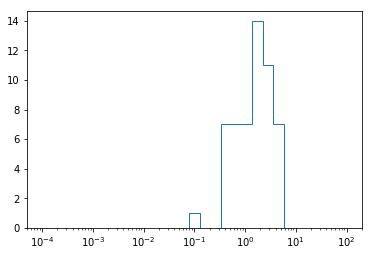

In [379]:
# plt.hist(np.log((data['weights_fsr20'] / 1e-1).numpy()), histtype='step', bins=np.logspace(-4, 2, 30))
# # plt.hist((data['weights_fsr05']).numpy(), histtype='step', bins=np.logspace(-5, 1, 30))
# plt.xscale('log')

In [36]:
# # Does it make sense to have the same batch of examples be shown for the two datasets?
# model.train()
# # f = plt.figure(figsize=(8,8))
# l05 = []
# l20 = []
# for epoch in range(BATCH_SIZE * i_batch): #1
#     for batch_idx, data in enumerate(dataloader):
#         #print 'mu_R FSR = 0.5'
#         last_layer_weights05 = train_on_batch(model, optimizer, epoch, batch_idx, data,
#               'weights_fsr05'
#              )
#         #print 'mu_R FSR = 2.0'
#         last_layer_weights20 = train_on_batch(model, optimizer, epoch, batch_idx, data,
#               'weights_fsr20'
#              )
#     l05.append(last_layer_weights05) # look at weights in last layer from last batch of samples over time (epochs)
#     l20.append(last_layer_weights20)
# # plt.plot(last_layer_weights05, color='blue', alpha=1 - 1./(1+epoch), label='0.5 - epoch: {}'.format(epoch))
# # plt.plot(last_layer_weights20, color='orange', alpha=1 - 1./(1+epoch), label='2.0 - epoch: {}'.format(epoch))

# # plt.legend()
# # plt.show()

In [12]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class DoubleLSTM(nn.Module):

    def __init__(self, input_size, output_size, num_layers, dropout, bidirectional,
                 batch_size, tagger_output_size):
        super(DoubleLSTM, self).__init__()
        
        # members
        self.input_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1
        self.batch_size = batch_size

        # LSTM layers
        self.lstm_lead = nn.LSTM(input_size=input_size, hidden_size=output_size,
                                 num_layers=num_layers, batch_first=True,
                                 dropout=dropout, bidirectional=bidirectional)
        
        self.lstm_sublead = nn.LSTM(input_size=input_size, hidden_size=output_size,
                                    num_layers=num_layers, batch_first=True,
                                    dropout=dropout, bidirectional=bidirectional)
        
        # output dense layer
        self.dense = nn.Linear(
            # multiple is because we have a max pool, min, avg
            2 * (output_size * self.num_directions * 2), #+ # for lstm concat
#             1 * (output_size * self.num_directions * 2), #+ # for lstm concat
#             dim_b,
            tagger_output_size)
        
#         self.dense = nn.Linear(output_size * self.num_directions * 2 + dim_b,
#                                32)
#         self.dense0 = nn.Linear(32,
#                                16)
#         self.dense1 = nn.Linear(16,
#                                tagger_output_size)


    def init_hidden(self, batch_size):
        '''
        Initialize LSTM hidden states to zero at the beginning of each new sequence
        '''
        return (Variable(torch.zeros(
                    self.num_layers * self.num_directions,
                    batch_size, 
                    self.output_size), requires_grad=False),
                Variable(torch.zeros(
                    self.num_layers * self.num_directions,
                    batch_size,
                    self.output_size), requires_grad=False)
               )
    
    def init_batch_dense(self, batch_size):
        a = torch.Tensor(1, batch_size)
        return torch.nn.init.normal(a)


    def forward(self, leading_jets, subleading_jets, lengths, batch_weights, batch_size):
                
        # initialize LSTM hidden states to erase history of previous sequence
        hidden_lead = self.init_hidden(batch_size)
        hidden_sublead = self.init_hidden(batch_size)
        
        # sort the data by length of sequence in decreasing order (because PyTorch)
        leading_jets = leading_jets[np.argsort(lengths[:, 0])[::-1]]
        subleading_jets = subleading_jets[np.argsort(lengths[:, 1])[::-1]]
        sorted_lengths = np.sort(lengths, axis=0)[::-1]
        sortback_leading = np.argsort([np.argsort(lengths[:, 0])[::-1]])[0]
        sortback_subleading = np.argsort([np.argsort(lengths[:, 1])[::-1]])[0]

        # pack sequences
        packed_leading_jets = nn.utils.rnn.pack_padded_sequence(
            leading_jets, batch_first=True, lengths=sorted_lengths[:, 0]
        )
        packed_subleading_jets = nn.utils.rnn.pack_padded_sequence(
            subleading_jets, batch_first=True, lengths=sorted_lengths[:, 1]
        )   
        # LSTMs
        lstm_lead_out, self.hidden_lead = self.lstm_lead(
            packed_leading_jets, hidden_lead)
        lstm_sublead_out, self.hidden_sublead = self.lstm_sublead(
            packed_subleading_jets, hidden_sublead)
               
        # unpack sequences
        lstm_lead_out_1, _ = pad_packed_sequence(lstm_lead_out, batch_first=True)
        lstm_sublead_out_1, _ = pad_packed_sequence(lstm_sublead_out, batch_first=True)

        # sort back
        lstm_lead_out_2 = lstm_lead_out_1[sortback_leading]
#         lstm_lead_out = lstm_lead_out[:, -1, :] # only last timestep output
        lstm_sublead_out_2 = lstm_sublead_out_1[sortback_subleading]
#         lstm_sublead_out = lstm_sublead_out[:, -1, :] # only last timestep output
        
        # return output of last timestep (not full sequence)
        idx_lead = Variable(
            torch.from_numpy(lengths[:, 0] - 1).type(torch.LongTensor),
            requires_grad=False).view(-1, 1).expand(lstm_lead_out_2.size(0), lstm_lead_out_2.size(2)).unsqueeze(1)
        lstm_lead_out_3 = lstm_lead_out_2.gather(1, idx_lead).squeeze()
        idx_sublead = Variable(
            torch.from_numpy(lengths[:, 1] - 1).type(torch.LongTensor),
            requires_grad=False).view(-1, 1).expand(lstm_sublead_out_2.size(0), lstm_sublead_out_2.size(2)).unsqueeze(1)
        lstm_sublead_out_3 = lstm_sublead_out_2.gather(1, idx_sublead).squeeze()
        
        # concatenate outputs of the 2 LSTMs
        merge = torch.cat([lstm_lead_out_3, lstm_sublead_out_3], 1)

#         batch_weights = Variable(
#             weights.resize_(1, batch_size),
#             requires_grad=False) / torch.sum(weights)
#         batch_features = self.batch_dense.mm(merge).expand(batch_size, merge.shape[-1])
        batch_features = batch_weights.mm(merge).expand(batch_size, merge.shape[-1])
        
        weighted_mult = batch_weights.transpose(0, 1).expand(-1, merge.shape[-1]) * merge
#         maxpool = torch.max(weighted_mult, 0)[0].expand(batch_size, -1)
#         minpool = torch.min(weighted_mult, 0)[0].expand(batch_size, -1)
#         avgpool = torch.mean(weighted_mult, 0).expand(batch_size, -1)
        std = torch.std(weighted_mult, 0).expand(batch_size, -1)
        #prod = torch.prod(weighted_mult, 0).expand(batch_size, -1)
        
        batch_features = torch.cat([batch_features, std], 1) # maxpool, minpool, avgpool], 1)#, prod], 1)
        outputs = self.dense(batch_features)
        return outputs
        

In [14]:
model = DoubleLSTM(input_size=9,
                   output_size=32,
                   num_layers=1,
                   dropout=0.1,
                   bidirectional=True,
                   batch_size=BATCH_SIZE,
                   tagger_output_size=1)

In [15]:
model

DoubleLSTM(
  (lstm_lead): LSTM(9, 32, batch_first=True, dropout=0.1, bidirectional=True)
  (lstm_sublead): LSTM(9, 32, batch_first=True, dropout=0.1, bidirectional=True)
  (dense): Linear(in_features=256, out_features=1)
)

In [17]:
model.

<bound method DoubleLSTM.named_parameters of DoubleLSTM(
  (lstm_lead): LSTM(9, 32, batch_first=True, dropout=0.1, bidirectional=True)
  (lstm_sublead): LSTM(9, 32, batch_first=True, dropout=0.1, bidirectional=True)
  (dense): Linear(in_features=256, out_features=1)
)>

In [32]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [33]:
for batch_id, data in enumerate(dataloader):
    if batch_id > 0:
        break
    train_on_batch(model, optimizer, 0, batch_id, data, 'weights_fsr05')
        

Train Epoch: 0 [128/85267 (0%)]	Loss: 0.706048


In [37]:
epoch = 0
batch_idx = batch_id
name_weights = 'weights_fsr05'

leading_input = Variable(data['leading_jet'].type(torch.FloatTensor), requires_grad=False)
subleading_input = Variable(data['subleading_jet'].type(torch.FloatTensor), requires_grad=False)
unsorted_lengths = data['unsorted_lengths'].numpy()
weights = data[name_weights].type(torch.FloatTensor)
#torch.log(data[name_weights] / 1e-1).type(torch.FloatTensor)

batch_size = leading_input.shape[0]

batch_weights = Variable(
        weights.resize_(1, batch_size),
        requires_grad=False) / torch.sum(weights) # normalized

optimizer.zero_grad()
predictions = model(leading_input, subleading_input, unsorted_lengths, batch_weights, batch_size)

if name_weights == 'weights_fs20':
    targets = Variable(torch.from_numpy(np.ones((batch_size, 1))).type(torch.FloatTensor),
                      requires_grad=False)
elif name_weights == 'weights_fsr05':
    targets = Variable(torch.from_numpy(np.zeros((batch_size, 1))).type(torch.FloatTensor),
                      requires_grad=False)
else:
    raise ValueError

loss_function = nn.BCEWithLogitsLoss() #nn.BCELoss() #weight=batch_weights)
loss = loss_function(predictions, targets)

In [39]:
%prun predictions = model(leading_input, subleading_input, unsorted_lengths, batch_weights, batch_size)

In [38]:
%prun loss.backward()

In [35]:

loss.backward()
optimizer.step()

batch_weighted_loss = loss * batch_size # to compute per epoch loss

if batch_idx % 5 == 0:
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch,
        dataloader.batch_size * batch_idx + len(data['leading_jet']),
        len(dataloader.dataset),
        100 * (dataloader.batch_size * batch_idx + len(data['leading_jet'])) / len(dataloader.dataset),
        loss.data[0]))

In [36]:
# save out weights in last dense layer for debugging purposes
DEBUG = True
best_loss = float('inf')
wait = 0

if DEBUG:
    l05 = []
    l20 = []
    
# time: 2 min and a half per epoch for training
for epoch in range(100): # n_epochs
    
    # training
    model.train()
    
    # initialize per-epoch losses
    batch_weighted_loss05_epoch = 0
    batch_weighted_loss20_epoch = 0
    
    for batch_idx, data in enumerate(dataloader):
#         if batch_idx > 2:
#             break
        
        batch_weighted_loss05_i, _ = train_on_batch(
            model, optimizer, epoch, batch_idx, data, 'weights_fsr05'
        )
        
        batch_weighted_loss20_i, _ = train_on_batch(
            model, optimizer, epoch, batch_idx, data, 'weights_fs20'
        )
        
        # accumulate per-epoch loss
        batch_weighted_loss05_epoch += batch_weighted_loss05_i
        batch_weighted_loss20_epoch += batch_weighted_loss20_i
        
#     if DEBUG:
#         l05.append(last_layer_weights05) # look at weights in last layer from last batch of samples over time (epochs)
#         l20.append(last_layer_weights20)
        
    print 'Epoch {}: Loss 0.5 = {}; Loss 2.0 = {}; Total = {}'.format(
        epoch,
        batch_weighted_loss05_epoch.data[0] / dataloader.dataset.nevents,
        batch_weighted_loss20_epoch.data[0] / dataloader.dataset.nevents,
        (batch_weighted_loss05_epoch.data[0] + batch_weighted_loss20_epoch.data[0]) / (2 * dataloader.dataset.nevents)
    )
    
    # validate
    model.eval()
    loss_val = 0
    
    for batch_idx_val, data_val in enumerate(dataloader_val):
#         if batch_idx_val > 2:
#             break
        print 'starting validation'
    
        leading_input = Variable(data_val['leading_jet'].type(torch.FloatTensor))
        subleading_input = Variable(data_val['subleading_jet'].type(torch.FloatTensor))
        unsorted_lengths = data_val['unsorted_lengths'].numpy()
        weights_05 = data_val['weights_fsr05'].type(torch.FloatTensor)
        weights_20 = data_val['weights_fs20'].type(torch.FloatTensor)
        batch_size = leading_input.shape[0]
        batch_weights_05 = Variable(
                weights_05.resize_(1, batch_size),
                requires_grad=False) / torch.sum(weights_05) # normalized

        print 'predicting'
#         pred05_val = F.sigmoid(
        pred05_val = model(leading_input, subleading_input, unsorted_lengths, batch_weights_05, batch_size)#)#.data.numpy()
        
        batch_weights_20 = Variable(
                weights_20.resize_(1, batch_size),
                requires_grad=False) / torch.sum(weights_20) # normalized

#         pred20_val = F.sigmoid(
        pred20_val = model(leading_input, subleading_input, unsorted_lengths, batch_weights_20, batch_size)#)#.data.numpy()
        
        targets_05 = Variable(
            torch.from_numpy(np.zeros((batch_size, 1))).type(torch.FloatTensor),
            requires_grad=False)
        
        targets_20 = Variable(
            torch.from_numpy(np.ones((batch_size, 1))).type(torch.FloatTensor),
            requires_grad=False)
        print 'loss calculation'
        loss_function = nn.BCEWithLogitsLoss() 
        loss_val += batch_size * (loss_function(pred05_val, targets_05) + loss_function(pred20_val, targets_20)) / 2.
    
    loss_val /= dataloader_val.dataset.nevents #(batch_idx_val + 1)
    loss_val = float(loss_val)

    print 'early stopping?'
    # early stopping
    patience = 5
    if loss_val < best_loss:
        print 'Validation loss improved from {:0.5f} to {:0.5f}'.format(best_loss, loss_val)
        best_loss = loss_val
        wait = 0
        print 'Saving checkpoint at ./checkpoint_100k_l150.pth'
        torch.save(model.state_dict(), 'checkpoint_100k_l150.pth')

    else:
        wait += 1
        if wait >= patience - 1:
            print 'Stopping early.'
            break
    
print 'Restoring best weights from checkpoint at ./checkpoint_100k_l150.pth'
model.load_state_dict(torch.load('checkpoint_100k_l150.pth'))

# plt.plot(last_layer_weights05, color='blue', alpha=1 - 1./(1+epoch), label='0.5 - epoch: {}'.format(epoch))
# plt.plot(last_layer_weights20, color='orange', alpha=1 - 1./(1+epoch), label='2.0 - epoch: {}'.format(epoch))

# plt.legend()
# plt.show()

Train Epoch: 0 [128/85267 (0%)]	Loss: 0.702419
Train Epoch: 0 [128/85267 (0%)]	Loss: 0.697205
Epoch 0: Loss 0.5 = 0.00315148404813; Loss 2.0 = 0.00313062170245; Total = 0.00314105287529
starting validation
predicting
loss calculation
starting validation
predicting
loss calculation
starting validation
predicting
loss calculation
early stopping?
Validation loss improved from inf to 0.00312
Saving checkpoint at ./checkpoint_100k_l150.pth
Train Epoch: 1 [128/85267 (0%)]	Loss: 0.687325
Train Epoch: 1 [128/85267 (0%)]	Loss: 0.695807
Epoch 1: Loss 0.5 = 0.00311941136807; Loss 2.0 = 0.00313866206265; Total = 0.00312903671536
starting validation
predicting
loss calculation
starting validation
predicting
loss calculation
starting validation
predicting
loss calculation
early stopping?
Train Epoch: 2 [128/85267 (0%)]	Loss: 0.697025
Train Epoch: 2 [128/85267 (0%)]	Loss: 0.694185
Epoch 2: Loss 0.5 = 0.00314210762452; Loss 2.0 = 0.00314289644953; Total = 0.00314250203703
starting validation
predictin

Process Process-38:
Process Process-39:
Process Process-37:
Process Process-40:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
    self.run()
    self.run()
  File "/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process

KeyboardInterrupt: 

Check that gradient and parameters make some sense. The following cell is used to make sure we didn't interrupt the training right after zeroing the gradients.

In [723]:
last_layer_weights05 = train_on_batch(model, optimizer, epoch, batch_idx, data,
              'weights_fsr05'
             )

Train Epoch: 3 [128/10000 (1%)]	Loss: nan


In [750]:
W, b = model.dense.parameters()
print W.grad
print b.grad

Variable containing:

Columns 0 to 9 
1.00000e-02 *
 -0.2187 -1.1057 -0.0559  1.1891  0.8006 -0.1993  1.1216  1.3423 -0.4284  0.0432

Columns 10 to 19 
1.00000e-02 *
  0.4517  0.9838 -1.1347 -0.2377 -0.6425  0.2071 -0.4352 -1.6312  0.7536  2.3986

Columns 20 to 29 
1.00000e-02 *
  0.3707  0.2558 -1.2240  0.0819  0.3575 -0.0648 -0.8140 -1.4302 -1.2220  0.6292

Columns 30 to 39 
1.00000e-02 *
 -0.4097 -0.6013  0.0809 -0.0337 -0.0997 -0.1371 -0.1988 -0.2710  0.0352 -0.4866

Columns 40 to 49 
1.00000e-02 *
 -0.0435  0.2158 -0.3389  0.0414  0.5164 -0.0741  0.0884 -0.3162  0.1431 -0.3423

Columns 50 to 59 
1.00000e-02 *
 -0.4868  0.3050 -0.2833 -0.3657 -0.1919 -0.0154  0.4648  0.0130  0.1827 -0.0609

Columns 60 to 69 
1.00000e-02 *
 -0.0054  0.0276 -0.0887  0.1251  0.4416 -3.4658 -0.9413  0.2601 -0.3571  0.1647

Columns 70 to 79 
1.00000e-02 *
 -0.3595 -1.8541 -0.7639 -3.2050 -1.6065  0.3992  2.1620  0.9603  1.1483 -0.4400

Columns 80 to 89 
1.00000e-02 *
  2.0909  0.9889  0.2135  0.0684  0.

In [751]:
[_.grad for _ in list(model.lstm_lead.parameters())]

[Variable containing:
  3.2188e-05  1.3579e-04  5.8079e-04  ...  -1.3719e-04  7.3636e-05  1.1956e-04
  2.1868e-04  2.3080e-04  3.2546e-04  ...  -1.9798e-04  3.3227e-04 -7.2599e-05
  6.1935e-04  3.1278e-04  6.3901e-04  ...  -3.3986e-05  3.7659e-04  3.8549e-04
                 ...                   ⋱                   ...                
 -4.1898e-04 -2.6851e-04 -2.0620e-03  ...   6.0242e-05 -3.4060e-04 -9.6811e-05
 -1.0885e-04 -8.3296e-05 -6.8179e-04  ...   1.2818e-04 -2.1691e-04 -8.6103e-06
 -2.3272e-04 -1.3176e-04  7.5416e-04  ...   1.1674e-04 -2.6653e-04  3.6721e-05
 [torch.FloatTensor of size 128x9], Variable containing:
  2.9159e-04  1.0555e-04 -2.7541e-05  ...  -2.0123e-04  5.0263e-05 -2.3334e-04
 -1.2441e-04 -1.3817e-04  7.0347e-05  ...   1.5848e-05 -1.1898e-04 -7.1791e-05
 -3.3596e-04 -1.5283e-04  2.6976e-04  ...   5.5161e-04  1.9929e-05  4.9879e-04
                 ...                   ⋱                   ...                
  6.8782e-04  3.3280e-04 -9.5222e-04  ...  -9.5969e-

In [912]:
# difference in dense layer weights (check they are not all identical)
l05[0] - l05[20]

array([ -9.37725604e-03,  -5.38366884e-02,  -9.63518023e-03,
        -1.16272375e-01,   5.62847853e-02,   6.99778795e-02,
        -1.04714729e-01,   8.26478004e-02,  -8.75060260e-03,
         2.16951743e-02,   5.27747720e-02,   1.06863379e-01,
         4.54756767e-02,  -4.19006348e-02,  -3.64307463e-02,
        -1.38723999e-02,   8.23554695e-02,  -5.78934029e-02,
        -4.11904082e-02,   1.04389332e-01,  -3.22944857e-02,
         1.34035885e-01,  -3.42898220e-02,  -1.35915428e-01,
        -3.83783281e-02,  -5.32146990e-02,  -1.93631977e-01,
        -6.88441545e-02,  -4.88718040e-02,   1.29893050e-01,
         2.54209414e-02,  -1.96017474e-02,   8.57286528e-03,
        -1.65328365e-02,   2.97028739e-02,  -1.64088681e-02,
        -3.39476168e-02,   6.25436008e-02,   9.65103041e-03,
         7.56944716e-03,   2.60835588e-02,   4.54643555e-02,
         2.16969475e-03,   3.56648266e-02,  -2.84830127e-02,
         1.08673144e-03,  -1.18123442e-02,  -3.18879038e-02,
         3.12079862e-03,

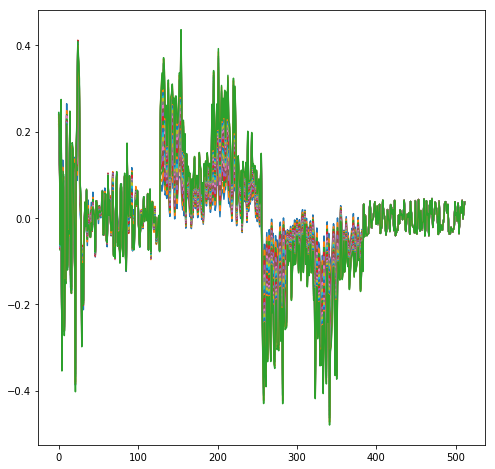

In [913]:
# change of weights in the last dense layer over epochs
plt.figure(figsize=(8,8))
for w in l20:
    plt.plot(w)
plt.show()

## Test performance on a separate test set

In [1013]:
model.eval()
pred05_test = []
for batch_idx, data in enumerate(dataloader_test):
    leading_input = Variable(data['leading_jet'].type(torch.FloatTensor))
    subleading_input = Variable(data['subleading_jet'].type(torch.FloatTensor))
    unsorted_lengths = data['unsorted_lengths'].numpy()
    weights = torch.log(data['weights_fsr05'] / 1e-1).type(torch.FloatTensor)
    
    batch_size = leading_input.shape[0]

    batch_weights = Variable(
            weights.resize_(1, batch_size),
            requires_grad=False) / torch.sum(weights) # normalized

    pred05_test.extend(F.sigmoid(
        model(leading_input, subleading_input, unsorted_lengths, batch_weights, batch_size)).data.numpy()
    )

In [1014]:
pred20_test = []
for batch_idx, data in enumerate(dataloader_test):
    leading_input = Variable(data['leading_jet'].type(torch.FloatTensor))
    subleading_input = Variable(data['subleading_jet'].type(torch.FloatTensor))
    unsorted_lengths = data['unsorted_lengths'].numpy()
    weights = torch.log(data['weights_fsr20'] / 1e-1).type(torch.FloatTensor)
    
    batch_size = leading_input.shape[0]

    batch_weights = Variable(
            weights.resize_(1, batch_size),
            requires_grad=False) / torch.sum(weights) # normalized

    pred20_test.extend(F.sigmoid(
        model(leading_input, subleading_input, unsorted_lengths, batch_weights, batch_size)).data.numpy()
    )

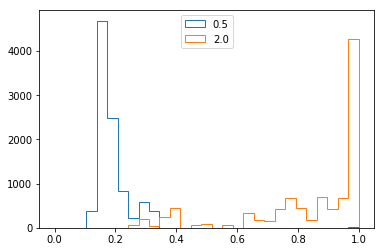

In [1015]:
_ = plt.hist([a[0] for a in pred05_test], 
             bins=np.linspace(0,1,30), histtype='step', label='0.5',
             weights=d_test[:]['weights_fsr05'])
_ = plt.hist([a[0] for a in pred20_test],
             bins=np.linspace(0,1,30), histtype='step', label='2.0',
             weights=d_test[:]['weights_fsr20'])
plt.legend(loc='upper center')

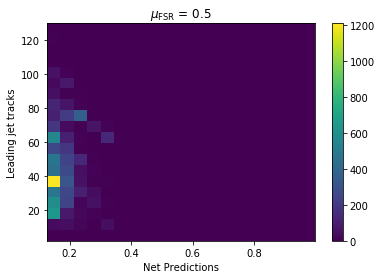

In [1118]:
_ = plt.hist2d([a[0] for a in pred05_test], d_test[:]['nparticles'][:, 0], weights=d_test[:]['weights_fsr05'][:, 0],
              bins=20)
plt.colorbar()
plt.title(r'$\mu_\mathrm{FSR}$ = 0.5')
plt.xlabel('Net Predictions')
plt.ylabel('Leading jet tracks')

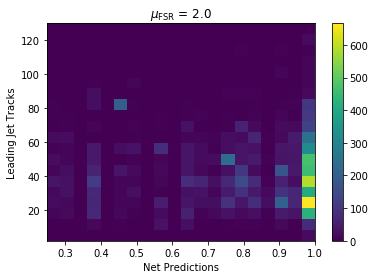

In [1119]:
_ = plt.hist2d([a[0] for a in pred20_test], d_test[:]['nparticles'][:, 0], weights=d_test[:]['weights_fsr20'][:, 0],
              bins=20)
plt.colorbar()
plt.title(r'$\mu_\mathrm{FSR}$ = 2.0')
plt.xlabel('Net Predictions')
plt.ylabel('Leading Jet Tracks')

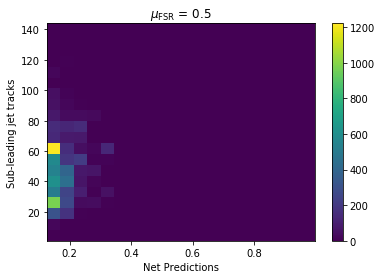

In [1120]:
_ = plt.hist2d([a[0] for a in pred05_test], d_test[:]['nparticles'][:, 1], weights=d_test[:]['weights_fsr05'][:, 0],
              bins=20)
plt.colorbar()
plt.title(r'$\mu_\mathrm{FSR}$ = 0.5')
plt.xlabel('Net Predictions')
plt.ylabel('Sub-leading jet tracks')

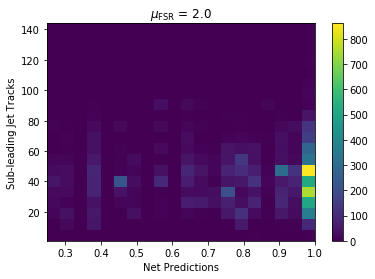

In [1121]:
_ = plt.hist2d([a[0] for a in pred20_test], d_test[:]['nparticles'][:, 1], weights=d_test[:]['weights_fsr20'][:, 0],
              bins=20)
plt.colorbar()
plt.title(r'$\mu_\mathrm{FSR}$ = 2.0')
plt.xlabel('Net Predictions')
plt.ylabel('Sub-leading Jet Tracks')

# n_tracks Classifier

In [113]:
class NTrackModel(nn.Module):

    def __init__(self, input_size):
        super(NTrackModel, self).__init__()

        self.dense = nn.Linear(input_size, 8)
        self.dropout = nn.Dropout(p=0.5)
#         self.dense0 = nn.Linear(32, 64)
#         self.dropout0 = nn.Dropout(p=0.7)
#         self.dense1 = nn.Linear(64, 64)
        self.dense1 = nn.Linear(8, 8)
        
#         self.dense2 = nn.Linear(64 * 4, 32) # 4 is from the concat below
#         self.dropout2 = nn.Dropout(p=0.7)
#         self.dense3 = nn.Linear(32, 1)
        self.dense3 = nn.Linear(8*2, 1)


    def forward(self, inputs, batch_weights, batch_size):

        hidden = F.relu(
            self.dense1(
#                 self.dropout0(
#                     F.relu(
#                         self.dense0(
                            self.dropout(
                                F.relu(
                                    self.dense(
                                        inputs)))))#)))

        batch_features = batch_weights.mm(hidden).expand(batch_size, hidden.shape[-1])
        
        weighted_mult = batch_weights.transpose(0, 1).expand(-1, hidden.shape[-1]) * hidden

#         maxpool = torch.max(weighted_mult, 0)[0].expand(batch_size, -1)
#         minpool = torch.min(weighted_mult, 0)[0].expand(batch_size, -1)
#         avgpool = torch.mean(weighted_mult, 0).expand(batch_size, -1)
        std = torch.std(weighted_mult, 0).expand(batch_size, -1)
        
        batch_features = torch.cat([batch_features, std], 1)# maxpool, minpool, avgpool], 1)
        outputs = self.dense3(
#             self.dropout2(
#                 F.relu(
#                   self.dense2(
                        batch_features)#)))
        return outputs
        

In [114]:
ntrackclassifier = NTrackModel(input_size=2)

In [115]:
ntrackclassifier

NTrackModel(
  (dense): Linear(in_features=2, out_features=8)
  (dropout): Dropout(p=0.5)
  (dense1): Linear(in_features=8, out_features=8)
  (dense3): Linear(in_features=16, out_features=1)
)

In [116]:
ntrackoptimizer = optim.SGD(ntrackclassifier.parameters(), lr=0.01)

In [123]:
def ntrack_train_on_batch(model, optimizer, epoch, batch_idx, data, name_weights):
    
    inputs = Variable(data['nparticles'].type(torch.FloatTensor), requires_grad=False) # B x 2
#     inputs = Variable(torch.ones_like(data['nparticles']), requires_grad=False)

#     weights = torch.log(data[name_weights] / 1e-1).type(torch.FloatTensor)
    weights = data[name_weights].type(torch.FloatTensor)
    
    batch_size = inputs.shape[0]

    batch_weights = Variable(
            weights.resize_(1, batch_size),
            requires_grad=False) / torch.sum(weights) # normalized

    optimizer.zero_grad()
    predictions = model(inputs, batch_weights, batch_size)

    if name_weights == 'weights_fsr20':
        targets = Variable(torch.from_numpy(np.ones((batch_size, 1))).type(torch.FloatTensor),
                          requires_grad=False)
    elif name_weights == 'weights_fsr05':
        targets = Variable(torch.from_numpy(np.zeros((batch_size, 1))).type(torch.FloatTensor),
                          requires_grad=False)
    else:
        raise ValueError
        
    loss_function = nn.BCEWithLogitsLoss() #nn.BCELoss() #weight=batch_weights)
    loss = loss_function(predictions, targets)
    loss.backward()
    optimizer.step()
    
    batch_weighted_loss = loss * batch_size # to compute per epoch loss

#     if batch_idx % 5 == 0:
#         print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#             epoch,
#             dataloader.batch_size * batch_idx + len(data['leading_jet']),
#             len(dataloader.dataset),
#             100 * (dataloader.batch_size * batch_idx + len(data['leading_jet'])) / len(dataloader.dataset),
#             loss.data[0]))
    return batch_weighted_loss, np.array(model.dense.weight.data.numpy()[0]) # for debugging purposes

In [126]:
best_loss = float('inf')
wait = 0
    
for epoch in range(100): # n_epochs
    
    # training
    ntrackclassifier.train()
    
    # initialize per-epoch losses
    ntrack_batch_weighted_loss05_epoch = 0
    ntrack_batch_weighted_loss20_epoch = 0
    
    for batch_idx, data in enumerate(dataloader):
        
        ntrack_batch_weighted_loss05_i, _ = ntrack_train_on_batch(
            ntrackclassifier, ntrackoptimizer, epoch, batch_idx, data, 'weights_fsr05'
        )
        
        ntrack_batch_weighted_loss20_i, _ = ntrack_train_on_batch(
            ntrackclassifier, ntrackoptimizer, epoch, batch_idx, data, 'weights_fsr20'
        )
        
        # accumulate per-epoch loss
        ntrack_batch_weighted_loss05_epoch += ntrack_batch_weighted_loss05_i
        ntrack_batch_weighted_loss20_epoch += ntrack_batch_weighted_loss20_i
        
    print 'Epoch {}: Loss 0.5 = {}; Loss 2.0 = {}; Total = {}'.format(
        epoch,
        ntrack_batch_weighted_loss05_epoch.data[0] / dataloader.dataset.nevents,
        ntrack_batch_weighted_loss20_epoch.data[0] / dataloader.dataset.nevents,
        (ntrack_batch_weighted_loss05_epoch.data[0] + ntrack_batch_weighted_loss20_epoch.data[0]) / (2 * dataloader.dataset.nevents)
    )
    
    # validate
    ntrackclassifier.eval()
    loss_val = 0
    
    for batch_idx_val, data_val in enumerate(dataloader_val):
    
        inputs = Variable(data_val['nparticles'].type(torch.FloatTensor), requires_grad=False) # B x 2
        
#         weights_05 = torch.log(data_val['weights_fsr05'] / 1e-1).type(torch.FloatTensor)
        weights_05 = data_val['weights_fsr05'].type(torch.FloatTensor)
#         weights_20 = torch.log(data_val['weights_fs20'] / 1e-1).type(torch.FloatTensor)
        weights_20 = data_val['weights_fsr20'].type(torch.FloatTensor)
    
        batch_size = inputs.shape[0]
        batch_weights_05 = Variable(
                weights_05.resize_(1, batch_size),
                requires_grad=False) / torch.sum(weights_05) # normalized

        #pred05_val = F.sigmoid(
        pred05_val = ntrackclassifier(inputs, batch_weights_05, batch_size)#)#.data.numpy()
        
        batch_weights_20 = Variable(
                weights_20.resize_(1, batch_size),
                requires_grad=False) / torch.sum(weights_20) # normalized

        #pred20_val = F.sigmoid(
        pred20_val = ntrackclassifier(inputs, batch_weights_20, batch_size)#)#.data.numpy()
        
        targets_05 = Variable(
            torch.from_numpy(np.zeros((batch_size, 1))).type(torch.FloatTensor),
            requires_grad=False)
        
        targets_20 = Variable(
            torch.from_numpy(np.ones((batch_size, 1))).type(torch.FloatTensor),
            requires_grad=False)
        
        loss_function = nn.BCEWithLogitsLoss() 
        loss_val += batch_size * (loss_function(pred05_val, targets_05) + loss_function(pred20_val, targets_20)) / 2.
        
    loss_val /= dataloader_val.dataset.nevents #(batch_idx_val + 1)
    loss_val = float(loss_val)
    print 'Validation loss = {:0.5f}'.format(loss_val)
    # early stopping
    patience = 100
    if loss_val < best_loss:
        print 'Validation loss improved from {:0.5f} to {:0.5f}'.format(best_loss, loss_val)
        best_loss = loss_val
        wait = 0
        print 'Saving checkpoint at ./checkpoint_ntrack.pth'
        torch.save(ntrackclassifier.state_dict(), 'checkpoint_ntrack.pth')

    else:
        wait += 1
        if wait >= patience - 1:
            print 'Stopping early.'
            break
    
print 'Restoring best weights from chedataloader_val.dataset.neventsckpoint at ./checkpoint_ntrack.pth'
ntrackclassifier.load_state_dict(torch.load('checkpoint_ntrack.pth'))

# plt.plot(last_layer_weights05, color='blue', alpha=1 - 1./(1+epoch), label='0.5 - epoch: {}'.format(epoch))
# plt.plot(last_layer_weights20, color='orange', alpha=1 - 1./(1+epoch), label='2.0 - epoch: {}'.format(epoch))

# plt.legend()
# plt.show()

Epoch 0: Loss 0.5 = 0.692036827287; Loss 2.0 = 0.702706429117; Total = 0.697371628202
Validation loss = 0.69365
Validation loss improved from inf to 0.69365
Saving checkpoint at ./checkpoint_ntrack.pth
Epoch 1: Loss 0.5 = 0.681808295725; Loss 2.0 = 0.709359707735; Total = 0.69558400173
Validation loss = 0.69323
Validation loss improved from 0.69365 to 0.69323
Saving checkpoint at ./checkpoint_ntrack.pth
Epoch 2: Loss 0.5 = 0.686693863485; Loss 2.0 = 0.705394831288; Total = 0.696044347386
Validation loss = 0.69297
Validation loss improved from 0.69323 to 0.69297
Saving checkpoint at ./checkpoint_ntrack.pth
Epoch 3: Loss 0.5 = 0.688119419055; Loss 2.0 = 0.703822206564; Total = 0.69597081281
Validation loss = 0.69376
Epoch 4: Loss 0.5 = 0.68733623923; Loss 2.0 = 0.702128579049; Total = 0.694732409139
Validation loss = 0.69431
Epoch 5: Loss 0.5 = 0.6904429379; Loss 2.0 = 0.701488123983; Total = 0.695965530942
Validation loss = 0.69385
Epoch 6: Loss 0.5 = 0.69281081529; Loss 2.0 = 0.6988402

In [132]:
a = Variable(torch.randn(10,1))

In [5]:
l = [np.array(2), np.array(2.3)]

In [11]:
os.path.exists?

In [208]:
ntrackclassifier.eval()
pred05_test = []
pred20_test = []
for batch_idx, data in enumerate(dataloader_test):
        inputs = Variable(data['nparticles'].type(torch.FloatTensor), requires_grad=False) # B x 2
        
        weights_05 = data['weights_fsr05'].type(torch.FloatTensor)
        weights_20 = data['weights_fs20'].type(torch.FloatTensor)
        batch_size = inputs.shape[0]
        batch_weights_05 = Variable(
                weights_05.resize_(1, batch_size),
                requires_grad=False) / torch.sum(weights_05) # normalized

        pred05_test.extend(F.sigmoid(
            ntrackclassifier(inputs, batch_weights_05, batch_size)).data.numpy())
        
        batch_weights_20 = Variable(
                weights_20.resize_(1, batch_size),
                requires_grad=False) / torch.sum(weights_20) # normalized

        pred20_test.extend(F.sigmoid(
            ntrackclassifier(inputs, batch_weights_20, batch_size)).data.numpy())
   

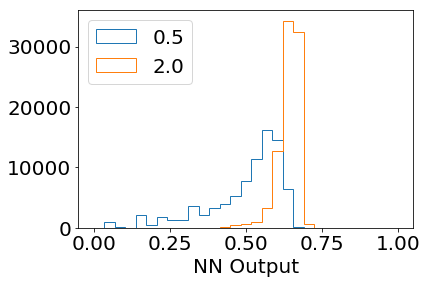

In [214]:
_ = plt.hist([a[0] for a in pred05_test], 
             bins=np.linspace(0,1,30), histtype='step', label='0.5',
             weights=d_test[:]['weights_fsr05'])
_ = plt.hist([a[0] for a in pred20_test],
             bins=np.linspace(0,1,30), histtype='step', label='2.0',
             weights=d_test[:]['weights_fs20'])
plt.legend(loc='upper left')
plt.xlabel('NN Output')

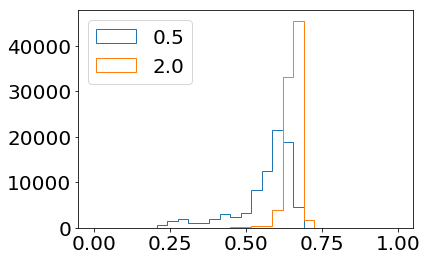

In [206]:
_ = plt.hist([a[0] for a in pred05_test], 
             bins=np.linspace(0,1,30), histtype='step', label='0.5',
             weights=d_test[:]['weights_fsr05'])
_ = plt.hist([a[0] for a in pred20_test],
             bins=np.linspace(0,1,30), histtype='step', label='2.0',
             weights=d_test[:]['weights_fs20'])
plt.legend(loc='upper left')


In [178]:
def weighted_std(x, w):
    w = w / w.sum()
    return np.mean(np.power(x, 2) * w) - np.mean(x * w) ** 2

In [189]:
std05_test = []
std20_test = []

for batch_idx, data in enumerate(dataloader_test):
        feature = data['nparticles'].numpy()[:, 0].ravel()
        
#         weights_05 = torch.log(data['weights_fsr05'] / 1e-1).type(torch.FloatTensor)
#         weights_20 = torch.log(data['weights_fs20'] / 1e-1).type(torch.FloatTensor)
        
        weights_05 = data['weights_fsr05']
        weights_20 = data['weights_fs20']
        
        batch_weights_05 = (weights_05 / torch.sum(weights_05)).numpy().ravel() # normalized
        batch_weights_20 = (weights_20 / torch.sum(weights_20)).numpy().ravel() # normalized
        
        std05_test.append(weighted_std(feature, batch_weights_05))
        std20_test.append(weighted_std(feature, batch_weights_20))
      
   

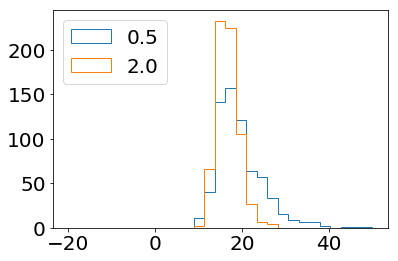

In [190]:
_ = plt.hist(std05_test, 
             bins=np.linspace(-20,50,30), histtype='step', label='0.5')
_ = plt.hist(std20_test,
             bins=np.linspace(-20,50,30), histtype='step', label='2.0')
plt.legend(loc='upper left')

In [186]:
np.log(d[:]['weights_fsr05'] / 1e-1)

array([[ 3.13010962],
       [ 1.50123392],
       [-2.71925804],
       ..., 
       [ 1.70290498],
       [ 1.15642624],
       [ 1.99171299]])

# Save model to ONNX

In [980]:
import torch.onnx

torch.onnx.export(model,
                  (leading_input, subleading_input, unsorted_lengths, batch_weights, batch_size),
                  f='batchlevel.proto', verbose=True)

ValueError: NestedIOFunction doesn't know how to process an input object of type ndarray

In [53]:
from graphviz import Digraph


def make_dot(var, params):
    """ Produces Graphviz representation of PyTorch autograd graph
    
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    param_map = {id(v): k for k, v in params.items()}
    print(param_map)
    
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="50,50"))
    print dot
    seen = set()
    
    def size_to_str(size):
        return '('+(', ').join(['%d'% v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                node_name = '%s\n %s' % (param_map.get(id(u)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

In [57]:
# g = make_dot(predictions, model.state_dict())
# g.view()

{4536365568: 'minibatch_tensor', 4536050752: 'lstm_lead.bias_hh_l0', 4498255744: 'lstm_lead.weight_ih_l0_reverse', 4536366504: 'lstm_sublead.bias_ih_l0_reverse', 4536365784: 'lstm_sublead.bias_hh_l0_reverse', 4535702088: 'lstm_lead.bias_ih_l0_reverse', 4535703744: 'lstm_lead.weight_hh_l0_reverse', 4536006704: 'lstm_lead.weight_ih_l0', 4535705400: 'lstm_lead.bias_hh_l0_reverse', 4536365424: 'lstm_sublead.weight_hh_l0_reverse', 4536366432: 'lstm_sublead.weight_ih_l0_reverse', 4536366360: 'lstm_sublead.bias_hh_l0', 4536368088: 'dense.bias', 4536050680: 'lstm_lead.weight_hh_l0', 4536368232: 'lstm_sublead.weight_hh_l0', 4536366720: 'lstm_sublead.bias_ih_l0', 4536367296: 'dense.weight', 4536368376: 'lstm_sublead.weight_ih_l0', 4536051472: 'lstm_lead.bias_ih_l0'}
digraph {
	graph [size="50,50"]
	node [align=left fontsize=12 height=0.2 ranksep=0.1 shape=box style=filled]
}


'Digraph.gv.pdf'

In [2]:
import torch
from torch.autograd import Variable

In [3]:
lstm_lead_out = Variable(torch.randn(5,4,3))

In [10]:
lstm_lead_out

Variable containing:
(0 ,.,.) = 
 -1.9911 -0.6975 -1.5085
  0.6566  1.1785 -0.6876
 -0.0233 -0.4049  0.9515
 -0.5320 -0.7691 -0.0303

(1 ,.,.) = 
  0.3560 -0.0248 -1.0481
 -0.1625  1.3988  1.0108
 -0.5581 -1.1452  0.0961
 -1.2297  0.2413  1.3721

(2 ,.,.) = 
  0.4523  0.5078  0.5826
  0.3873 -1.6772  0.5573
 -1.3768  0.4218  0.8475
 -1.0517  1.5502 -0.2210

(3 ,.,.) = 
  1.5320  0.1882 -2.0807
 -0.6262  0.3263  0.4963
 -1.3430  1.7433  1.7888
 -0.7897  0.0830 -0.1168

(4 ,.,.) = 
  1.0058 -0.6098 -0.6379
 -2.0382 -2.5222  0.4968
 -2.2521 -0.1084 -1.5427
 -0.6780 -0.4066 -0.5285
[torch.FloatTensor of size 5x4x3]

In [24]:
lead_len = torch.Tensor([0,1,3,3,2]).type(torch.LongTensor)
idx_lead = Variable(
            lead_len, requires_grad=False).view(-1, 1).expand(lstm_lead_out.size(0), lstm_lead_out.size(2)).unsqueeze(1)


In [25]:
lead_len


 0
 1
 3
 3
 2
[torch.LongTensor of size 5]

In [26]:
idx_lead

Variable containing:
(0 ,.,.) = 
  0  0  0

(1 ,.,.) = 
  1  1  1

(2 ,.,.) = 
  3  3  3

(3 ,.,.) = 
  3  3  3

(4 ,.,.) = 
  2  2  2
[torch.LongTensor of size 5x1x3]

In [27]:
lstm_lead_out.gather(1, idx_lead).squeeze()

Variable containing:
-1.9911 -0.6975 -1.5085
-0.1625  1.3988  1.0108
-1.0517  1.5502 -0.2210
-0.7897  0.0830 -0.1168
-2.2521 -0.1084 -1.5427
[torch.FloatTensor of size 5x3]

In [ ]:
model

# ROC AUC Plot

In [2]:
import yaml
import numpy as np
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [3]:
%matplotlib inline

In [4]:
from uncertainties import unumpy

In [14]:
results_ntrk = {
    0.5 : unumpy.uarray([0.961223989171, 0.96759797453, 0.949566167969, 0.96600771187, 0.990767015772, 0.994133624655, 0.971380319233, 0.972918183795, 0.995044044406, 0.978615436496],
                        [0.00161405209204, 0.00168981323315, 0.00142954481077, 0.00132663828728, 0.000686171300686, 0.000390360556129, 0.00130620430936, 0.000735940788252, 0.000509942497646, 0.00146836232343]),
    
    0.6 : unumpy.uarray([0.909300357437, 0.938476859806, 0.964986322277, 0.961666117072, 0.784156912519, 0.968060299472, 0.970282645241, 0.81184677135, 0.78161308953, 0.969873618564],
                        [0.00190503789498, 0.000742030034665, 0.00137656770268, 0.00112320734904, 0.00151553240508, 0.00140631976747, 0.00133660630311, 0.00203375114214, 0.00156880582362, 0.000797550102549]),
    
    0.7 : unumpy.uarray([0.904496920656, 0.636813985924, 0.853266621619, 0.857216491375, 0.841361263446, 0.851184520958, 0.647169506689, 0.907115789501, 0.901321997282, 0.904671118503],
                        [0.00162432039452, 0.00131287692407, 0.00201915707237, 0.00166300005889, 0.00186319725651, 0.00304512517687, 0.00210327525015, 0.00252593297562, 0.00203151330951, 0.00208082023499]),

    0.8 : unumpy.uarray([0.534645067264, 0.412930366779, 0.5, 0.740116416605, 0.740516607121, 0.731545695768, 0.529311145462, 0.5, 0.727178809919, 0.735481578132],
                        [0.00216191155178, 0.00380759541736, 0.0, 0.00196012375647, 0.00170529505476, 0.00179184055554, 0.000944727063138, 0.0, 0.00229936879262, 0.00139046207857]),
    
    0.9 : unumpy.uarray([0.558088276686, 0.514098339575, 0.5, 0.5, 0.572556000631, 0.532983843592, 0.560933702918, 0.55052401578, 0.534900624212, 0.555300522785],
                        [0.00174179125506, 0.00159770482876, 0.0, 0.0, 0.00196797519927, 0.00145823091592, 0.00156540119728, 0.00114060729415, 0.00173137123704, 0.00154990127406]),

    0.95 : unumpy.uarray([0.41491546185, 0.485189698197, 0.498507423486, 0.48037361721, 0.458123514307, 0.465471782204, 0.496111603617, 0.497579448166, 0.498425086253, 0.469842186403],
                         [0.000589604483983, 5.96636434071e-05, 1.49830475338e-05, 0.000141901405495, 0.00174583164684, 0.00157435812067, 3.36965173636e-05, 9.02749214936e-05, 0.00215357666447, 0.00153255517949]),
    
    0.98 : unumpy.uarray([0.535608764087, 0.48689816126, 0.49504700537, 0.476864640353, 0.5, 0.465805567789, 0.506211106077, 0.490198783494, 0.481986721568, 0.432785195342],
                         [0.000146587049437, 3.48525392697e-05, 1.99855885445e-05, 9.50502899788e-05, 0.0, 0.00017408487506, 0.000162328630832, 3.3250572244e-05, 0.000126793964282, 0.000412691880534 ]),
    
    0.99 : unumpy.uarray([0.48847431566, 0.496479831251, 0.495780550539, 0.499003074106, 0.51777078605, 0.497589085549, 0.402808774433, 0.506515866054, 0.531991221963, 0.501026992352],
            [3.57038662927e-05, 3.51638061403e-05, 0.000151665108235, 1.37193005431e-05, 9.55519504601e-05, 0.000216622969992, 0.00124832559661, 0.000171628717629, 0.00063313410868, 7.49317488764e-05]),
    
    1.0 : unumpy.uarray([0.502290208536, 0.499944838256, 0.485921338257, 0.499739602933, 0.492207179694, 0.53377764217, 0.501919299157, 0.493979093049, 0.493429969187, 0.487734361741],
           [1.68108666431e-05, 2.66175758115e-05, 0.00108879001182, 2.90918392543e-05, 0.00176622654192, 0.000659948562901, 2.43848977154e-05, 0.000864225013425, 0.001326274661, 0.00107553607791]),
    
    1.02 : unumpy.uarray([0.503564765922, 0.490205878114, 0.496557633476, 0.490334033683, 0.495341641311, 0.489172030724, 0.492262051919, 0.515627875259, 0.503730839572, 0.49061507332],
            [0.00126335957294, 0.0021355634545, 0.00182560763257, 0.00139639124202, 0.00222591867985, 0.000701290576131, 0.00108832413461, 0.00154112480857, 0.00112146962837, 0.000967253650269]),
    
    1.05 : unumpy.uarray([0.5, 0.528736394979, 0.497999313442, 0.53778188481, 0.531453417263, 0.495523039442, 0.499915159082, 0.589189877132, 0.500308352717, 0.5],
                         [0.0, 0.00172526778083, 3.10159387069e-05, 0.000268934117554, 0.00026593554454, 0.0014752081947, 6.42497170878e-05, 0.00120427785245, 0.000325529185574, 0.0 ]),
    
    1.1 : unumpy.uarray([0.473923879653, 0.5, 0.539938352621, 0.483629177772, 0.473141444823, 0.558797866222, 0.505875441604, 0.484427946597, 0.440600851502, 0.449664997862],
                        [0.000682839946193, 0.0, 0.0010101405285, 0.000380085902215, 0.00082719993056, 0.000985915677517, 0.000100109736766, 0.000893359791427, 0.0011316222808, 0.00161620289186]),

    1.2 : unumpy.uarray([0.5, 0.589146474354, 0.55728176718, 0.594765414243, 0.52764961092, 0.55390369391, 0.534481847477, 0.548483276992, 0.575598503465, 0.550251482747],
                        [0.0, 0.00179416144374, 0.00220293639372, 0.00164138135864, 0.000845853262891, 0.000992158718252, 0.00158675947572, 0.00119826892383, 0.00108669543776, 0.00152447819067]),
    
    1.3 : unumpy.uarray([0.697574557462, 0.756257271048, 0.626084175456, 0.679247095156, 0.629031492408, 0.639791146156, 0.696735680138, 0.646141625784, 0.541182528338, 0.692379299187],
                        [0.00155487142917, 0.00142920990794, 0.00154153467217, 0.00122575302941, 0.00152749726623, 0.00217283281474, 0.00183073854203, 0.00255607338912, 0.0019741704979, 0.00152512799417]),

    1.4 : unumpy.uarray([0.783109145453, 0.782185664322, 0.765811361655, 0.624058395957, 0.787516314121, 0.791450467278, 0.693899924771, 0.700303327819, 0.813140783079, 0.5 ],
                        [0.00193701745533, 0.00200082540563, 0.00202386121629, 0.00150035994655, 0.00179255007077, 0.00246627980582, 0.00183460892304, 0.0012152468397, 0.00230302700963, 0.0]),
    
    1.5 : unumpy.uarray([0.694610058796, 0.734757215608, 0.725521607126, 0.814952806251, 0.753582844643, 0.67516259261, 0.69499306584, 0.720353893507, 0.661836310625, 0.676563661306],
                        [0.00150280511558, 0.00130871136946, 0.00176650698848, 0.00285355182198, 0.00214696130904, 0.00157033593734, 0.0013857027371, 0.00117767840877, 0.00123413032336, 0.00258310802832]),

    1.7 : unumpy.uarray([0.855400191212, 0.857292053914, 0.685436380115, 0.821098116896, 0.712836120245, 0.836958336839, 0.836554804819, 0.752018372098, 0.8275058556, 0.5],
                        [0.00155699861524, 0.00256113370354, 0.00094283932354, 0.00170978247527, 0.00220001242574, 0.00256854618997, 0.00219553721688, 0.00179882450173, 0.000884154117999, 0.0]),

    1.9 : unumpy.uarray([0.736798147833, 0.779881524453, 0.847876986974, 0.871413660888, 0.929633880162, 0.931806535801, 0.930905857372, 0.886387497732, 0.876496305145, 0.909394155979],
                        [0.00205148603848, 0.00214898071934, 0.00187660412919, 0.00200010868118, 0.0019536821588, 0.00109370362307, 0.00150210441949, 0.00182599553152, 0.00225714491761, 0.00103108460564]),

    2.0 : unumpy.uarray([0.842498253859, 0.839951285771, 0.821726768791, 0.806256578725, 0.802071887293, 0.902488732208, 0.813323610415, 0.81631909043, 0.846874582763, 0.90270318771],
                        [0.00252875695994, 0.00197544219148, 0.00197186711651, 0.00129324578158, 0.00183346091006, 0.00234558547724, 0.00158591172322, 0.00204961595251, 0.00189454519236, 0.00181165785347])
}

In [15]:
d = {
    0.5 : unumpy.uarray([0.965379048876, 0.994008515578, 0.994172159594, 0.867380216286, 0.86572943769, 0.986836798916, 0.867346663944, 0.964117401878, 0.867590461654, 0.99376784996], [0.00173263614004, 0.000611284086367, 0.000445869593156, 0.00190725592578, 0.00122188166968, 0.000727773858382, 0.00211081728087, 0.00173047006554, 0.00149097590011, 0.000676619114154]),

    0.7 : unumpy.uarray([0.866371816433, 0.900838529784, 0.834995760102, 0.910803985322, 0.8986845628, 0.890198094112, 0.917986936959, 0.9014647934, 0.885996447781, 0.833131633842], [0.00149444416361, 0.00200416036926, 0.00157026162814, 0.00180843880213, 0.00236528008272, 0.00220013471711, 0.00141540805084, 0.00174731162373, 0.00135202861793, 0.00211807787861]),

    0.9 : unumpy.uarray([0.551940925109, 0.586765082066, 0.562076738279, 0.578619178771, 0.558245559402, 0.528710212787, 0.539827384482, 0.537729048908, 0.546738983891, 0.54165838852], [0.00177062637725, 0.00115837118136, 0.00138827565206, 0.000981491257323, 0.00189804189172, 0.00136875886974, 0.00140523238502, 0.00225433709255, 0.00137985392732, 0.0011057491291]),

    1.1 : unumpy.uarray([0.459314516762, 0.470916629754, 0.486747255044, 0.513706085205, 0.54983792681, 0.527433327407, 0.488847864398, 0.469523602127, 0.479509172078, 0.454802955366], [0.000374791964849, 0.000588355113435, 0.00118008147097, 0.000453428486191, 0.00120354004353, 0.000518595939213, 0.00034976448876, 0.000701761457035, 0.000824030619035, 0.000765251293776]),

    1.3 : unumpy.uarray([0.697438461405, 0.691590808545, 0.701383342524, 0.699863723148, 0.549001009286, 0.693224101486, 0.681183343919, 0.681476592083, 0.624722694299, 0.719500455677], [0.00207432316897, 0.00110181089227, 0.00197783327024, 0.00193687768511, 0.00219826122034, 0.00197690098318, 0.00144253825524, 0.00127165256076, 0.00176489565268, 0.00163774798013]),

    1.5 : unumpy.uarray([0.672951514513, 0.719511449186, 0.752575897385, 0.652614847989, 0.718813319254, 0.710418404808, 0.679131426468, 0.688323334287, 0.684097729633, 0.719144741039],[0.00107639114678, 0.00245625633498, 0.0012618341579, 0.00127369564098, 0.00256284579545, 0.00189921281811, 0.00142741108617, 0.00247629338863, 0.0016102386815, 0.00253607642424]),

    1.7 : unumpy.uarray([0.819110858042, 0.682078170275, 0.703152942424, 0.706364949285, 0.670392383828, 0.740237476188, 0.688873325347, 0.84946135669, 0.845485434695, 0.692844807473], [0.00155991371474, 0.00178015832001, 0.00225109431906, 0.00150559509496, 0.00171115489232, 0.00249461256017, 0.00182029025538, 0.00212909374239, 0.00214719949602, 0.00172692008355]),

    1.9 : unumpy.uarray([0.801316663499, 0.78193428877, 0.941855312758, 0.931469656816, 0.854549755637, 0.879315413351, 0.5, 0.866655322323, 0.961354495305, 0.881170501869] , [0.00102166930849, 0.00192404859359, 0.00159019815984, 0.00151300183243, 0.0011731334119, 0.00163332099905, 0.0, 0.00219175196308, 0.00114617943921, 0.00242090844194]),

    2.0 : unumpy.uarray([0.904415202499, 0.908556303316, 0.7620585131, 0.829947961059, 0.913212642781, 0.828671343513, 0.865903371448, 0.850584296958, 0.820014205443, 0.829282566924], [0.00238479150678, 0.00256297549652, 0.00204928669972, 0.00297289229247, 0.00158912946102, 0.00186575307386, 0.00157067698747, 0.00126936177364, 0.00161938837493, 0.00195986797631])
}
for i in results_ntrk:
    if i in d:
        results_ntrk[i] = np.concatenate((results_ntrk[i], d[i]))

In [16]:
sorted([(i, len(l)) for i,l in results_ntrk.iteritems()])

[(0.5, 20),
 (0.6, 10),
 (0.7, 20),
 (0.8, 10),
 (0.9, 20),
 (0.95, 10),
 (0.98, 10),
 (0.99, 10),
 (1.0, 10),
 (1.02, 10),
 (1.05, 10),
 (1.1, 20),
 (1.2, 10),
 (1.3, 20),
 (1.4, 10),
 (1.5, 20),
 (1.7, 20),
 (1.9, 20),
 (2.0, 20)]

In [268]:
results_rnn = {
    0.5 : unumpy.uarray([0.983286779928, 0.975312963014, 0.985464787284, 0.970768676329, 0.984254361136, 0.983259889068, 0.940374310156, 0.960777473228, 0.973287814205, 0.978636097634,
                        0.987846304964, 0.942191376059, 0.976795494755, 0.992686926592, 0.983758215346, 0.945201095706, 0.979253323201, 0.966562774331, 0.981107041379, 0.978649067547],
                        [0.000754830971562, 0.00102940180533, 0.000743056473498, 0.00145746671821, 0.00071329453266, 0.000997496101563, 0.00195845040148, 0.00167027052202, 0.00103075697274, 0.000721191528769,
                        0.00068668541393, 0.00202968406926, 0.000864173720534, 0.000693289578914, 0.00107706981162, 0.00138475234092, 0.000942928261006, 0.00114649745229, 0.000902460564669, 0.000967841162171]),

    0.6 : unumpy.uarray([0.912550429214, 0.931196329207, 0.923949489345, 0.93836688971, 0.928821888807, 0.922450869538, 0.949930348515, 0.923968034838, 0.948100239776, 0.951411260908],
                        [0.00137740723288, 0.00109668358799, 0.00187098840135, 0.00160768420083, 0.0017607081682, 0.00165766150712, 0.00120329690553, 0.00252015446934, 0.00157747485079, 0.00152078362402]),
    
    0.7 : unumpy.uarray([0.836039067941, 0.706053360674, 0.798183225377, 0.785079923618, 0.776828513675, 0.828222493641, 0.754524473081, 0.868068268997, 0.799355228227, 0.756704350511,
                        0.743445445345, 0.790910823501, 0.821320817145, 0.810805359472, 0.815200198877, 0.815267894302, 0.801426798066, 0.719798852575, 0.79146896467, 0.852458385541], 
                        [0.00200261496175, 0.00300778175963, 0.00173671882758, 0.00196286698811, 0.00197474064548, 0.00315383174377, 0.00214238491792, 0.00291611854878, 0.00216016603047, 0.00182828321372,
                        0.00267472037497, 0.000989552706638, 0.00138744248528, 0.00181712878531, 0.0033026738083, 0.0015475993063, 0.000933335780635, 0.00287919554162, 0.00309204348588, 0.00281837082366]),

    0.8 : unumpy.uarray([0.690313908283, 0.727811513845, 0.597208577858, 0.714853385065, 0.574450711407, 0.643253753004, 0.654675287187, 0.649206040297, 0.698512221635, 0.660474263974],
                        [0.00155618837051, 0.00191353244816, 0.00147277556781, 0.00217061196215, 0.00119331546188, 0.00144161404719, 0.00190874980187, 0.00168067411181, 0.0012321275433, 0.00199104806643]),
    
    0.9 : unumpy.uarray([0.479417089678, 0.564902360651, 0.543181387709, 0.508151175269, 0.56646914991, 0.492466514185, 0.511942418909, 0.514201663042, 0.485895385127, 0.549449527543,
                        0.492611583001, 0.488570477249, 0.481736006313, 0.548180078239, 0.489174944607, 0.516672297907, 0.534044132053, 0.555747509993, 0.524607658108, 0.495578767821], 
                        [0.000131564141331, 0.00211901262337, 0.00171294545004, 0.000724501729843, 0.00153942954043, 3.92243734182e-05, 0.000830389926063, 0.00140792128319, 0.00102847409167, 0.00215403286329,
                        0.00106813341569, 6.35575211358e-05, 8.17995656465e-05, 0.00128076616089, 0.00092080033334, 0.000367050182194, 0.00156577735586, 0.00176131903176, 0.00145807647583, 5.01830732784e-05]),

    0.95 : unumpy.uarray([0.492824454185, 0.496853258107, 0.511096638274, 0.49136464465, 0.482182962327, 0.487571093437, 0.491341578742, 0.48183490056, 0.496105062492, 0.496553258242],
                         [9.18143009231e-05, 5.98367547376e-05, 6.04761178969e-05, 0.0013769807531, 8.71362766882e-05, 4.46614681925e-05, 5.37838999583e-05, 0.000193989026321, 2.95581325999e-05, 9.42188868827e-05]),
    
    0.98 : unumpy.uarray([0.475818671979, 0.427110770717, 0.410769112307, 0.393205784008, 0.486469131869, 0.483706402508, 0.469673038115, 0.427518472603, 0.462067138661, 0.48214696274],
                         [0.00186321028589, 0.00137571358409, 0.000644057709746, 0.000600005848646, 0.00175254016354, 6.77098728968e-05, 0.00116360327367, 0.00110450562962, 0.00120020617041, 0.00154156236883]),
    
    0.99 : unumpy.uarray([0.477225289173, 0.476057724452, 0.477785564293, 0.474915446941, 0.458172806155, 0.475254535717, 0.448879512332, 0.461601991889, 0.460069252535, 0.48528132983],
                         [4.35236694791e-05, 5.43248443487e-05, 8.17632051424e-05, 5.87327525894e-05, 0.000109570080695, 7.31994049346e-05, 0.000172030137967, 0.000125795064401, 0.000117398234838, 5.32250277256e-05]),
    
    1.0 : unumpy.uarray([0.547533849483, 0.568008916556, 0.55026299331, 0.510186806833, 0.579431442065, 0.516673997431, 0.573959580313, 0.583592542049, 0.49879214802, 0.49338440243],
                        [0.000779059848929, 0.00199837071594, 0.00155830094942, 5.76147553761e-05, 0.00203334693786, 0.00131901282793, 0.00158015921613, 0.00160296728704, 4.92212718731e-05, 3.81574937047e-05]),
    
    1.02 : unumpy.uarray([0.375819003944, 0.449773455588, 0.450686352371, 0.361897535121, 0.434579751965, 0.416833916066, 0.473145203056, 0.455974622439, 0.462252505122, 0.438908204483],
                         [0.00121579116142, 0.00129916444222, 0.00185524500456, 0.00176324883953, 0.00155889196546, 0.00194991980518, 0.000229824922793, 0.00116075098751, 0.000159876620937, 0.00246888318166]),
    
    1.05 : unumpy.uarray([0.479894594405, 0.505930269513, 0.488172028906, 0.416543370899, 0.49699003035, 0.494690809049, 0.476513345347, 0.457492474013, 0.493256872728, 0.492978765193],
                         [0.00165487577703, 0.000998581484947, 0.000548473933539, 0.00201374243898, 0.00156353935309, 0.00129122447273, 0.00128936843933, 0.00150602704033, 7.53566013923e-05, 7.69850704605e-05]),
    
    1.1 : unumpy.uarray([0.461403390606, 0.471805091069, 0.483903115017, 0.461811942425, 0.473346797675, 0.457954985453, 0.48374936423, 0.493921298162, 0.458275504297, 0.464036943543,
                        0.484341569401, 0.47299506679, 0.461047340713, 0.465748535817, 0.471099564772, 0.483694126298, 0.482990731697, 0.480045220379, 0.481597559157, 0.485842797816], 
                        [8.63541987768e-05, 7.51211403199e-05, 4.98203722961e-05, 0.000130611643993, 7.56035570618e-05, 0.000111682288614, 3.7161702512e-05, 8.07568427068e-05, 9.54365992668e-05, 7.83240861106e-05,
                        0.000107642274272, 9.39995559768e-05, 0.000103316446067, 7.39142578793e-05, 4.63102931871e-05, 5.73042726035e-05, 5.84383539726e-05, 6.86153326751e-05, 8.36308053491e-05, 8.37844477793e-05]) ,

    1.2 : unumpy.uarray([0.558113118582, 0.536836358576, 0.511693407159, 0.559389779566, 0.55519574842, 0.613237869549, 0.543257102499, 0.553165388832, 0.544903880165, 0.573722998324 ],
                        [0.0013420221992, 0.00186638569999, 0.00165805537571, 0.0011276187052, 0.000705678037846, 0.00227600266313, 0.0012946011536, 0.000827726182282, 0.00148479731178, 0.0019000335133]),
    
    1.3 : unumpy.uarray([#0.587635144128, 0.648148759749, 0.586699213963, 0.570526266824, 0.551127743427, 0.549475592224, 0.613917321777, 0.700183825962, 0.548741919769, 0.642917626272,
                        #0.574481093136, 0.543528542971, 0.556867179515, 0.486060747164, 0.576031823558, 0.589429103001, 0.518958410836, 0.572145631058, 0.570637961206, 0.614188963927,
                        # beefier (meave)
                        0.625719072759, 0.618987843577, 0.621288383338, 0.625996018041, 0.625119750154, 0.590356340593 , 0.627841425525, 0.616592579826, 0.635776627107, 0.625414791356
                        ],
                         [#0.00149502378695, 0.00115783871427, 0.00185849434968, 0.00116449267788, 0.00160720232001, 0.00158222417485, 0.00155746028222, 0.00160277908011, 0.000981233417307, 0.00255498777245,
                        #0.00243322063213, 0.00147907538918, 0.00174753509302, 0.00137274887686, 0.00158993691461, 0.00152109938108, 0.0015880866465, 0.00150944221777, 0.00111275736071, 0.00149274088611,
                        # beefier (maeve)
                          0.00202374367405, 0.000789433969905, 0.00185648951036, 0.000961610411159, 0.00154695122273, 0.00140557053755, 0.00140425103179, 0.00144822898496, 0.000716821396389, 0.00190073062156
                         ]),
    
    1.4 : unumpy.uarray([#0.640096425371,0.639163189208,0.646905992068,0.657861066243,0.581602864338,0.629449621266,0.633181951366,0.66956278241,0.633626746472,0.633239897235,
                        # beefier (maeve)
                          0.676924081644, 0.699374617328, 0.644497671385, 0.695368246309, 0.648083641434, 0.695311202438, 0.69509280347, 0.695731776962, 0.679707932403, 0.692109692504 
                        ],
                         [#0.00141684761251, 0.00173493889138, 0.00177648292427, 0.00158978386982, 0.00133898902586, 0.00153356327934, 0.00149586554392, 0.00141524086549, 0.00141549509762, 0.00137573000786,
                        # beefier (maeve)
                            0.00194663259314, 0.00142828377989, 0.0016284781049, 0.00268953400091, 0.00187189989541, 0.00179993544939, 0.0013307511888, 0.00236434485853, 0.00143423355312, 0.00191841677861
                         ]),
                          
    1.5 : unumpy.uarray([0.70323624016, 0.777979578831, 0.69408106216, 0.684300232954, 0.619305024615, 0.676537183223, 0.730890119664, 0.66818017523, 0.656915871278, 0.656253940515,
                        0.714293770829, 0.694909004761, 0.637694607361, 0.686071009732, 0.710094728939, 0.639372927623, 0.718414450935, 0.680356390243, 0.704643750608, 0.660316005995], 
                        [0.00204700281597, 0.00248562208396, 0.00168528272401, 0.00234906471517, 0.00208314546838, 0.0017469779641, 0.0018267741167, 0.00217059443679, 0.00172812356647, 0.00116902523876,
                        0.00183538332371, 0.00176541225724, 0.00209848939549, 0.00112647650167, 0.00157390751902, 0.00146789882595, 0.00139664228003, 0.00217275292623, 0.00182177174632, 0.00201726451817]),

    1.7 : unumpy.uarray([0.786673188753, 0.837267282885, 0.837489740088, 0.743256270291, 0.803373474718, 0.715323267393, 0.85082515836, 0.731172382865, 0.734476061681, 0.78034865023,
                        0.748659811148, 0.852381558887, 0.780597065373, 0.703581655368, 0.794092587432, 0.777907322294, 0.732772996991, 0.764816340201, 0.816250080833, 0.859971867166],
                        [0.00180183313816, 0.00230159246586, 0.00141298780321, 0.00200650038725, 0.00131302000092, 0.00133575215756, 0.00182408386998, 0.00138457636412, 0.0019350754694, 0.00170251738509,
                        0.00232466964804, 0.00161987462623, 0.00146918781158, 0.00117176913495, 0.00252846491846, 0.0019699956593, 0.00239033692354, 0.0015444628127, 0.00184543207666, 0.00122083775464]),

    1.9 : unumpy.uarray([0.863584505005, 0.92590579022, 0.925810689872, 0.908795975656, 0.87615409791, 0.887865226543, 0.856085981073, 0.844699263597, 0.916585047681, 0.912565311127,
                        0.886681341429, 0.827451985274, 0.861822267639, 0.927032038048, 0.901437658617, 0.879585816575, 0.864949540268, 0.859036709207, 0.829508421991, 0.910268076657],
                        [0.00125530701659, 0.00168635798701, 0.00243716820781, 0.00164931449928, 0.00234263958362, 0.0010014528484, 0.00249289336403, 0.00257812620638, 0.00251394311575, 0.00207513431911,
                        0.0024426240591, 0.00237286544365, 0.00183313849201, 0.00183169445602, 0.00178315515269, 0.00177282788834, 0.00181704761974, 0.00255918299699, 0.00205024112274, 0.00264797119996]),

    2.0 : unumpy.uarray([0.890701050065, 0.805008591846, 0.793417931706, 0.835835779979, 0.867424316767, 0.838840373186, 0.821895118147, 0.854434883141, 0.872995633041, 0.718231183282,
                         0.72051046057, 0.823834464882, 0.85283741346, 0.881038857929, 0.852540851846, 0.841563084594, 0.804042602871, 0.833942587887, 0.886396528591, 0.872562702571 ],
                        [0.00205340979181, 0.00261619529765, 0.00281502831321, 0.00147915967804, 0.00297356633636, 0.00211839314312, 0.00271362278628, 0.00218157514293, 0.00215714040092, 0.0022584455174,
                        0.00140147040284, 0.00163422931651, 0.0017088561259, 0.00183451303424, 0.00227257516614, 0.00258386263188, 0.00229118030872, 0.00181552298252, 0.00183709709731, 0.00147715220085])
}

In [269]:
sorted([(i, len(l)) for i,l in results_rnn.iteritems()])

[(0.5, 20),
 (0.6, 10),
 (0.7, 20),
 (0.8, 10),
 (0.9, 20),
 (0.95, 10),
 (0.98, 10),
 (0.99, 10),
 (1.0, 10),
 (1.02, 10),
 (1.05, 10),
 (1.1, 20),
 (1.2, 10),
 (1.3, 10),
 (1.4, 10),
 (1.5, 20),
 (1.7, 20),
 (1.9, 20),
 (2.0, 20)]

In [270]:
results_conv1d = {
    0.5 : unumpy.uarray([0.988214333103, 0.993331944501, 0.992386873182, 0.989452721749, 0.99040911529, 0.991650591137, 0.991520206511, 0.991067836865, 0.990332794485, 0.992493892702, ],
                        [0.000669508569815, 0.000630761360215, 0.000417892638558, 0.000565495783291, 0.000421171737865, 0.000996331805275, 0.000640643277099, 0.00086293274134, 0.000767408533083, 0.000500022919409]),
    
    0.6 : unumpy.uarray([0.960749848282, 0.953531777188, 0.954418787289, 0.951893350013, 0.954285128978, 0.957179770856, 0.95051471963, 0.94687832744, 0.943034936315, 0.943851003082],
                        [0.0015200208157, 0.00171422528701, 0.00118451540824, 0.00195523354683, 0.00157612124109, 0.000964559772836, 0.00107972332752, 0.00132761470212, 0.0024823395811, 0.00104473331158]),
    
    0.7 : unumpy.uarray([0.842821692662, 0.859165168368, 0.844360667415, 0.861482508953, 0.85626214059, 0.855662944759, 0.867066732627, 0.872437826154, 0.858123958601, 0.852904617886,
                        0.850717361692, 0.81942244487, 0.834867445268, 0.855462616009, 0.821670573389, 0.870886949748, 0.851853958405, 0.858798558163, 0.866705336406, 0.865460238379, 0.859165168368],
                        [0.00203552552273, 0.00296857453286, 0.00272302789861, 0.00221883137315, 0.00220797385579, 0.00281473319002, 0.00215755412702, 0.00261653984666, 0.00232965963356, 0.00227176944203,
                        0.00195926309937, 0.00200129256858, 0.00215706145629, 0.0027029759778, 0.00232302780162, 0.00121036125114, 0.00359855472393, 0.00146516895292, 0.00152965812615, 0.00238697910409, 0.00296857453286]),
    
    0.8 : unumpy.uarray([0.562354312713, 0.567218667239, 0.597933178904, 0.610961759398, 0.579512492558, 0.56457881784, 0.522430357531, 0.571909329296, 0.521705241966, 0.598722916512,
                         0.535603792038, 0.589306703045, 0.503710298326, 0.565021270687, 0.586976201198, 0.571694632336, 0.516908783773, 0.578642901974, 0.571409348567, 0.560479303714,
                        0.574527024524, 0.561184638675, 0.565542882292, 0.562367774667, 0.590891003158, 0.580630975168 ],
                        [0.0013559991919, 0.00171964651845, 0.00229748585612, 0.00186811586564, 0.00145353878192, 0.00217999565384, 0.000781601582711, 0.00270198954734, 0.000804676933812, 0.00139286946451,
                        0.00102034859184, 0.00176522596493, 0.000693067663608, 0.00235050097202, 0.00241306179932, 0.00186289867403, 0.000734978049057, 0.00222773687762, 0.00178997036435, 0.00226697088579,
                        0.00169326693949, 0.00112067541793, 0.00223263666375, 0.00143897362514, 0.00271371569456, 0.00214548663648]),
    
    0.9 : unumpy.uarray([0.482104021556, 0.469496080115, 0.475893073687, 0.457394261028, 0.435557546827, 0.459639235272, 0.467924929673, 0.482387548684, 0.478784567989, 0.466454259699,
                        0.459070481222, 0.472807776158, 0.467917652432, 0.452996251212, 0.484390482725, 0.461075506659, 0.451790411956, 0.484576191038, 0.48268272962, 0.469895931783, ],
                        [0.0022984045795, 0.00220858894583, 0.00256148012952, 0.00278852708515, 0.00238969707771, 0.00219420840107, 0.00153173195545, 0.0019327887004, 0.0025681288381, 0.00332361737841,
                        0.00177126489069, 0.00253698995751, 0.00207185919665, 0.00111153889076, 0.00188923606992, 0.00174293610672, 0.0023943101928, 0.00203929144779, 0.00337714453266, 0.00233533044394]),
    
    0.95 : unumpy.uarray([0.539501762934, 0.524821207432, 0.540767314636, 0.507256120124, 0.501506942317, 0.538819177994, 0.525209893475, 0.542165189724, 0.551780376182, 0.536771823588],
                         [0.00201505593783, 0.00162943913531, 0.00127892848186, 0.000572911353315, 0.000577774698108, 0.00233948451829, 0.00289259812674, 0.00242426270369, 0.00210394469044, 0.0020431451747]),
    
    0.98 : unumpy.uarray([0.438262886995, 0.410098077564, 0.432776574933, 0.461482050614, 0.443608773896, 0.495895455136, 0.490486819827, 0.46027990447, 0.436379361371, 0.43760195388],
                         [0.00170154254185, 0.0016641933439, 0.00233498791271, 0.00136423094881, 0.00150268251692, 0.000733364626189, 0.000747913875878, 0.00154822479939, 0.00155518324105, 0.00200696358612]),
    
    0.99 : unumpy.uarray([0.4838885913, 0.433675373421, 0.489033132738, 0.498604797883, 0.413474690945, 0.492988818745, 0.505298926404, 0.482919342226, 0.503336183899, 0.471443344952],
                         [0.000929089822888, 0.00270728765275, 0.00112120675727, 0.00106474634101, 0.00219115047443, 0.00109856330637, 0.000620746353466, 0.000601444214356, 0.000790618867061, 0.00296669394743]),
    
    1.0 : unumpy.uarray([0.499886175316, 0.499417849067, 0.499869639484, 0.498452798608, 0.499004599294, 0.498557508268, 0.506481614459, 0.465781183963, 0.50049616893, 0.50176839794],
                        [0.00103955304117, 0.000402606879104, 0.000705559475969, 0.000787662707797, 0.000610721816742, 0.000725452807426, 0.000840035788252, 0.00290376107844, 0.000319443268117, 0.00175339603121]),
    
    1.02 : unumpy.uarray([0.498261600994, 0.504739633721, 0.496018213506, 0.503250497827, 0.491516877083, 0.498265903008, 0.512446159057, 0.50432599138, 0.492221397443, 0.487640237545],
                         [0.000865502665095, 0.00062371798329, 0.000988092699641, 0.000469386571969, 0.00100159846263, 0.000868219099883, 0.000616817411324, 0.000479177308613, 0.000730380100352, 0.000720521210125]),
    
    1.05 : unumpy.uarray([0.440801181076, 0.429734479981, 0.441631905335, 0.427316397581, 0.460759417591, 0.476385941445, 0.430400420845, 0.452063012943, 0.427497941808, 0.421610992071],
                         [0.00174389001238, 0.000972071416765, 0.0021307952999, 0.00140821774976, 0.00192424285785, 0.00161338029118, 0.00175733018333, 0.00145049683686, 0.00178592475621, 0.00152440826984]),
    
    1.1 : unumpy.uarray([0.506093659194, 0.519699289489, 0.528855345741, 0.515876390279, 0.505624041032, 0.505585228443, 0.528995880369, 0.506544115344, 0.514629415735, 0.507326880295,
                        0.511837920939, 0.510070126378, 0.50496648735, 0.521430873136, 0.513404443446, 0.50342518737, 0.510662510854, 0.538563597645, 0.517051172285, 0.508174052042, ],
                        [0.000605176378702, 0.000709499623864, 0.000730248503314, 0.000441103721556, 0.000412551044791, 0.00078929593681, 0.000787906729072, 0.000555908179975, 0.00238258152358, 0.00198930120421,
                        0.00128791425275, 0.000829016550232, 0.00118378365712, 0.00048804864415, 0.000769345940094, 0.00196294252367, 0.00087403423082, 0.000722021700285, 0.000355197175798, 0.00142599029098]),
    
    1.2 : unumpy.uarray([0.665883583714, 0.66052845444, 0.652711386563, 0.675284216323, 0.506623653433, 0.649606500174, 0.683541785971, 0.700801749414, 0.694174919451, 0.6513542373],
                        [0.00271425477093, 0.00202211555691, 0.00217548430397, 0.00208823206395, 0.000449226055214, 0.00153539185283, 0.00113127506743, 0.00193830950075, 0.0023887778421, 0.00253567867118]),

    1.3 : unumpy.uarray([0.64780101544, 0.651034280948, 0.634554922558, 0.615222634409, 0.64909806896, 0.631443556385, 0.647260211161, 0.648528652328, 0.661614054027, 0.653013510553,
                        0.583830799563, 0.633278136857, 0.660613303758, 0.681694118338, 0.657965620334, 0.645091149901, 0.649264745729, 0.648987077926, 0.656146348164, 0.669221094128, ],
                        [0.00213091337778, 0.00278604294432, 0.00205350269828, 0.00170066161347, 0.00161729503924, 0.00183436596738, 0.00197409470187, 0.00238734897463, 0.00151229473288, 0.00219200684715,
                        0.00250537770493, 0.00246037367129, 0.00166197048068, 0.000781834240122, 0.00197532290681, 0.00255688389996, 0.00195916681934, 0.00237578225772, 0.00121768368684, 0.0020882393716]),
    
    1.4 : unumpy.uarray([0.721679753973, 0.701872892215, 0.718691656983, 0.703474726304, 0.696925822903, 0.709600137297, 0.733017196337, 0.714935297978, 0.71318753427, 0.668042928687],
                        [0.00294413089265, 0.00255478895374, 0.00158882890739, 0.00117303799379, 0.00208660316729, 0.00235819295045, 0.00114780649119, 0.00214790055066, 0.00269763757804, 0.00281062239863]),
    
    1.5 : unumpy.uarray([0.713374523149, 0.708378293979, 0.714022391443, 0.713657510576, 0.70302270051, 0.711889027908, 0.713537841321, 0.707609597096, 0.705753501034, 0.712833168239,
                        0.707716329618, 0.729775998089, 0.694571375339, 0.703751215354, 0.710158798366, 0.725031236004, 0.709525792937, 0.708333077321, 0.719566255276, 0.70305058411, ],
                        [0.00214229200462, 0.00174127649297, 0.00240188782821, 0.00184009482317, 0.0016144250112, 0.00192588166029, 0.00237800491597, 0.0019411281774, 0.00174891012278, 0.00180197028572,
                        0.00263701969707, 0.00251855415143, 0.0015995973187, 0.00226421811282, 0.00239763900094, 0.00186902451882, 0.00186535985845, 0.00214737338236, 0.0024344978995, 0.00269289971253]),
    
    1.7 : unumpy.uarray([0.848259701496, 0.842817331729, 0.867135561449, 0.828323001934, 0.842535628247, 0.843734395339, 0.832048717895, 0.847339292578, 0.833643474573, 0.84441220881,
                        0.832178391767, 0.835307534578, 0.832015698746, 0.831427608049, 0.830675592051, 0.848854768228, 0.845725216408, 0.840293104818, 0.845623360389, 0.855465869061],
                        [0.00221128092768, 0.000998413662981, 0.00298636726834, 0.00250255244882, 0.00157903430868, 0.00132209250972, 0.00278411233279, 0.00274021404615, 0.00240647988271, 0.00288439061967,
                        0.00224684442983, 0.00262014877048, 0.00234995185661, 0.00294554009182, 0.00249736430046, 0.00250998743711, 0.0017082666815, 0.00231103488961, 0.00165871622876, 0.00255962026448]),
    
    1.9 : unumpy.uarray([0.932114605947, 0.946612769514, 0.946005968327, 0.948183937085, 0.945754121445, 0.939602882139, 0.943487852228, 0.941516187779, 0.949714453511, 0.952859901237],
                        [0.0019232401878, 0.00239685191414, 0.00129735611539, 0.0016708053531, 0.00106932232098, 0.00203032719762, 0.00235730410355, 0.0013905394334, 0.00133730983053, 0.00163488149755]),

    2.0 : unumpy.uarray([0.859693733031, 0.874574697902, 0.881177427012, 0.873949341408, 0.886737550272, 0.876624587607, 0.880454339881, 0.870316125222, 0.871638063657, 0.875183920391 ],
                        [0.000934717265746, 0.00160125084679, 0.00255372744869, 0.0020728031422, 0.00290629929972, 0.00136818693431, 0.00255026669999, 0.00172373261183, 0.0020163021383, 0.00246121041192]),
}

In [271]:
# results_conv1d = {
#     0.5 : unumpy.uarray([0.960609428605, 0.961439838308, 0.973908111299, 0.952606420629, 0.952976049526, 0.951719226681, 0.954835228703, 0.970595500135, 0.952765968487, 0.962900840732, 0.950449614821, 0.969154983877, 0.951729392041, 0.961905745037, 0.947115442029, 0.963971076191, 0.967235451288, 0.952648533631, 0.964490254336, 0.969634419806], 
#                         [0.00125597721517, 0.00175939312008, 0.00136353792863, 0.00112156911306, 0.00118315703183, 0.00235897929017, 0.00212154701557, 0.00170018529144, 0.000862906455384, 0.0014902835886, 0.00178074300947, 0.000950768805719, 0.00151511584449, 0.00111497226455, 0.00120742392342, 0.00155234661974, 0.000940418071171, 0.00117975129482, 0.00108003849551, 0.00152016005324]),
    
#     0.6 : unumpy.uarray([0.846768287174, 0.81479721949, 0.855590262082, 0.814708358456, 0.817663061529, 0.849772809078, 0.821976055554, 0.844488194586, 0.842821500368, 0.890582571318],
#                         [0.00290942384742, 0.00108517899901, 0.00273761585032, 0.00240401673781, 0.00204921300256, 0.00227195373019, 0.00190526045876, 0.00241213643543, 0.00134979407633, 0.00190515739416]),
    
#     0.7 : unumpy.uarray([0.757130562473, 0.755088217485, 0.746730561217, 0.76035647982, 0.749000366411, 0.759192091801, 0.743721987864, 0.72962133839, 0.672116386994, 0.778712945119, 0.705983423518, 0.694952156634, 0.703957851985, 0.775842842423, 0.755751043445, 0.694231598559, 0.739543694605, 0.753410983944, 0.713620386745, 0.745082351465], 
#                         [0.00298852224166, 0.00229387150137, 0.00172370602002, 0.0019711319343, 0.00194913336126, 0.00257714256064, 0.00150618754629, 0.0018885801953, 0.00167916552947, 0.00306701281022, 0.00167371504566, 0.0010490129053, 0.00218355187915, 0.00217831695895, 0.00221452851304, 0.00178246768715, 0.00144078088452, 0.000892327958149, 0.0020779669627, 0.00318174840252]),
    
#     0.8 : unumpy.uarray([0.509401749282, 0.514447400542, 0.545067025845, 0.523847912453, 0.514515967081, 0.528206808015, 0.52545569915, 0.502558943631, 0.527807862719, 0.519706176028],
#                         [0.000105552402269, 9.92297464515e-05, 0.000424131779981, 0.00019256704628, 7.30508837735e-05, 0.00014127664287, 0.000224431989662, 6.35956983864e-05, 0.000241827329735, 0.000156695399982]),
    
#     0.9 : unumpy.uarray([0.485927916667, 0.484904603297, 0.419717679502, 0.454124558545, 0.492000729965, 0.467250384309, 0.479566373319, 0.45021588159, 0.448665898697, 0.498760151897, 0.431975100263, 0.494185171503, 0.460343444691, 0.433588928897, 0.430490835703, 0.470758704084, 0.432884247528, 0.450169663373, 0.455468989264, 0.465992499328], 
#                         [0.00122606748608, 0.00188072309032, 0.00154545660373, 0.00183309242739, 0.0014149181264, 0.0015224162461, 0.00149922442225, 0.0014270317779, 0.00179827868624, 0.00120077519396, 0.00138462399088, 0.00128283489297, 0.00162502028049, 0.0010278304372, 0.00108767626142, 0.00126099312934, 0.00120460595481, 0.00073096737465, 0.00114083758991, 0.00100599026388]),

#     0.95 : unumpy.uarray([0.497274588085, 0.511870654997, 0.504695197454, 0.499162948444, 0.496457469288, 0.507241749458, 0.502111228748, 0.510944543524, 0.504384498454, 0.500963132686],
#                          [0.000120888475256, 0.000289672287169, 0.000120842332306, 5.54049850208e-05, 0.000118323825331, 0.000221098736725, 0.000138831108413, 0.000499121506886, 8.41064299261e-05, 6.84297341539e-05]),
    
#     0.98 : unumpy.uarray([0.531246487107, 0.510726687186, 0.499571837711, 0.523249696837, 0.487571138155, 0.5039021736, 0.499389610133, 0.510178950589, 0.507653424867, 0.496729686339],
#                          [0.00115021640145, 0.000180469439958, 0.000100613857941, 0.000784547694774, 0.000344126114693, 0.000108303052658, 0.000133894179849, 0.000109939977078, 0.000108570711089, 0.000172863823979]),
    
#     0.99 : unumpy.uarray([0.504490049375, 0.50787416419, 0.513664616463, 0.499936006579, 0.49130956079, 0.495338274866, 0.491908602876, 0.493168874987, 0.493265605483, 0.491420345289],
#                          [0.000133612908336, 2.74861327741e-05, 8.63142618901e-05, 4.2609770525e-05, 4.50363003264e-05, 5.77181504504e-05, 5.65467637424e-05, 7.73841270862e-05, 3.99218108819e-05, 4.92254966418e-05]),
    
#     1.0 : unumpy.uarray([0.498213782865, 0.487263773691, 0.498236254388, 0.5058095514, 0.508639254203, 0.498741794052, 0.494993679893, 0.495498518905, 0.521248133629, 0.482920683889],
#                         [8.50022912922e-05, 0.000302909820605, 8.99105867831e-05, 4.93052281643e-05, 8.00309483126e-05, 5.19634972611e-05, 0.000138430949788, 0.000169967866396, 0.00135448121046, 0.00134171928867]),
    
#     1.02: unumpy.uarray([0.500969934386, 0.509938690709, 0.504996540025, 0.500637573197, 0.495383462872, 0.503349597727, 0.490125520895, 0.504232393328, 0.50888885275, 0.510930148719],
#                         [9.67824667391e-05, 0.000122870737455, 9.18386694386e-05, 4.34345205995e-05, 0.000136981771269, 0.000114838692527, 0.000107634910204, 0.00011852715962, 9.91124019018e-05, 8.89932087118e-05]),
    
#     1.05: unumpy.uarray([0.436629334452, 0.464191959991, 0.439154199741, 0.445767490137, 0.459525598349, 0.438299111039, 0.465746955054, 0.459931728874, 0.434926298321, 0.463144289141],
#                         [0.00135880798285, 0.00146924391442, 0.00206301900588, 0.00169056608701, 0.00121680084173, 0.00126013856906, 0.000587402836399, 0.00103066294847, 0.00131710410546, 0.00071699963428]),
    
#     1.1 : unumpy.uarray([0.507394683413, 0.480124422826, 0.505801865227, 0.496952064623, 0.501877224345, 0.508500057322, 0.484370200473, 0.53220358548, 0.542042608203, 0.535791258138, 0.492149607095, 0.510356567891, 0.492779692818, 0.499702684321, 0.53103753461, 0.514511100019, 0.526995529679, 0.512769226611, 0.560962702896, 0.48530928599], 
#                         [0.000876549120145, 0.00177509000527, 0.00169359350303, 0.00137220252893, 0.0012632712001, 0.000647788840097, 0.000540557507296, 0.00125449076637, 0.00139882685861, 0.00108353762841, 0.00159032876791, 0.00143762586079, 0.00128807292309, 0.00165212963158, 0.00108596040344, 0.000870923556649, 0.000848332754863, 0.00137563518302, 0.00136588762996, 0.00137081557475]),

#     1.2 : unumpy.uarray([0.529333235924, 0.50414632479, 0.520266773031, 0.528583384145, 0.517590329527, 0.510911772392, 0.501781389772, 0.51002510465, 0.500521169995, 0.51513119371 ],
#                          [8.78722115956e-05, 6.62002753943e-05, 8.74508152213e-05, 9.87024953228e-05, 6.77337313514e-05, 0.000101789451847, 7.68984782439e-05, 0.000135557943006, 0.000359011428541, 6.83289528094e-05]),
    
#     1.3 : unumpy.uarray([0.501334680912, 0.507097251692, 0.500528055975, 0.507497358035 , 0.497469480546, 0.504345496231 , 0.50226312697, 0.508046491306, 0.499947924013, 0.501004172411, 0.49852220115, 0.500194563391, 0.496130292428, 0.504446142356, 0.497822482119, 0.505869501572, 0.503486940142, 0.51019274067, 0.502024711168, 0.499011127369], 
#                         [7.0848481601e-05, 7.56217122259e-05, 6.34302608406e-05, 0.000225897956232, 5.24346061393e-05, 0.000117962235701, 6.88957459286e-05, 4.62471965536e-05, 8.04650675905e-05, 4.0428697007e-05, 6.9676635368e-05, 6.50474606246e-05, 7.1408574128e-05, 7.59273913978e-05, 5.21967657372e-05, 8.28160563849e-05, 5.16018850072e-05, 9.37645211788e-05, 3.0762762437e-05, 8.47193775307e-05]),

#     1.4 : unumpy.uarray([0.588643832165, 0.628017279835, 0.55950026274, 0.632662983952, 0.574977846226, 0.607989138222, 0.525390650131, 0.624570375993, 0.620368211287, 0.513632577651 ],
#                         [0.00143883944029, 0.00178180876196, 0.00135880281253, 0.00149635585476, 0.0013087876376, 0.0013663949294, 0.00198941580715, 0.0012723148955, 0.00196055649426, 0.00111768659262]),
    
#     1.5 : unumpy.uarray([0.616064444971, 0.479679867531, 0.601786260779, 0.512854696357, 0.606212877713, 0.492554828583, 0.521862265138, 0.599129975859, 0.491940153639, 0.645079624805, 0.495545873623, 0.539323464827, 0.541771931095, 0.490482832214, 0.501676870922, 0.552567259014, 0.504919467997, 0.530627181982, 0.508109842023, 0.502412754515], 
#                         [0.00116010776167, 0.00116124765168, 0.00191929119286, 0.00140484997564, 0.00293206121395, 0.00103553366689, 0.00104343324991, 0.000872210891896, 0.000663802687228, 0.00279103519025, 0.00125382508712, 0.00191588759643, 0.00122828526239, 0.000939509312891, 0.00134063652838, 0.00112673976712, 4.70178574202e-05, 0.00117204931804, 0.000900497573618, 0.00111346999726]),

#     1.7 : unumpy.uarray([0.784066097385, 0.775585946297, 0.732360104497, 0.770334566121, 0.770728810308, 0.786398035354, 0.520899916293, 0.498771505992, 0.74583404031, 0.758014546769, 0.696994049038, 0.694347552298, 0.721107959896, 0.680853987268, 0.652615967704, 0.695213870485, 0.702365681675, 0.724336011841, 0.709617357705, 0.746562590319], 
#                         [0.00165063268421, 0.00158503492607, 0.00173992493295, 0.00226127097009, 0.00129085521023, 0.0021252533387, 7.19178410983e-05, 0.000121042706452, 0.00211313111189, 0.00167181293227, 0.00186444245355, 0.00158122237852, 0.00165790389944, 0.00145664723754, 0.00200969800789, 0.00170513290301, 0.00107079603856, 0.00265532673524, 0.00218778361137, 0.00234106495635]),

#     1.9 : unumpy.uarray([0.781821566068, 0.792971398243, 0.823914608507, 0.818319349077, 0.75418258604, 0.843248914819, 0.829568788501, 0.791055343218, 0.833744258674, 0.816770410696, 0.773530917536, 0.637476157731, 0.705784882452, 0.789561994965, 0.701222735912, 0.835506607998, 0.724983972334, 0.760316681951, 0.777036048695, 0.790516581452], 
#                         [0.00204968725268, 0.00183534992399, 0.00233151214381, 0.00181961446483, 0.00162216755259, 0.00130759868859, 0.00252121456443, 0.00181539155713, 0.00206550910279, 0.00245480409487, 0.00171694714381, 0.000897456574181, 0.00121329474047, 0.00180592677075, 0.00188462536529, 0.00206928918834, 0.00242742563196, 0.00174214926503, 0.00205068750657, 0.00171672593692]),

#     2.0 : unumpy.uarray([0.83350149369, 0.830618794079, 0.812581638665, 0.842819265041, 0.867654504794, 0.831407240546, 0.835151673863, 0.862663583744, 0.874297349991, 0.799364467771, 0.770415170787, 0.830155580067, 0.810321652086, 0.850738856174, 0.812021258369, 0.858018067828, 0.805837237028, 0.826879206712, 0.801882530322, 0.804376258836],
#                         [0.00220335536445, 0.0021767462239, 0.00174541196807, 0.00228506562259, 0.00179882349464, 0.00183737864474, 0.00292589510856, 0.00240138972588, 0.00225144458947, 0.00159647789881, 0.00193526307216, 0.00259685258291, 0.00223027353593, 0.00185008778362, 0.00151684858798, 0.00176394556703, 0.00145926090628, 0.00275882604975, 0.00147542934897, 0.00136748558476])
# }

In [272]:
sorted([(i, len(l)) for i,l in results_conv1d.iteritems()])

[(0.5, 10),
 (0.6, 10),
 (0.7, 21),
 (0.8, 26),
 (0.9, 20),
 (0.95, 10),
 (0.98, 10),
 (0.99, 10),
 (1.0, 10),
 (1.02, 10),
 (1.05, 10),
 (1.1, 20),
 (1.2, 10),
 (1.3, 20),
 (1.4, 10),
 (1.5, 20),
 (1.7, 20),
 (1.9, 10),
 (2.0, 10)]

In [273]:
# def make05(auc):
#     if auc < 0.5:
#         return 0.5
#     return auc

In [5]:
weighted = False #True

In [62]:
if weighted:
    results_ntrk = eval(open('./w_results_ntrk.json').read())
    results_conv1d = eval(open('./w_results_cnn.json').read())
    results_rnn = eval(open('./w_results_rnn.json').read())

n_events = {
        'Baseline': 85469.57896767615,
        'fsr05': 4596.638415027513,
        'fsr06': 9655.603000110848,
        'fsr07': 25625.741503674086,
        'fsr08': 55683.35142930341,
        'fsr09': 78712.97201602622,
        'fsr095': 83929.03822268578,
        'fsr098': 85238.49842463032,
        'fsr099': 85413.35596612688,
        'fsr10': 85470.0,
        'fsr102': 85258.24726673373,
        'fsr105': 84237.53163808362,
        'fsr11': 81107.55557112278,
        'fsr115': 76809.15137135914,
        'fsr12': 71892.58390926456,
        'fsr13': 61643.45935007178,
        'fsr14': 52128.47615991655,
        'fsr15': 43930.552632610226,
        'fsr16': 37079.84760252298,
        'fsr17': 31434.002083684118,
        'fsr18': 26879.55069935902,
        'fsr19': 23210.667031810295,
        'fsr20': 20184.683921518026}

In [17]:
def st_err_auc(auc, n1, n2):
    '''
    calculates the approximate standard error on the AUC for a list of AUCs
    '''
    import numpy as np
    auc = np.array(auc)
    q1 = auc / (2 - auc)
    q2 = 2 * auc**2 / (1 + auc)
    return np.sqrt(( auc * (1 - auc) + (n1 - 1) * (q1 - auc**2) + (n2 - 1) * (q2 - auc**2) ) / (n1*n2) )

In [18]:
import numpy as np

In [278]:
corrected_results_conv1d = {}
for k in results_conv1d.keys():
    
    # effective statistics
    if weighted:
        n1, n2 = n_events['Baseline'], n_events['fsr' +str(k).replace('.', '')]
    else:
        n1 = n2 = 100000 # approximately
        
    # add stats error to AUC error (in quadrature)    
    corrected_results_conv1d[k] = unumpy.uarray(
        unumpy.nominal_values(results_conv1d[k]),
        np.sqrt(
            st_err_auc(unumpy.nominal_values(results_conv1d[k]), n1, n2)**2 + unumpy.std_devs(results_conv1d[k])**2
        )
    )

In [19]:
corrected_results_ntrk = {}
for k in results_ntrk.keys():
    
    if weighted:
        n1, n2 = n_events['Baseline'], n_events['fsr' +str(k).replace('.', '')]
    else:
        n1 = n2 = 100000 # approximately
        
    corrected_results_ntrk[k] = unumpy.uarray(
        unumpy.nominal_values(results_ntrk[k]),
        np.sqrt(
            st_err_auc(unumpy.nominal_values(results_ntrk[k]), n1, n2)**2 + unumpy.std_devs(results_ntrk[k])**2
        )
    )

In [280]:
corrected_results_rnn = {}
for k in results_rnn.keys():
    
    if weighted:
        n1, n2 = n_events['Baseline'], n_events['fsr' +str(k).replace('.', '')]
    else:
        n1 = n2 = 100000 # approximately
        
    corrected_results_rnn[k] = unumpy.uarray(
        unumpy.nominal_values(results_rnn[k]),
        np.sqrt(
            st_err_auc(unumpy.nominal_values(results_rnn[k]), n1, n2)**2 + unumpy.std_devs(results_rnn[k])**2
        )
    )

In [21]:
muvalues = [0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95, 0.98, 0.99, 1.0, 1.02, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 1.7, 1.9, 2.0]
# muvalues = corrected_results_ntrk.keys()

In [282]:
# # remove bottom 2 AUCs (outliers) --> maybe find a better way of identifying outliers
for i in corrected_results_conv1d:
    corrected_results_conv1d[i] = sorted(corrected_results_conv1d[i])[2:]
    
for i in corrected_results_ntrk:
    corrected_results_ntrk[i] = sorted(corrected_results_ntrk[i])[2:]
    
for i in corrected_results_rnn:
    corrected_results_rnn[i] = sorted(corrected_results_rnn[i])[2:]

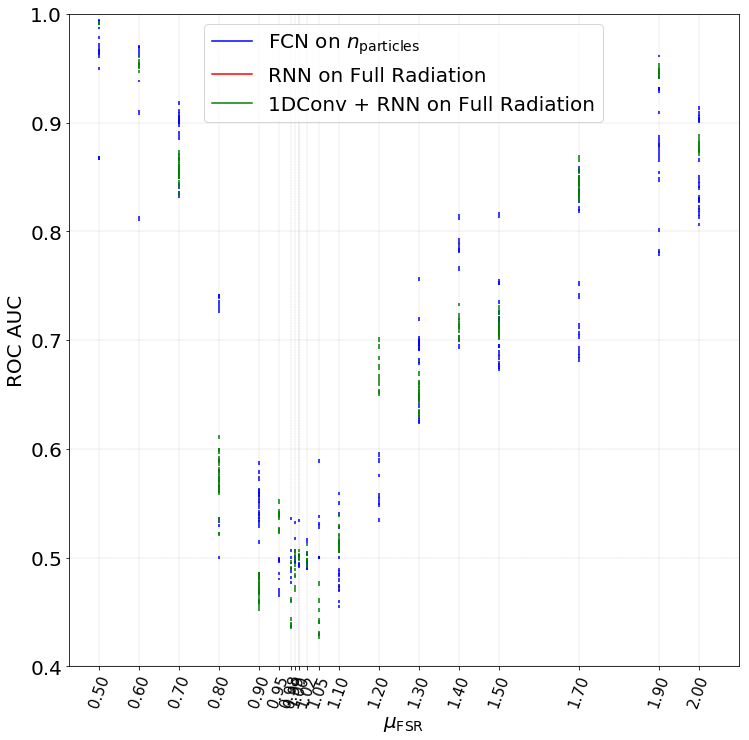

In [283]:
plt.style.use(plt.style.available[13])#3
matplotlib.rcParams.update({'font.size' : 20})

f, ax = plt.subplots(figsize=(12,12))
xticks = []
# r = collections.OrderedDict(sorted(results_ntrk.items()))
r = collections.OrderedDict(sorted(corrected_results_conv1d.items()))

# color = iter(matplotlib.cm.rainbow(np.linspace(0, 1, len(r))))
color = iter(matplotlib.cm.Blues(np.linspace(0.1, 1, len(muvalues))))
color_2 = iter(matplotlib.cm.Reds(np.linspace(0.1, 1, len(muvalues))))
color_3 = iter(matplotlib.cm.Greens(np.linspace(0.1, 1, len(muvalues))))


for i in muvalues:
    c = next(color)
#   x = float('.'.join(list(i.split('fsr')[-1])))
    x = i
#     if i in results_ntrk:
#         y = r[x]
#         plt.scatter([x] * len(y), y, marker='.', s=10, alpha=1, color='blue')
#         plt.errorbar(x, np.mean(y), yerr=np.std(y, ddof=1), marker='o', markersize='5', mec='black',
#                      color=c, capsize=8, linewidth=3, ecolor=c)#, fillstyle='none')
#         #plt.errorbar(x, np.mean(y), yerr=np.std(y, ddof=1)/np.sqrt(len(y)), marker='o', markersize='5', mec='black',
#         #             color=c, capsize=8, linewidth=3, ecolor=c)#, fillstyle='none')
    if i in corrected_results_ntrk:
        y_ntrk = unumpy.nominal_values(corrected_results_ntrk[i])
        err_ntrk = unumpy.std_devs(corrected_results_ntrk[i])
#         plt.scatter([x] * len(y_conv1d), y_conv1d, marker='+', s=10, alpha=1, color='green')
#         plt.errorbar(x, np.mean(y_conv1d), yerr=np.std(y_conv1d), marker='D', markersize='5', mec='black',
#                  color=c, capsize=8, linewidth=3, ecolor=c)
        for (_c, _e) in zip(y_ntrk, err_ntrk):
            plt.errorbar(x, _c, yerr=_e, color='blue')
    xticks.append(x)
    
#     c = next(color_2)
#     if i in results_rnn:
#         y_rnn = results_rnn[i]
#         plt.scatter([x] * len(y_rnn), y_rnn, marker='*', s=10, alpha=1, color='red')
#         plt.errorbar(x, np.mean(y_rnn), yerr=np.std(y_rnn, ddof=1), marker='^', markersize='5', mec='black',
#                  color=c, capsize=8, linewidth=3, ecolor=c)
#         #plt.errorbar(x, np.mean(y_rnn), yerr=np.std(y_rnn, ddof=1)/np.sqrt(len(y_rnn)), marker='^', markersize='5', mec='black',
#         #          color=c, capsize=8, linewidth=3, ecolor=c)


        
#     c = next(color_3)
    if i in corrected_results_conv1d:
        y_conv1d = unumpy.nominal_values(corrected_results_conv1d[i])
        err_conv1d = unumpy.std_devs(corrected_results_conv1d[i])
#         plt.scatter([x] * len(y_conv1d), y_conv1d, marker='+', s=10, alpha=1, color='green')
#         plt.errorbar(x, np.mean(y_conv1d), yerr=np.std(y_conv1d), marker='D', markersize='5', mec='black',
#                  color=c, capsize=8, linewidth=3, ecolor=c)
        for (_c, _e) in zip(y_conv1d, err_conv1d):
            plt.errorbar(x, _c, yerr=_e, color='green')#, marker='D', markersize='5', mec='black',
                 #color=c, capsize=8, linewidth=3, ecolor=c)
    
#     if i in corrected_results_rnn:
#         y_rnn = unumpy.nominal_values(corrected_results_rnn[i])
#         err_rnn = unumpy.std_devs(corrected_results_rnn[i])
#         for (_c, _e) in zip(y_rnn, err_rnn):  
#             plt.errorbar(x, _c, yerr=_e, color='red')

ax.set_xticks(xticks)
ax.set_xticks([1], minor=True)
plt.xticks(rotation=70, fontsize=15)
ax.xaxis.grid(True, 'both', linestyle='dashed', linewidth=0.3)
ax.yaxis.grid(True, linestyle='dashed', linewidth=0.3)

plt.xlabel(r'$\mu_\mathrm{FSR}$')
plt.ylabel('ROC AUC')
plt.ylim(0.4, 1.0)
plt.xlim(xmax=2.1)

handle_rnn = mlines.Line2D([], [], color='red', #marker='^', ls='None',
                           #markersize=15,
                           label='RNN on Full Radiation',
                           fillstyle='none')
handle_conv1d = mlines.Line2D([], [], color='green',# marker='D', ls='None',
                           #markersize=15,
                           label='1DConv + RNN on Full Radiation',
                           fillstyle='none')
handle_ntrk = mlines.Line2D([], [], color='blue',# marker='o', ls='None',
                              #markersize=15, 
                              label = r'FCN on $n_\mathrm{particles}$',
                              fillstyle='none'
                             )

plt.legend(handles=[handle_ntrk, handle_rnn, handle_conv1d])#, ncol=2, mode='expand')

xaxis = np.linspace(0.5, 2.0, 50)

#make05(i)
# p = np.array([(k,i) for k,v in results_rnn.iteritems() for i in v])# if k not in [2.0]])
# plt.plot(xaxis, np.poly1d(np.polyfit(p[:, 0], p[:, 1], 3))(xaxis), color='red')

# p = np.array([(k,i) for k,v in results_ntrk.iteritems() for i in v])# if k not in [2.0]])
# plt.plot(xaxis, np.poly1d(np.polyfit(p[:, 0], p[:, 1], 3))(xaxis), color='blue')

# p = np.array([(k,i) for k,v in corrected_results_ntrk.iteritems() for i in v if k not in [0.5, 0.6, 1.9, 2.0]])
# plt.plot(xaxis, np.poly1d(
#     np.polyfit(
#         np.array(p[:, 0], dtype=float),
#         unumpy.nominal_values(p[:, 1]),
#         3,
#         w=1./unumpy.std_devs(p[:, 1])
#     ))(xaxis), color='blue'
# )

# plt.plot(xaxis, np.poly1d(
#     np.polyfit(
#         np.array(p[:, 0], dtype=float),
#         unumpy.nominal_values(p[:, 1]),
#         2,
#         w=1./unumpy.std_devs(p[:, 1])
#     ))(xaxis), color='blue', linestyle='--'
# )

# p = np.array([(k,i) for k,v in corrected_results_rnn.iteritems() for i in v if k not in [0.5, 0.6, 1.9, 2.0]])
# plt.plot(xaxis, np.poly1d(
#     np.polyfit(
#         np.array(p[:, 0], dtype=float),
#         unumpy.nominal_values(p[:, 1]),
#         3,
#         w=1./unumpy.std_devs(p[:, 1])
#     ))(xaxis), color='red'
# )

# p = np.array([(k,i) for k,v in corrected_results_conv1d.iteritems() for i in v if k not in [0.5, 0.6, 1.9, 2.0]])
# plt.plot(xaxis, np.poly1d(
#     np.polyfit(
#         np.array(p[:, 0], dtype=float),
#         unumpy.nominal_values(p[:, 1]),
#         3,
#         w=1./unumpy.std_devs(p[:, 1])
#     ))(xaxis), color='green'
# )


plt.show()
# f.savefig('single.jpg')



In [9]:
import uncertainties
from uncertainties import umath

In [10]:
def quadratic_min(c0, c1, c2):
    return 1./(6*c0) * (-2 * c1 + umath.sqrt(4*c1**2 - 12 * c0*c2))

def linear_min(c0, c1):
    return - c1 / (2 * c0)

def function_min(coeff, deg):
    if deg == 2:
        return linear_min(*coeff[:2])
    elif deg == 3:
        return quadratic_min(*coeff[:3])
    

In [69]:
def correct_results(results, n_events=None):
    '''
    Correct AUC with stat error and remove worse 2 AUCs per mu
    '''
    corrected_results = {}
    for k in results.keys():

        if weighted:
            n1, n2 = n_events['Baseline'], n_events['fsr' +str(k).replace('.', '')]
        else:
            n1 = n2 = 100000 # approximately

        corrected_results[k] = unumpy.uarray(
            unumpy.nominal_values(results[k]),
            np.sqrt(
                st_err_auc(unumpy.nominal_values(results[k]), n1, n2)**2 + unumpy.std_devs(results[k])**2
            )
        )

    for i in corrected_results:
        corrected_results[i] = sorted(corrected_results[i])[2:]
    return corrected_results

In [99]:
corrected_results_ntrk3 = correct_results(eval(open('./uw3_results_ntrk.json').read()))
corrected_results_ntrk2 = correct_results(eval(open('./uw2_results_ntrk.json').read()))
corrected_results_ntrk1 = correct_results(eval(open('./uw1_results_ntrk.json').read()))
corrected_results_ntrk0 = correct_results(eval(open('./uw0_results_ntrk.json').read()))

In [100]:
def bootstrap_mean(method_results, method_names, mumin=0.9, mumax=1.2):
    '''
    Returns a dictionary with one entry per method name
    Each entry consists of a list of [mu, mean, std] elements
    '''
    bs_forfit = {}

    for method, results in zip(method_names, method_results):

        bs_method = []
        for k in results.keys():
            if (k >= mumin) and (k <= mumax): # 1.15
                mean_auc_bs = []
                for _ in range(10000): 
                    choice = np.random.choice(results[k], len(results[k]))
                    mean_auc_bs.append(
                        np.random.normal(unumpy.nominal_values(choice), unumpy.std_devs(choice)).mean()
                    )
                bs_method.append([k, np.mean(mean_auc_bs), np.std(mean_auc_bs)])
        bs_forfit[method] = np.array(bs_method)
        
    return bs_forfit

In [102]:
bs_forfit = bootstrap_mean(
    [corrected_results_ntrk, corrected_results_ntrk3, corrected_results_ntrk2, corrected_results_ntrk1, corrected_results_ntrk0],
    ['ntrk4', 'ntrk3', 'ntrk2', 'ntrk1', 'ntrk0'],
    mumin=0.9, mumax=1.2
)

In [103]:
def reduced_chi2(coeff, bs_forfit_method, deg):
    '''
    Calculate X^2 / DoF
    '''
    chi2 = np.sum(((
            np.poly1d(
                unumpy.nominal_values(coeff)
            )(bs_forfit_method[:, 0]) - bs_forfit_method[:, 1]
        #) ) ** 2)
        ) / bs_forfit_method[:, 2]) ** 2)

    nu = bs_forfit_method.shape[0] - 1 - deg
    return chi2 / nu

ntrk0: 1.10862+/-0.02158, chi2/dof = 9.60673469172
ntrk1: 1.00745+/-0.03192, chi2/dof = 30.2032756797
ntrk2: 1.08619+/-0.00684, chi2/dof = 13.9851662761
ntrk3: 1.07737+/-0.06233, chi2/dof = 21.4690387859
ntrk4: 1.03832+/-0.01901, chi2/dof = 6.09677404174


(0.4, 2.1)

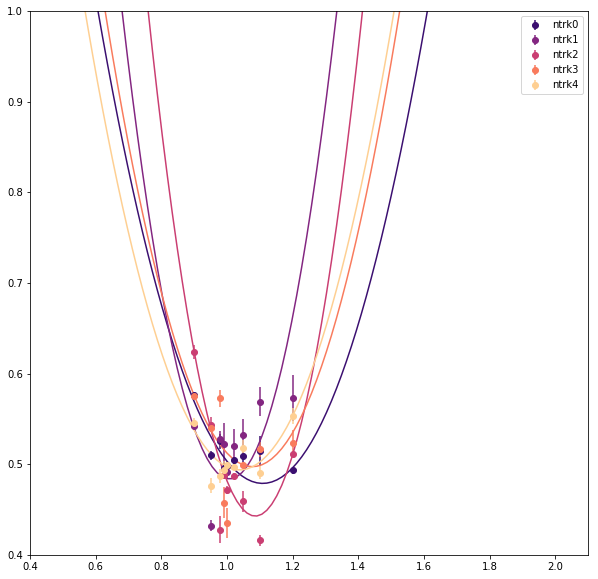

In [114]:
xaxis = np.linspace(0.5, 2.0, 100)
plt.figure(figsize=(10,10))
color = iter(plt.cm.magma(np.linspace(0.2,0.9,5)))
deg = 2
for method in ['ntrk0', 'ntrk1', 'ntrk2', 'ntrk3', 'ntrk4']:# 'conv1d']:#, 'rnn']:
    c = next(color)
    plt.errorbar(
        bs_forfit[method][:, 0],
        bs_forfit[method][:, 1],
        yerr=bs_forfit[method][:, 2], 
        marker='o', linestyle='none', label=method, color=c)
    
    coeff, cov = np.polyfit(
        bs_forfit[method][:, 0],
        bs_forfit[method][:, 1],
        deg,
        w=1/bs_forfit[method][:, 2],
        cov=True
    )
    coeff = uncertainties.correlated_values(coeff, cov)
    print '{0}: {1:.5f}, chi2/dof = {2}'.format(
        method,
        function_min(coeff, deg),
        reduced_chi2(coeff, bs_forfit[method], deg)
    )
    
    plt.plot(xaxis, np.poly1d(unumpy.nominal_values(coeff))(xaxis), color=c)
    
plt.legend(loc='upper right')
plt.ylim(0.4, 1.0)
plt.xlim(0.4, 2.1)

In [106]:
# sort the x values
for k, v in bs_forfit.iteritems():
    bs_forfit[k] = v[v[:, 0].argsort()]

In [107]:
def weighted_avg_and_std(values, weights):
    import math 
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

In [108]:
joint_aucs = []
for i in range(len(bs_forfit['ntrk0'])):
    measurements = np.array(bs_forfit.values())[:, i]
#     print np.average(measurements[:, 1], weights=measurements[:, 2])
    joint_aucs.append(
        [measurements[0][0]] + list(weighted_avg_and_std(measurements[:, 1], weights=measurements[:, 2]))
    )
joint_aucs = np.array(joint_aucs)

1.05456+/-0.01517, chi2/dof = 0.486713418


(0.8, 1.4)

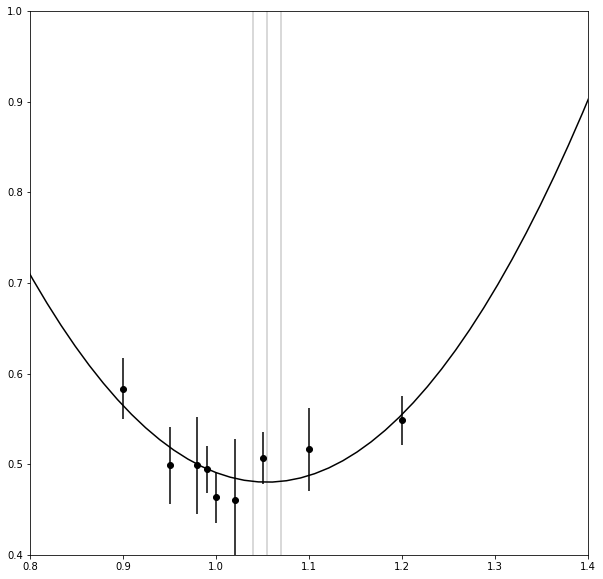

In [119]:
plt.figure(figsize=(10,10))

deg = 2
plt.errorbar(
    joint_aucs[:, 0],
    joint_aucs[:, 1],
    yerr=joint_aucs[:, 2], 
    linestyle='none', color='black', marker='o')

coeff, cov = np.polyfit(
    joint_aucs[:, 0],
    joint_aucs[:, 1],
    deg,
    w=1/joint_aucs[:, 2],
    cov=True
)
coeff = uncertainties.correlated_values(coeff, cov)
minimum = function_min(coeff, deg)
print '{0:.5f}, chi2/dof = {1}'.format(
    minimum,
    reduced_chi2(coeff, joint_aucs, deg)
)
plt.vlines(minimum.nominal_value, 0.4, 1.0, alpha=0.2)
plt.vlines(minimum.nominal_value - minimum.std_dev, 0.4, 1.0, alpha=0.2)
plt.vlines(minimum.nominal_value + minimum.std_dev, 0.4, 1.0, alpha=0.2)
plt.plot(xaxis, np.poly1d(unumpy.nominal_values(coeff))(xaxis), color='black')
    
# plt.legend(loc='upper center')
plt.ylim(0.4, 1.0)
plt.xlim(0.8, 1.4)

In [ ]:
# cubic, full range
# ntrk: 1.01845+/-0.03108, chi2/dof = 49.7945164569
# conv1d: 1.03733+/-0.02668, chi2/dof = 406.260513496
# rnn: 1.04800+/-0.03406, chi2/dof = 114.905533968

# cubic, [0.7, 1.7]
# ntrk: 1.01850+/-0.01134, chi2/dof = 12.3086688953
# conv1d: 1.03739+/-0.01842, chi2/dof = 244.411232928
# rnn: 1.03967+/-0.01333, chi2/dof = 18.7017389142

# quadratic, [0.7, 1.5]
# ntrk: 1.08619+/-0.02238, chi2/dof = 47.2333376553
# conv1d: 1.12286+/-0.02026, chi2/dof = 672.74629844
# rnn: 1.08840+/-0.01846, chi2/dof = 42.7534438644

# quadratic, [0.7, 1.3] 
# ntrk: 1.04608+/-0.00813, chi2/dof = 9.10186182897
# conv1d: 1.04264+/-0.01777, chi2/dof = 226.377431407
# rnn: 1.05393+/-0.01406, chi2/dof = 22.5944295235


In [64]:
corrected_weighted_ntrk = correct_results(eval(open('./w_results_ntrk_differentBaselineFile.json').read()))

In [122]:
fitme_wuw = bootstrap_mean(
    [corrected_results_ntrk, corrected_weighted_ntrk],
    ['no weights', 'weights'],
    mumin=0., mumax=2.
)

no weights: 1.01538+/-0.02342, chi2/dof = 18.6661283598
weights: 0.95837+/-0.01489, chi2/dof = 16.5846184555


Text(0.5,1,'FCN on ntrack variables')

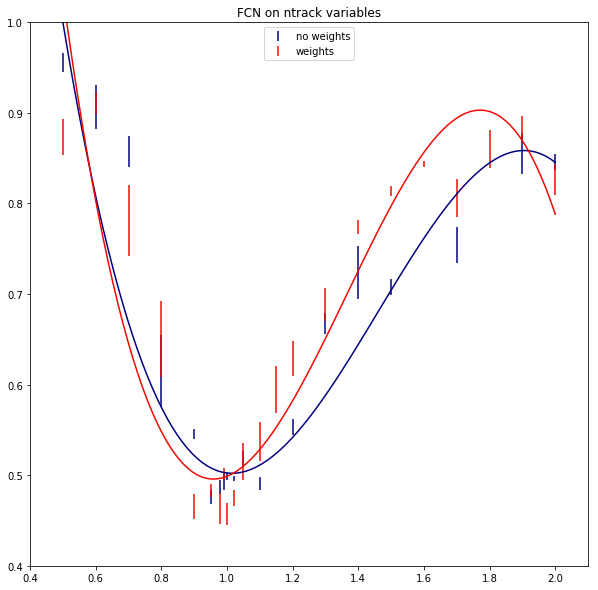

In [123]:
plt.figure(figsize=(10,10))
color = iter(plt.cm.jet(np.linspace(0.,0.9,2)))
deg = 3
for method in ['no weights', 'weights']:
    c = next(color)
    plt.errorbar(
        fitme_wuw[method][:, 0],
        fitme_wuw[method][:, 1],
        yerr=fitme_wuw[method][:, 2], 
        linestyle='none', label=method, color=c)
    
    coeff, cov = np.polyfit(
        fitme_wuw[method][:, 0],
        fitme_wuw[method][:, 1],
        deg,
        w=1/fitme_wuw[method][:, 2],
        cov=True
    )
    coeff = uncertainties.correlated_values(coeff, cov)
    print '{0}: {1:.5f}, chi2/dof = {2}'.format(
        method,
        function_min(coeff, deg),
        reduced_chi2(coeff, fitme_wuw[method], deg)
    )
    
    plt.plot(xaxis, np.poly1d(unumpy.nominal_values(coeff))(xaxis), color=c)
    
plt.legend(loc='upper center')
plt.ylim(0.4, 1.0)
plt.xlim(0.4, 2.1)
plt.title('FCN on ntrack variables')

In [508]:
# r = collections.OrderedDict(sorted(results_rnn.items()))
# minima_rnn = []
# for _ in range(100000):
#     random_sample = np.array([(x, np.random.choice(aucs)) for x, aucs in r.iteritems()])
    
# #     random_sample[:, 1] = [make05(auc) for auc in random_sample[:, 1]]

#     coeff, cov = np.polyfit(random_sample[:, 0], random_sample[:, 1], 3, cov=True)
#     coeff = uncertainties.correlated_values(coeff, cov)
#     minima_rnn.append(quadratic_min(*coeff[:3])) 
r = collections.OrderedDict(sorted(corrected_results_rnn.items()))

# filter out unwanted mu values in the fit
r = {key : value for key, value in r.iteritems() if key not in [0.5, 0.6, 1.9, 2.0]}

minima_rnn = []
for _ in range(100000):
    random_sample = np.array([(x, np.random.choice(aucs)) for x, aucs in r.iteritems()])# if x not in [0.5, 2.0]])
    
#     random_sample[:, 1] = [make05(auc) for auc in random_sample[:, 1]]

    coeff, cov = np.polyfit(
        np.array(random_sample[:, 0], dtype=float),
        np.array(unumpy.nominal_values(random_sample[:, 1]), dtype=float),
        3,
        cov=True,
        w=1./np.array(unumpy.std_devs(random_sample[:, 1]), dtype=float)
    )
    coeff = uncertainties.correlated_values(coeff, cov)
    minima_rnn.append(quadratic_min(*coeff[:3])) 

In [509]:
# r = collections.OrderedDict(sorted(results_ntrk.items()))
# minima_ntrk = []
# for _ in range(100000):
#     random_sample = np.array([(x, np.random.choice(aucs)) for x, aucs in r.iteritems()])
    
# #     random_sample[:, 1] = [make05(auc) for auc in random_sample[:, 1]]
    
#     coeff, cov = np.polyfit(random_sample[:, 0], random_sample[:, 1], 3, cov=True)
#     coeff = uncertainties.correlated_values(coeff, cov)
#     minima_ntrk.append(quadratic_min(*coeff[:3]))

r = collections.OrderedDict(sorted(corrected_results_ntrk.items()))

# filter out unwanted mu values in the fit
r = {key : value for key, value in r.iteritems() if key not in [0.5, 0.6, 1.9, 2.0]}

minima_ntrk = []
for _ in range(100000):
    random_sample = np.array([(x, np.random.choice(aucs)) for x, aucs in r.iteritems()])# if x not in [0.5, 2.0]])
    
#     random_sample[:, 1] = [make05(auc) for auc in random_sample[:, 1]]

    coeff, cov = np.polyfit(
        np.array(random_sample[:, 0], dtype=float),
        np.array(unumpy.nominal_values(random_sample[:, 1]), dtype=float),
        3,
        cov=True,
        w=1./np.array(unumpy.std_devs(random_sample[:, 1]), dtype=float)
    )
    coeff = uncertainties.correlated_values(coeff, cov)
    minima_ntrk.append(quadratic_min(*coeff[:3])) 

In [510]:
r = collections.OrderedDict(sorted(corrected_results_conv1d.items()))

# filter out unwanted mu values in the fit
r = {key : value for key, value in r.iteritems() if key not in [0.5, 0.6, 1.9, 2.0]}

minima_conv = []
for _ in range(100000):
    random_sample = np.array([(x, np.random.choice(aucs)) for x, aucs in r.iteritems()])# if x not in [0.5, 2.0]])
    
#     random_sample[:, 1] = [make05(auc) for auc in random_sample[:, 1]]

    coeff, cov = np.polyfit(
        np.array(random_sample[:, 0], dtype=float),
        np.array(unumpy.nominal_values(random_sample[:, 1]), dtype=float),
        3,
        cov=True,
        w=1./np.array(unumpy.std_devs(random_sample[:, 1]), dtype=float)
    )
    coeff = uncertainties.correlated_values(coeff, cov)
    minima_conv.append(quadratic_min(*coeff[:3])) 

Text(0.5,0,'Bootstrapped minima')

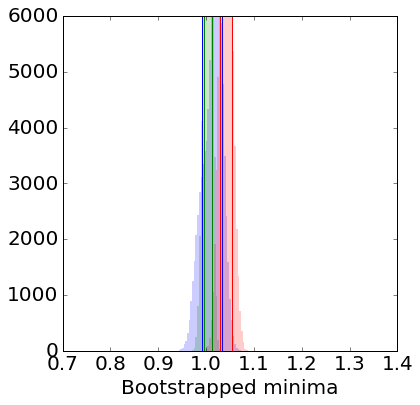

In [511]:
plt.rcParams["patch.force_edgecolor"] = False
nominal_minima_conv = [_.nominal_value for _ in minima_conv]
nominal_minima_rnn = [_.nominal_value for _ in minima_rnn]
nominal_minima_ntrk = [_.nominal_value for _ in minima_ntrk]

plt.figure(figsize=(6, 6))
bins = np.linspace(0.7, 1.4, 200)
plt.hist(nominal_minima_ntrk, bins=bins, alpha=0.2, color='blue')
plt.hist(np.array(nominal_minima_rnn)[np.isfinite(nominal_minima_rnn)], bins=bins, alpha=0.2, color='red')
plt.hist(np.array(nominal_minima_conv)[np.isfinite(nominal_minima_conv)], bins=bins, alpha=0.2, color='green')

plt.vlines(np.percentile(nominal_minima_ntrk, 100-16), 0, 6000, color='blue')
plt.vlines(np.percentile(nominal_minima_ntrk, 16), 0, 6000, color='blue')

plt.vlines(np.percentile(np.array(nominal_minima_rnn)[np.isfinite(nominal_minima_rnn)], 100-16), 0, 6000, color='red')
plt.vlines(np.percentile(np.array(nominal_minima_rnn)[np.isfinite(nominal_minima_rnn)], 16), 0, 6000, color='red')

plt.vlines(np.percentile(nominal_minima_conv, 100-16), 0, 6000, color='green')
plt.vlines(np.percentile(nominal_minima_conv, 16), 0, 6000, color='green')

line_handle = mlines.Line2D([], [], color='blue', ls='-',
                              label = r'FCN - $68\%$ C.I.',
                              fillstyle='none'
                             )
line_handle_rnn = mlines.Line2D([], [], color='red', ls='-',
                              label = r'RNN - $68\%$ C.I.',
                              fillstyle='none'
                             )
line_handle_cnn = mlines.Line2D([], [], color='green', ls='-',
                              label = r'CRNN - $68\%$ C.I.',
                              fillstyle='none'
                             )
plt.ylim(0, 6000)
plt.xlabel('Bootstrapped minima')
# plt.legend(handles=[line_handle, line_handle_rnn, line_handle_cnn])

In [54]:
#np.mean(np.array(minima_conv))

In [55]:
#np.sqrt(np.sum(unumpy.std_devs(minima_conv)**2)) / 100000.

In [56]:
#np.median(np.array(minima_conv))

In [57]:
# conv
import math
# np.median(np.array(minima_conv))
# se_mean = np.mean(np.array(minima_conv)).std_dev 

#var = np.var(np.array(nominal_minima_conv)[np.isfinite(minima_conv)]) # variance = sigma^2
median = np.median(np.array(nominal_minima_conv)[np.isfinite(nominal_minima_conv)])
print 'median', median

# # statistical error in the bootstrap (goes down as sqrt(N_bootstrap))
# print 'standard error on the median', math.sqrt(math.pi / 2 ) * np.std(nominal_minima_conv) / np.sqrt(100000) #se_mean
#print 'mean', np.mean(np.array(minima_conv)[np.isfinite(minima_conv)])
lower = np.percentile(unumpy.nominal_values(minima_conv), 16)
upper = np.percentile(unumpy.nominal_values(minima_conv), 100-16)
print 'lower', lower
print 'upper', upper
print median, upper - median, median - lower, upper - lower

median 1.1334736197391395
lower 1.0839702917824037
upper 1.170310212292961
1.1334736197391395 0.036836592553821434 0.04950332795673584 0.08633992051055728


In [58]:
# rnn


# se_mean = np.mean(np.array(minima_rnn)).std_dev 
# print 'median', np.median(np.array(nominal_minima_rnn)[np.isfinite(nominal_minima_rnn)])
# # statistical error in the bootstrap (goes down as sqrt(N_bootstrap))
# print 'standard error on the median', math.sqrt(math.pi / 2 ) * se_mean

# print 'mean', np.mean(np.array(minima_rnn)[np.isfinite(minima_rnn)])
median = np.median(np.array(nominal_minima_rnn)[np.isfinite(nominal_minima_rnn)])
print 'median', median

lower = np.percentile(unumpy.nominal_values(minima_rnn), 16)
upper = np.percentile(unumpy.nominal_values(minima_rnn), 100-16)
print 'lower', lower
print 'upper', upper
print median, upper - median, median - lower, upper - lower

median 1.054275460160519
lower 1.0353947621394575
upper 1.0713911989252316
1.054275460160519 0.017115738764712507 0.018880698021061626 0.03599643678577413


In [59]:
# ntrack
#np.median(np.array(minima_ntrk))

# se_mean = np.mean(np.array(minima_ntrk)).std_dev 
# print 'median', np.median(np.array(nominal_minima_ntrk)[np.isfinite(nominal_minima_ntrk)])
# # statistical error in the bootstrap (goes down as sqrt(N_bootstrap))
# print 'standard error on the median', math.sqrt(math.pi / 2 ) * se_mean

# print 'mean', np.mean(minima_ntrk)
median = np.median(np.array(nominal_minima_ntrk)[np.isfinite(nominal_minima_ntrk)])
print 'median', median

lower = np.percentile(unumpy.nominal_values(minima_ntrk), 16)
upper = np.percentile(unumpy.nominal_values(minima_ntrk), 100-16)
print 'lower', lower
print 'upper', upper
print median, upper - median, median - lower, upper - lower

median 1.023518326186354
lower 0.995107615557052
upper 1.0453725474599838
1.023518326186354 0.02185422127362968 0.028410710629302116 0.0502649319029318


In [551]:
from scipy.stats import ttest_ind, ks_2samp

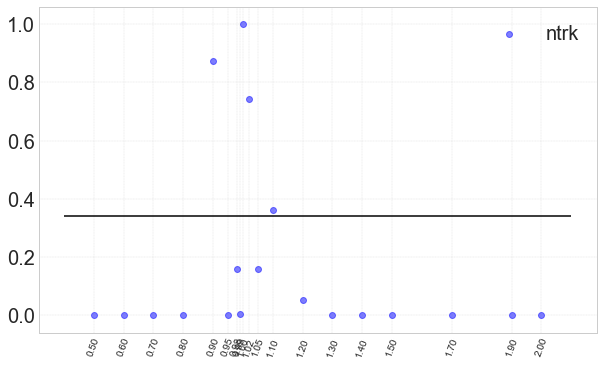

In [1125]:
f, ax = plt.subplots(figsize=(10,6))
# _p_rnn = np.array(
#     [(x, ttest_ind(results_rnn[x], results_rnn[1.0], equal_var=False)[-1]) for x in xticks if x in results_rnn]
# )
# _p_ntrk = np.array(
#     [(x, ttest_ind(results_ntrk[x], results_ntrk[1.0], equal_var=False)[-1]) for x in xticks if x in results_ntrk]
# )
_p_ntrk = np.array(
    [(x, ks_2samp(results_ntrk[x][:], results_ntrk[1.0][:])[-1]) for x in xticks
     if x in results_ntrk and len(results_ntrk[x])>=0]
)
# plt.scatter(_p_rnn[:, 0], _p_rnn[:, 1], label='rnn', color='red', alpha=0.5)
plt.scatter(_p_ntrk[:, 0], _p_ntrk[:, 1], label='ntrk', color='blue', alpha=0.5)

plt.hlines(0.341, 0.4, 2.1)
ax.set_xticks(xticks)
plt.xticks(rotation=70, fontsize=10)
ax.xaxis.grid(True, 'both', linestyle='dashed', linewidth=0.3)
ax.yaxis.grid(True, linestyle='dashed', linewidth=0.3)

plt.legend()

# History

In [1256]:
# training loss 09
train_loss = [0.69188, 0.67830, 0.65997, 0.64384, 0.63688, 0.63737, 0.62630, 0.61997, 0.62190, 0.61890, 0.61572, 0.60239, 0.59941, 0.60424, 0.59538, 0.58855, 0.59031, 0.57991, 0.58637, 0.58517, 0.57992, 0.57663, 0.57380, 0.57489, 0.57628, 0.56716, 0.56026, 0.55840, 0.55682, 0.54942, 0.56100, 0.53895, 0.54560, 0.54257, 0.54348]

# validation loss 09
val_loss = [0.69327, 0.69315, 0.69969, 0.70932, 0.72162, 0.71513, 0.72323, 0.72881, 0.72319, 0.72644, 0.71841, 0.73043, 0.74656, 0.72948, 0.73284, 0.73727, 0.72675, 0.73441, 0.73137, 0.73796, 0.73330, 0.73564, 0.75990, 0.73978, 0.73638, 0.73149, 0.74250, 0.74130, 0.74164, 0.75827, 0.75051, 0.77991, 0.75774, 0.76636, 0.77543]

# validation auc 09
val_auc = [0.51026, 0.53772, 0.52312, 0.52707, 0.53484, 0.53815, 0.52974, 0.53362, 0.54507, 0.54289, 0.55568, 0.55437, 0.55114, 0.56116, 0.55486, 0.55226, 0.55862, 0.55281, 0.56156, 0.55876, 0.56542, 0.55804, 0.56111, 0.55691, 0.56889, 0.57979, 0.56147, 0.57104, 0.57009, 0.55199, 0.55926, 0.56110, 0.55929, 0.55877, 0.54459]

# test auc
test_auc = 0.44387720080680826


In [1244]:
# training loss 099
train_loss = [0.69317, 0.68964, 0.67964, 0.66635, 0.64871, 0.63594, 0.62367, 0.60879, 0.59581, 0.59282, 0.58132, 0.56981, 0.56988, 0.56365, 0.55113, 0.55704, 0.54300, 0.53783, 0.54077, 0.53918, 0.51068, 0.52153, 0.50464, 0.49575, 0.49122, 0.49163, 0.49284, 0.47991, 0.47681, 0.45264, 0.47903, 0.47760, 0.46619, 0.46720, 0.45806, 0.44663, 0.43808, 0.44067, 0.43393, 0.43315, 0.41175, 0.41300]

# val loss 099
val_loss = [0.69306, 0.69399, 0.69284, 0.69034, 0.69395, 0.69247, 0.69056, 0.68947, 0.70865, 0.69668, 0.69978, 0.71012, 0.71175, 0.70936, 0.74305, 0.70388, 0.71663, 0.70892, 0.70549, 0.70156, 0.70631, 0.72388, 0.71363, 0.74522, 0.72243, 0.72130, 0.75752, 0.71883, 0.70436, 0.86444, 0.71879, 0.71413, 0.70183, 0.72342, 0.69813, 0.71837, 0.71310, 0.71723, 0.72268, 0.72206, 0.75731, 0.76454]

# val auc 099
val_auc = [0.50195, 0.50854, 0.52922, 0.54576, 0.55183, 0.56191, 0.56993, 0.58292, 0.57959, 0.58155, 0.58121, 0.57911, 0.58167, 0.57856, 0.59085, 0.59359, 0.58491, 0.59878, 0.60542, 0.60362, 0.60448, 0.60600, 0.60696, 0.59788, 0.60750, 0.60960, 0.62352, 0.63034, 0.64206, 0.63249, 0.63455, 0.63417, 0.65296, 0.63838, 0.64799, 0.64283, 0.64414, 0.63732, 0.64359, 0.63937, 0.63125, 0.62412]

# test auc 099
test_auc = 0.4359270705641399

In [1242]:
# training loss 14
train_loss = [0.69357, 0.69323, 0.69234, 0.68926, 0.68358, 0.67403, 0.66394, 0.65335, 0.64562, 0.63753, 0.62833, 0.61662, 0.61257, 0.60664, 0.59620, 0.59244, 0.57865, 0.58079, 0.57221, 0.56655, 0.56267, 0.54815, 0.55378, 0.55101, 0.53800, 0.52928, 0.54040]

# val loss 14
val_loss = [0.69298, 0.69283, 0.69006, 0.68653, 0.67938, 0.67473, 0.67765, 0.66446, 0.66914, 0.69219, 0.66010, 0.65615, 0.65606, 0.65316, 0.65932, 0.65427, 0.65649, 0.70602, 0.66947, 0.65111, 0.75004, 0.66417, 0.66198, 0.65847, 0.74246, 0.66834, 0.88877]

# val auc 14
val_auc = [0.50836, 0.52024, 0.58138, 0.60521, 0.64039, 0.64770, 0.65444, 0.66818, 0.64775, 0.66842, 0.66553, 0.65600, 0.65410, 0.66556, 0.67245, 0.65999, 0.65458, 0.67497, 0.64564, 0.66500, 0.66188, 0.65523, 0.65694, 0.66412, 0.67063, 0.65116, 0.66378]

# test auc 14
test_auc = 0.5096073620074205


In [1260]:
# 0.7
train_loss = [0.694938001818, 0.694593678709, 0.69432221797, 0.69417692683, 0.693944991482, 0.693879754984, 0.693767604329, 0.693680341884, 0.69364930472, 0.693409949524, 0.693236633151, 0.692766708858, 0.692487884354, 0.691811962612, 0.691128906604, 0.690146022455, 0.688769884384, 0.686282425412, 0.683431979965, 0.679263539583, 0.675366842795, 0.670658441428, 0.665338275012, 0.660538412646, 0.654674824328, 0.649356232027, 0.642261472066, 0.637563578536, 0.631812204295, 0.626831810072, 0.620484678765, 0.616381852888, 0.610574660868, 0.603841922713, 0.602573610391, 0.596730536713, 0.593305418165, 0.589616089411, 0.584423087174, 0.581369855008, 0.577123873826, 0.572471690778, 0.571502196481, 0.565506333054, 0.565800712814, 0.56561736151, 0.558338770215, 0.554230338912, 0.550673068147, 0.549025619558, 0.551634935625, 0.550063790352, 0.539610957597, 0.545864989708]

val_loss = [0.693011385721, 0.693029995974, 0.692974445161, 0.692948420663, 0.692895877827, 0.692859339463, 0.692795943569, 0.692756666257, 0.692679586711, 0.692603740606, 0.692411724691, 0.692222534536, 0.691892263768, 0.691616456788, 0.691170557662, 0.690596002358, 0.689889274023, 0.688681988924, 0.687343169798, 0.685855285362, 0.684086619734, 0.682352238947, 0.681199378616, 0.679210053908, 0.678098710092, 0.677296495473, 0.675042277252, 0.674590972809, 0.672416377354, 0.670713473369, 0.671298145263, 0.669039515135, 0.669218059596, 0.669133347434, 0.667899620426, 0.667335514281, 0.667145265652, 0.66673826527, 0.668286680638, 0.673425791589, 0.672059197684, 0.674665489444, 0.666430409606, 0.666809829685, 0.666298461927, 0.669709043997, 0.668355445112, 0.668301173159, 0.670927014347, 0.692792630545, 0.669386600186, 0.67206850281, 0.668043410948, 0.679781982491]

test_auc = [0.7207322436382207]


In [1262]:
# 0.8 
train_loss = [0.694366865297, 0.693986399723, 0.693858186192, 0.693821060227, 0.693815296735, 0.693765881271, 0.693748472042, 0.693776834508, 0.693765599326, 0.693748101862, 0.693762795197, 0.693756496297, 0.693752953842, 0.693709376023, 0.693695764412, 0.693705613413, 0.693726687022, 0.693685263152, 0.693656945508, 0.693638335379, 0.693583073574, 0.693541627594, 0.693529642483, 0.693422433037, 0.693264243729, 0.693150516726, 0.692956491887, 0.692772552456, 0.692166617886, 0.691806826567, 0.691396068308, 0.690906291448, 0.690022823881, 0.689381738342, 0.688671288488, 0.687727612573, 0.686770284316, 0.686198939307, 0.684853018901, 0.683815935012, 0.682541784143, 0.682278744559, 0.681065285111, 0.680232763849, 0.678458089556, 0.676771774417, 0.675130504943, 0.674978852976, 0.671953266795, 0.669179974684, 0.669392653357, 0.667766497116, 0.665249377576, 0.66405508269, 0.662369392626, 0.661665281018, 0.659282507362, 0.655544430741, 0.653580870161, 0.653838462266, 0.651055628584, 0.650063046244, 0.648396463546, 0.645894265432, 0.642211867586, 0.642118589217, 0.63876860362, 0.638441978616, 0.636565754886, 0.633929131101, 0.632597092402, 0.631356115381, 0.629160931319, 0.626951768261, 0.625949496391, 0.619084846364, 0.618418832592, 0.621358204469, 0.615909436964, 0.614770694501, 0.614146736425, 0.610447099563, 0.611161835877, 0.607378580042, 0.609908188356, 0.607995247293, 0.608172970985, 0.602011034358, 0.59917259223, 0.59991606745, 0.598520218303, 0.595988119839, 0.595605241688, 0.596907542135, 0.591552988979]

val_loss = [0.693070010476, 0.693022526283, 0.693014675757, 0.693016609396, 0.693015864068, 0.693020355665, 0.69301753624, 0.693014859793, 0.693011951951, 0.693009803482, 0.693007301528, 0.693003234546, 0.693003696617, 0.693000796698, 0.69299681093, 0.692989599489, 0.692976311074, 0.692963962108, 0.692939807101, 0.692893943038, 0.692845080194, 0.692797357942, 0.692740905141, 0.692713929807, 0.692522272062, 0.692356363524, 0.69214874632, 0.691863035507, 0.691448543367, 0.691047619117, 0.690706556297, 0.690103580944, 0.689473348082, 0.688893886851, 0.68847237829, 0.687908585698, 0.68735220137, 0.687133648064, 0.686163509, 0.685935243559, 0.68593142454, 0.685375731877, 0.684607178783, 0.684021886382, 0.683307584499, 0.682189859292, 0.681070058908, 0.679992862699, 0.678639363306, 0.679494175126, 0.677423096676, 0.676813820698, 0.676101947659, 0.675080104897, 0.673724042685, 0.672539929609, 0.672322309449, 0.672645845442, 0.671006056027, 0.669907248362, 0.669666804756, 0.67048994382, 0.669269671433, 0.667079608966, 0.667530489472, 0.665741733734, 0.664683253473, 0.665047339352, 0.665604958992, 0.66574377875, 0.666094143135, 0.664347853005, 0.665284128167, 0.667397556348, 0.666318865881, 0.662437763999, 0.663682749804, 0.659722562643, 0.661161497731, 0.660800075333, 0.661120282739, 0.661353863258, 0.661031773533, 0.671623420409, 0.666957867019, 0.658773575304, 0.664156126652, 0.662487325441, 0.664025670002, 0.687682466475, 0.665009937618, 0.662934610671, 0.663169211491, 0.673828571765, 0.678742468672
]

test_auc = [0.5555274792407693]

In [1273]:
# 0.9
train_loss = [0.693989151366, 0.693200811908, 0.693070530354, 0.692971729606, 0.692588936961, 0.692276129291, 0.691943289851, 0.691240691337, 0.690275924513, 0.688755865815, 0.686752586387, 0.684155203023, 0.681341839739, 0.678300001386, 0.675502937482, 0.672535819451, 0.669881780104, 0.667353294092, 0.664464736555, 0.662415645798, 0.658823806709, 0.656350172347]

val_loss = [0.692994529421, 0.692953426738, 0.692953449649, 0.692942001798, 0.692933462404, 0.692929356843, 0.692909044009, 0.69276865753, 0.692525752672, 0.692252512272, 0.691942625755, 0.691702589079, 0.691636003531, 0.691697637777, 0.691647742962, 0.692317964078, 0.692023320241, 0.6930357625, 0.693421515617, 0.694815551465, 0.695598306957, 0.696654540909]

test_auc= [0.4156765725195425]

(0, 22)

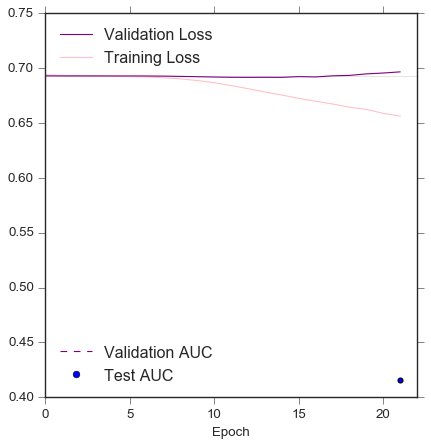

In [1274]:
plt.style.use(plt.style.available[3])

plt.figure(figsize=(6,6))

plt.hlines(-np.log(0.5), 0, len(train_loss), alpha=0.1)

plt.plot(range(len(train_loss)), train_loss, color='pink')
plt.plot(range(len(val_loss)), val_loss, color='purple')
# plt.plot(range(len(val_auc)), val_auc, color='purple', linestyle='--')

handle_val_loss = mlines.Line2D([], [], color='purple', ls='-',
                              label = r'Validation Loss',
                              fillstyle='none'
                             )
handle_train_loss = mlines.Line2D([], [], color='pink', ls='-',
                              label = r'Training Loss',
                              fillstyle='none'
                             )
handle_val_auc = mlines.Line2D([], [], color='purple', ls='--',
                              label = r'Validation AUC',
                              fillstyle='none'
                             )
handle_test_auc = mlines.Line2D([], [], color='blue', ls='none', marker = 'o',
                              label = r'Test AUC')

plt.scatter(len(train_loss)-1, test_auc)

legend1 = plt.legend(handles=[handle_val_loss, handle_train_loss], loc='upper left')
legend2 = plt.legend(handles=[handle_val_auc, handle_test_auc], loc='lower left')
plt.gca().add_artist(legend1)
# plt.gca().add_artist(legend2)
plt.xlabel('Epoch')

plt.xlim(0, len(train_loss))

In [71]:
results_w = yaml.load(open('results_weighted_var.yaml', 'r'))
results_uw = yaml.load(open('results.yaml', 'r'))



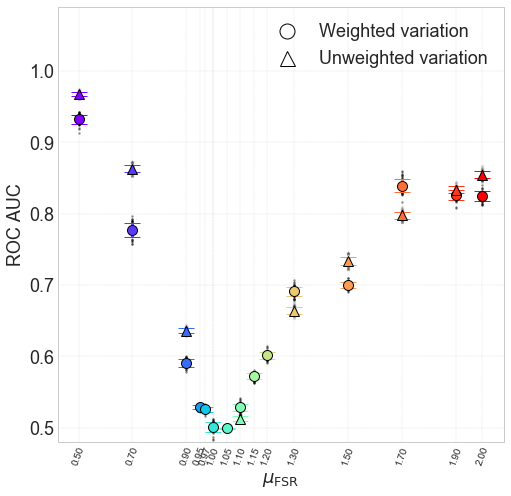

In [72]:
plt.style.use(plt.style.available[13])
matplotlib.rcParams.update({'font.size' : 18})

f, ax = plt.subplots(figsize=(8,8))
xticks = []
r = collections.OrderedDict(sorted(results_w.items()))

color = iter(matplotlib.cm.rainbow(np.linspace(0, 1, len(r))))

for i in r:
    c = next(color)
#     x = float('.'.join(list(i.split('fsr')[-1])))
    x = float('.'.join([i.split('fsr')[-1][0], i.split('fsr')[-1][1:]]))
    y = [float(y_) for y_ in r[i].split()]
    plt.scatter([x] * len(y), y, marker='.', s=10, alpha=0.3, color='black')
    plt.errorbar(x, np.mean(y), yerr=np.std(y), marker='o', markersize='10', mec='black',
                 color=c, capsize=8, linewidth=3, ecolor=c)#, fillstyle='none')
    xticks.append(x)
    
#     c = next(color)
    if i in results_uw:
        y_rnn = [float(y_) for y_ in results_uw[i].split()]
        plt.scatter([x] * 50, y_rnn, marker='*', s=10, alpha=0.1, color='black')
        plt.errorbar(x, np.mean(y_rnn), yerr=np.std(y_rnn), marker='^', markersize='10', mec='black',
                 color=c, capsize=8, linewidth=3, ecolor=c)

ax.set_xticks(xticks)
ax.set_xticks([1], minor=True)
plt.xticks(rotation=70, fontsize=10)
ax.xaxis.grid(True, 'both', linestyle='dashed', linewidth=0.3)
ax.yaxis.grid(True, linestyle='dashed', linewidth=0.3)

plt.xlabel(r'$\mu_\mathrm{FSR}$')
plt.ylabel('ROC AUC')
plt.ylim(0.48, 1.09)

handle_uw = mlines.Line2D([], [], color='black', marker='^', ls='None',
                           markersize=15,
                           #label='BiLSTM',
                           label = 'Unweighted variation',
                           fillstyle='none')
handle_w = mlines.Line2D([], [], color='black', marker='o', ls='None',
                              markersize=15, 
                              #label=r'NN$(n_\mathrm{track})$',
                              label='Weighted variation',
                              fillstyle='none'
                             )

plt.legend(handles=[handle_w, handle_uw])

plt.show()  



# Learn on Hidden Variables

In [1]:
import numpy as np

In [2]:
X_b = np.load('features_baseline.npy')
X_v = np.load('features_variation.npy')

In [3]:
from keras import Model
from keras.layers import Dense, Input

Using TensorFlow backend.


In [22]:
x = Input(shape=(X_b.shape[1],))
output = Dense(1, activation='sigmoid')(
    Dense(128, activation='relu')(x)
)

In [23]:
model = Model(x, output)

In [24]:
model.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])

In [7]:
X = np.concatenate((X_b, X_v))

In [10]:
y = np.concatenate((np.zeros(X_b.shape[0]), np.ones(X_v.shape[0])))

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)

/Users/mp744/venvs/keras2tf1/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [25]:
model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=1)

Train on 82395 samples, validate on 20599 samples
Epoch 1/50
82395/82395 [==============================] - 246s 3ms/step - loss: 0.5757 - acc: 0.6884 - val_loss: 0.4674 - val_acc: 0.7804
Epoch 2/50
82395/82395 [==============================] - 251s 3ms/step - loss: 0.5092 - acc: 0.7601 - val_loss: 0.4504 - val_acc: 0.7977
Epoch 3/50
82395/82395 [==============================] - 270s 3ms/step - loss: 0.4938 - acc: 0.7730 - val_loss: 0.4498 - val_acc: 0.8051
Epoch 4/50
82395/82395 [==============================] - 263s 3ms/step - loss: 0.4824 - acc: 0.7839 - val_loss: 0.4411 - val_acc: 0.8046
Epoch 5/50
82395/82395 [==============================] - 274s 3ms/step - loss: 0.4735 - acc: 0.7903 - val_loss: 0.4255 - val_acc: 0.8094
Epoch 6/50
82395/82395 [==============================] - 277s 3ms/step - loss: 0.4656 - acc: 0.7961 - val_loss: 0.8257 - val_acc: 0.6562
Epoch 7/50
82395/82395 [==============================] - 272s 3ms/step - loss: 0.4590 - acc: 0.8023 - val_loss: 0.5727 - 

KeyboardInterrupt: 

In [31]:
X_v.mean()

0.090715624

# Ben's method's results

In [4]:
import pandas as pd

In [6]:
auc_data = [
	{'dataset': '0d64b32', 'model': 'ntrack', 'batch_size': 10, 'auc': 0.555440851031},
	{'dataset': '468a1e4', 'model': 'ntrack', 'batch_size': 10, 'auc': 0.518104293687},
	{'dataset': '832aabb', 'model': 'ntrack', 'batch_size': 10, 'auc': 0.614920012742},
	{'dataset': '83b91b4', 'model': 'ntrack', 'batch_size': 10, 'auc': 0.506619955904},
	{'dataset': 'ca2044e', 'model': 'ntrack', 'batch_size': 10, 'auc': 0.624727167869},
	{'dataset': 'cee0f39', 'model': 'ntrack', 'batch_size': 10, 'auc': 0.713482266559},
	{'dataset': 'de41eff', 'model': 'ntrack', 'batch_size': 10, 'auc': 0.607980194088},
	{'dataset': 'e800916', 'model': 'ntrack', 'batch_size': 10, 'auc': 0.57073059954},
	{'dataset': 'f3e9092', 'model': 'ntrack', 'batch_size': 10, 'auc': 0.613112419642},
	{'dataset': '0d64b32', 'model': 'ntrack', 'batch_size': 25, 'auc': 0.585352455035},
	{'dataset': '468a1e4', 'model': 'ntrack', 'batch_size': 25, 'auc': 0.525381396422},
	{'dataset': '832aabb', 'model': 'ntrack', 'batch_size': 25, 'auc': 0.678929858288},
	{'dataset': '83b91b4', 'model': 'ntrack', 'batch_size': 25, 'auc': 0.508764158018},
	{'dataset': 'ca2044e', 'model': 'ntrack', 'batch_size': 25, 'auc': 0.695070561562},
	{'dataset': 'cee0f39', 'model': 'ntrack', 'batch_size': 25, 'auc': 0.813697223385},
	{'dataset': 'de41eff', 'model': 'ntrack', 'batch_size': 25, 'auc': 0.66481459636},
	{'dataset': 'e800916', 'model': 'ntrack', 'batch_size': 25, 'auc': 0.609294892705},
	{'dataset': 'f3e9092', 'model': 'ntrack', 'batch_size': 25, 'auc': 0.67504971706},
	{'dataset': '0d64b32', 'model': 'ntrack', 'batch_size': 50, 'auc': 0.617327846343},
	{'dataset': '468a1e4', 'model': 'ntrack', 'batch_size': 50, 'auc': 0.529241449943},
	{'dataset': '832aabb', 'model': 'ntrack', 'batch_size': 50, 'auc': 0.745554876172},
	{'dataset': '83b91b4', 'model': 'ntrack', 'batch_size': 50, 'auc': 0.509835628792},
	{'dataset': 'ca2044e', 'model': 'ntrack', 'batch_size': 50, 'auc': 0.764273774246},
	{'dataset': 'cee0f39', 'model': 'ntrack', 'batch_size': 50, 'auc': 0.898586840989},
	{'dataset': 'de41eff', 'model': 'ntrack', 'batch_size': 50, 'auc': 0.722673529118},
	{'dataset': 'e800916', 'model': 'ntrack', 'batch_size': 50, 'auc': 0.648850396612},
	{'dataset': 'f3e9092', 'model': 'ntrack', 'batch_size': 50, 'auc': 0.741295378424},
	{'dataset': '0d64b32', 'model': 'ntrack', 'batch_size': 100, 'auc': 0.665849859433},
	{'dataset': '468a1e4', 'model': 'ntrack', 'batch_size': 100, 'auc': 0.534777666736},
	{'dataset': '832aabb', 'model': 'ntrack', 'batch_size': 100, 'auc': 0.829805250932},
	{'dataset': '83b91b4', 'model': 'ntrack', 'batch_size': 100, 'auc': 0.513466688528},
	{'dataset': 'ca2044e', 'model': 'ntrack', 'batch_size': 100, 'auc': 0.84619736885},
	{'dataset': 'cee0f39', 'model': 'ntrack', 'batch_size': 100, 'auc': 0.962882703668},
	{'dataset': 'de41eff', 'model': 'ntrack', 'batch_size': 100, 'auc': 0.786544772231},
	{'dataset': 'e800916', 'model': 'ntrack', 'batch_size': 100, 'auc': 0.704178135846},
	{'dataset': 'f3e9092', 'model': 'ntrack', 'batch_size': 100, 'auc': 0.819103506023},
	{'dataset': 'de41eff', 'model': 'rnn', 'batch_size': 10, 'auc': 0.537827839959},
	{'dataset': 'de41eff', 'model': 'rnn', 'batch_size': 25, 'auc': 0.56188444765},
	{'dataset': 'de41eff', 'model': 'rnn', 'batch_size': 50, 'auc': 0.589321348987},
	{'dataset': 'de41eff', 'model': 'rnn', 'batch_size': 100, 'auc': 0.622551302092},
	{'dataset': '468a1e4', 'model': 'rnn', 'batch_size': 10, 'auc': 0.502682134606},
	{'dataset': '468a1e4', 'model': 'rnn', 'batch_size': 25, 'auc': 0.505127959319},
	{'dataset': '468a1e4', 'model': 'rnn', 'batch_size': 50, 'auc': 0.504843534774},
	{'dataset': '468a1e4', 'model': 'rnn', 'batch_size': 100, 'auc': 0.510345168411},

	{'dataset': '832aabb', 'model': 'rnn', 'batch_size': 10, 'auc': 0.582353246462},
	{'dataset': '832aabb', 'model': 'rnn', 'batch_size': 25, 'auc': 0.629614941528},
	{'dataset': '832aabb', 'model': 'rnn', 'batch_size': 50, 'auc': 0.680700205705},
	{'dataset': '832aabb', 'model': 'rnn', 'batch_size': 100, 'auc': 0.749570525633},

	{'dataset': 'f3e9092', 'model': 'rnn', 'batch_size': 10, 'auc': 0.567040057263},
	{'dataset': 'f3e9092', 'model': 'rnn', 'batch_size': 25, 'auc': 0.601212243733},
	{'dataset': 'f3e9092', 'model': 'rnn', 'batch_size': 50, 'auc': 0.638633785317},
	{'dataset': 'f3e9092', 'model': 'rnn', 'batch_size': 100, 'auc': 0.689153746421},

	{'dataset': '83b91b4', 'model': 'rnn', 'batch_size': 10, 'auc': 0.503730301067},
	{'dataset': '83b91b4', 'model': 'rnn', 'batch_size': 25, 'auc': 0.503387585815},
	{'dataset': '83b91b4', 'model': 'rnn', 'batch_size': 50, 'auc': 0.507906350768},
	{'dataset': '83b91b4', 'model': 'rnn', 'batch_size': 100, 'auc': 0.513103240968},

	{'dataset': '0d64b32', 'model': 'rnn', 'batch_size': 10, 'auc': 0.509417636592},
	{'dataset': '0d64b32', 'model': 'rnn', 'batch_size': 25, 'auc': 0.511298898192},
	{'dataset': '0d64b32', 'model': 'rnn', 'batch_size': 50, 'auc': 0.517032533893},
	{'dataset': '0d64b32', 'model': 'rnn', 'batch_size': 100, 'auc': 0.523766105485},

	{'dataset': 'ca2044e', 'model': 'rnn', 'batch_size': 10, 'auc': 0.588168225384},
	{'dataset': 'ca2044e', 'model': 'rnn', 'batch_size': 25, 'auc': 0.63918893043},
	{'dataset': 'ca2044e', 'model': 'rnn', 'batch_size': 50, 'auc': 0.69197480109},
	{'dataset': 'ca2044e', 'model': 'rnn', 'batch_size': 100, 'auc': 0.760679551055},

	{'dataset': 'cee0f39', 'model': 'rnn', 'batch_size': 10, 'auc': 0.688285536541},
	{'dataset': 'cee0f39', 'model': 'rnn', 'batch_size': 25, 'auc': 0.781836693671},
	{'dataset': 'cee0f39', 'model': 'rnn', 'batch_size': 50, 'auc': 0.864131452426},
	{'dataset': 'cee0f39', 'model': 'rnn', 'batch_size': 100, 'auc': 0.94131877094},

	{'dataset': 'e800916', 'model': 'rnn', 'batch_size': 10, 'auc': 0.543251466124},
	{'dataset': 'e800916', 'model': 'rnn', 'batch_size': 25, 'auc': 0.566937587328},
	{'dataset': 'e800916', 'model': 'rnn', 'batch_size': 50, 'auc': 0.600115089462},
	{'dataset': 'e800916', 'model': 'rnn', 'batch_size': 100, 'auc': 0.637039918183},
]

In [7]:
df= pd.DataFrame(auc_data)

In [8]:
dmap = {
'cee0f39' : '05',
'de41eff' : '07',
'83b91b4' : '09',
'468a1e4' : '11',
'0d64b32' : '13',
'e800916' : '15',
'f3e9092' : '17',
'832aabb' : '19',
'ca2044e' : '20'
}

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
d = {h: float(s[0] + '.' + s[1]) for h, s in dmap.items()}

In [11]:
d_reverse = {v: k for k,v in d.items()}

In [12]:
d_reverse

{0.5: 'cee0f39',
 0.7: 'de41eff',
 0.9: '83b91b4',
 1.1: '468a1e4',
 1.3: '0d64b32',
 1.5: 'e800916',
 1.7: 'f3e9092',
 1.9: '832aabb',
 2.0: 'ca2044e'}

In [13]:
sorted_fsr = sorted(d_reverse.keys())
sorted_sha = [d_reverse[v] for v in sorted_fsr]

In [17]:
import numpy as np
aucs_10 = np.array(
    [df[(df['batch_size'] == 10) & (df['dataset'] == sha)& (df['model'] == 'ntrack')]['auc'].values for sha in sorted_sha]
)
aucs_25 = np.array(
    [df[(df['batch_size'] == 25) & (df['dataset'] == sha)& (df['model'] == 'ntrack')]['auc'].values for sha in sorted_sha]
)
aucs_50 = np.array(
    [df[(df['batch_size'] == 50) & (df['dataset'] == sha)& (df['model'] == 'ntrack')]['auc'].values for sha in sorted_sha]
)
aucs_100 = np.array(
    [df[(df['batch_size'] == 100) & (df['dataset'] == sha)& (df['model'] == 'ntrack')]['auc'].values for sha in sorted_sha]
)

In [18]:
aucs_10_rnn = np.array(
    [df[(df['batch_size'] == 10) & (df['dataset'] == sha)& (df['model'] == 'rnn')]['auc'].values for sha in sorted_sha]
)
aucs_25_rnn = np.array(
    [df[(df['batch_size'] == 25) & (df['dataset'] == sha)& (df['model'] == 'rnn')]['auc'].values for sha in sorted_sha]
)
aucs_50_rnn = np.array(
    [df[(df['batch_size'] == 50) & (df['dataset'] == sha)& (df['model'] == 'rnn')]['auc'].values for sha in sorted_sha]
)
aucs_100_rnn = np.array(
    [df[(df['batch_size'] == 100) & (df['dataset'] == sha)& (df['model'] == 'rnn')]['auc'].values for sha in sorted_sha]
)

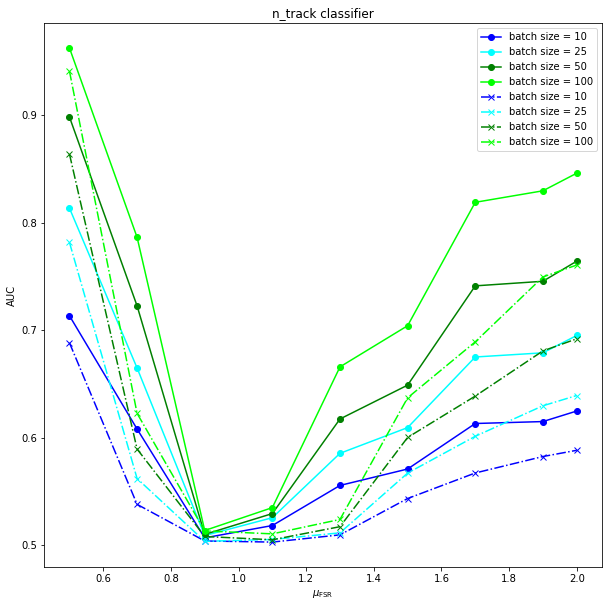

In [23]:
f = plt.figure(figsize=(10,10))
plt.plot(
    sorted_fsr,
    aucs_10,
    label='batch size = 10',
    marker='o',
    color='blue'
)
plt.plot(
    sorted_fsr,
    aucs_25,
    label='batch size = 25',
    marker='o',
    color='cyan'
)
plt.plot(
    sorted_fsr,
    aucs_50,
    label='batch size = 50',
    marker='o',
    color='green'
)
plt.plot(
    sorted_fsr,
    aucs_100,
    label='batch size = 100',
    marker='o',
    color='lime'
)

plt.plot(
    sorted_fsr,
    aucs_10_rnn,
    label='batch size = 10',
    marker='x',
    color='blue',
    linestyle='-.'
)
plt.plot(
    sorted_fsr,
    aucs_25_rnn,
    label='batch size = 25',
    marker='x',
    color='cyan',
    linestyle='-.'
)
plt.plot(
    sorted_fsr,
    aucs_50_rnn,
    label='batch size = 50',
    marker='x',
    color='green',
    linestyle='-.'
)
plt.plot(
    sorted_fsr,
    aucs_100_rnn,
    label='batch size = 100',
    marker='x',
    color='lime',
    linestyle='-.'
)
plt.legend()
plt.grid()
plt.ylabel('AUC')
plt.xlabel(r'$\mu_\mathrm{FSR}$')
plt.title('n_track classifier')

plt.legend()
plt.grid()
plt.ylabel('AUC')
plt.xlabel(r'$\mu_\mathrm{FSR}$')
plt.title('n_track classifier')

In [49]:
sorted(d_reverse.values())

['0d64b32',
 '468a1e4',
 '832aabb',
 '83b91b4',
 'ca2044e',
 'cee0f39',
 'de41eff',
 'e800916',
 'f3e9092']

In [28]:
d.values()

[0.9, 1.3, 1.1, 2.0, 1.7, 0.5, 0.7, 1.5, 1.9]

# Test regression

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
targets = np.load('test_targets.npy')
thetas = np.load('test_thetas.npy')
predictions = np.load('test_predictions.npy')

In [3]:
np.unique(thetas)

array([0.5, 0.7, 0.9, 1. , 1.1, 1.3, 1.5, 1.7, 1.9, 2. ], dtype=float32)

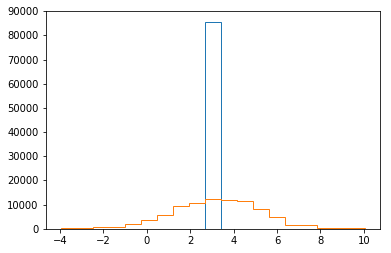

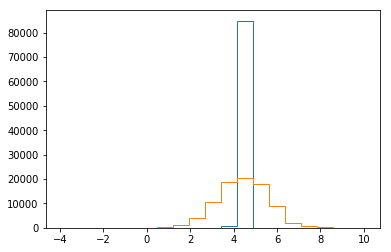

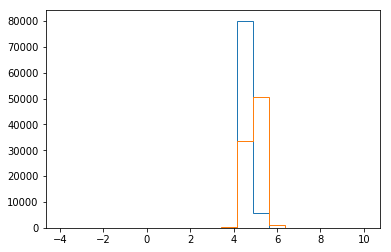

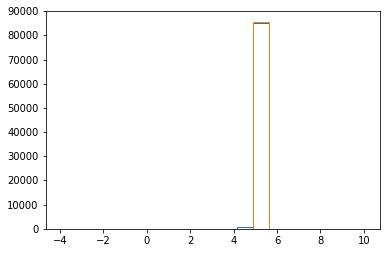

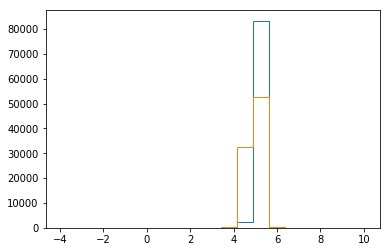

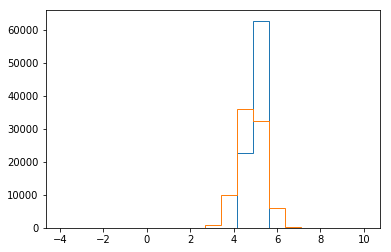

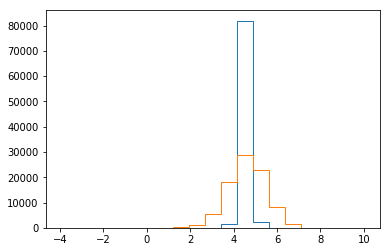

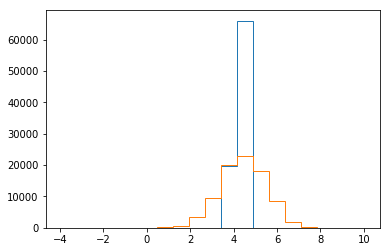

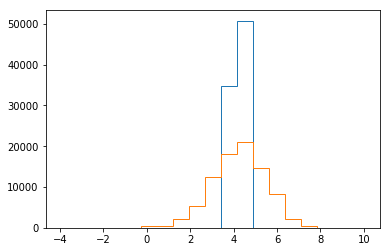

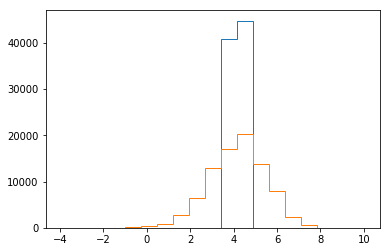

In [14]:
for theta in np.unique(thetas):
    bins = np.linspace(targets.min(), targets.max(), 20)
    _ = plt.hist(predictions[thetas == theta], bins=bins, histtype='step', label='predictions')
    _ = plt.hist(targets[thetas == theta], bins=bins, histtype='step', label='targets')
    plt.show()

In [12]:
len(np.unique(predictions[thetas == 0.5]))

248

In [8]:
z = np.random.normal(0, 5, sum(thetas == 1.7))

In [7]:
predictions[thetas == 1.7].shape

(85635,)

In [9]:
z.shape

(85635,)

In [128]:
d = np.array([(0.5, 0.053780988166162856),
 (0.6, 0.11297122457760689),
 (0.7, 0.29982295236724543),
 (0.8, 0.651499072557294),
 (0.9, 0.9209472301928009),
 (0.95, 0.9819755664694102),
 (0.98, 0.9972963416242728),
 (0.99, 0.9993421869836222),
 (1.0, 1.0000049261073816),
 (1.02, 0.997527404446179),
 (1.05, 0.9855849608191181),
 (1.1, 0.9489640238171403),
 (1.15, 0.8986723966477909),
 (1.2, 0.8411482164484947),
 (1.3, 0.7212327484774999),
 (1.4, 0.6099067854263222),
 (1.5, 0.5139905117495007),
 (1.6, 0.43383678790024527),
 (1.7, 0.3677800038721635),
 (1.8, 0.31449260689027886),
 (1.9, 0.27156641359598094),
 (2.0, 0.2361622013974317)])

(0, 1.1)

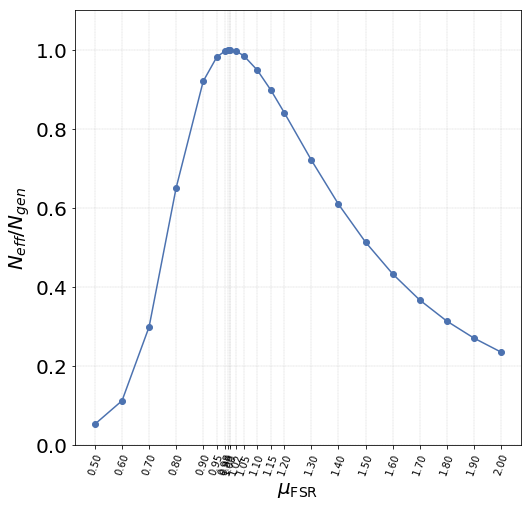

In [134]:
f, ax = plt.subplots(figsize=(8,8))
plt.plot(d[:, 0], d[:, 1], marker='o')
ax.set_xticks(d[:, 0])
ax.set_xticks([1], minor=True)
plt.xticks(rotation=70, fontsize=10)
ax.xaxis.grid(True, 'both', linestyle='dashed', linewidth=0.3)
ax.yaxis.grid(True, linestyle='dashed', linewidth=0.3)

plt.xlabel(r'$\mu_\mathrm{FSR}$')
plt.ylabel(r'$N_{eff} / N_{gen}$')
plt.ylim(0, 1.1)